# IMPORT

In this notebook I did not normalized images before evolving, just when predicting

In [1]:
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
import pickle
import time
from skimage.measure import compare_ssim
import tensorflow as tf
from keras.models import Model,load_model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input, Activation
from keras.utils import to_categorical
import keras

Using TensorFlow backend.


In [2]:
np.random.seed(0)

# GLOBAL VARS

In [10]:
INDIVIDUALS = 50
P_CROSS = 0.8
P_MUTATION = 0.01
CIFAR_IMG= 32

# THE DATA

In [11]:
from keras.datasets import cifar10

# The data, split between train and test sets:
(x_train_C, y_train_C), (x_test_C, y_test_C) = cifar10.load_data()
print('x_train shape:', x_train_C.shape)
print(x_train_C.shape[0], 'train samples')
print(x_test_C.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
num_classes=10
epochs=10
img_shape=32 
y_train_C = to_categorical(y_train_C, num_classes)
y_test_C = to_categorical(y_test_C, num_classes)


input_shape=(32,32,1)

x_train_C = x_train_C.astype('float32')
x_test_C = x_test_C.astype('float32')
x_train_C /= 255
x_test_C /= 255


print('x_train shape:', x_train_C.shape)
print('Number of images in x_train', x_train_C.shape[0])
print('Number of images in x_test', x_test_C.shape[0])
print('y_train shape:', y_train_C.shape)
print("input shape: ",input_shape)


# CONVERT TO GRAY SCALE

import matplotlib.pyplot as plt
import numpy as np

def grayscale(data, dtype='float32'):
    # luma coding weighted average in video systems
    r, g, b = np.asarray(.3, dtype=dtype), np.asarray(.59, dtype=dtype), np.asarray(.11, dtype=dtype)
    rst = r * data[:, :, :, 0] + g * data[:, :, :, 1] + b * data[:, :, :, 2]
    # add channel dimension
    rst = np.expand_dims(rst, axis=3)
    return rst

x_train_C = grayscale(x_train_C)
x_test_C = grayscale(x_test_C)

# now we have only one channel in the images
img_channels = 1



x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
x_train shape: (50000, 32, 32, 3)
Number of images in x_train 50000
Number of images in x_test 10000
y_train shape: (50000, 10)
input shape:  (32, 32, 1)


# READ PICKLE FILES

In [12]:
with open('../../Subsets/subset_cifar', 'rb') as f:
    original = pickle.load(f)
    adversarial= pickle.load(f)
    original_y = pickle.load(f)
    adversarial_y = pickle.load(f)

In [13]:
print(f"Original shape {original.shape}")
print(f"Adversarial shape {adversarial.shape}")
print(f"Original labels shape {original_y.shape}")
print(f"Adversarial labels shape {adversarial_y.shape}")

Original shape (914, 32, 32, 1)
Adversarial shape (133, 32, 32, 1)
Original labels shape (914, 1)
Adversarial labels shape (133, 1)


# LOAD THE MODEL

3. CNN v2

This network is made for CIFAR 10. The network is taken from [this blog]( https://appliedmachinelearning.blog/2018/03/24/achieving-90-accuracy-in-object-recognition-task-on-cifar-10-dataset-with-keras-convolutional-neural-networks/) . In this version below I didn't use some things used in the blog e.g. z-score and data augmentation.


This network has training accuracy: 0.8940 , validation accuracy: 0.8245.

**NOTE:** Training really slow, try to avoid it.

In [14]:
# Network 3 
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers
from keras.callbacks import LearningRateScheduler
import numpy as np

input_shape = (CIFAR_IMG,CIFAR_IMG,1)
weight_decay = 1e-4
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=input_shape))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
 
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
 
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
 
model.add(Flatten())
model.add(Dense(10, activation='softmax'))
 
model.summary()


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


'''
history = model.fit(x=x_train_C,y=y_train_C, epochs=150, batch_size=64, validation_data=[x_test_C,y_test_C])

score= model.evaluate(x_test_C, y_test_C,verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

model.save_weights("CNN_CIFAR10_net3.h5")
files.download('CNN_CIFAR10_net3.h5')
'''

model = load_model("../../Models/CNN_CIFAR10_net3.h5")

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
activation_7 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_8 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)       

In [16]:
model

# GENETIC ALGORITHM FUNCTIONS

In [15]:

def computing_SSIM(individual,target):
    return compare_ssim(individual.reshape(CIFAR_IMG,CIFAR_IMG), target.reshape(CIFAR_IMG,CIFAR_IMG))

def calculate_fitness(model,ind,target_image,label,l1=0.2, l2=0.8, N=50, num_classes=10):
  # predict the population
  predictions=model.predict(ind.reshape(1,CIFAR_IMG,CIFAR_IMG,1) / 255.0)  
  # po is the ground truth prediction, so for label = 0, it will be prediciton[0]
  predictions=predictions[0]
  po=predictions[label]
  # set that value to 0
  predictions[label]=0
  # take next highest one
  pd = np.max(predictions)
  diff=pd-po
  return l1*computing_SSIM(ind.reshape(CIFAR_IMG,CIFAR_IMG),target_image.reshape(CIFAR_IMG,CIFAR_IMG)) +l2*(diff)
  


def pop_fitness(model,pop,target,label):
    return [calculate_fitness(model, p, target, label) for p in pop]

def flatten(imgs):
    # flatten all images in np array or list
    return np.array([im.flatten() for im in imgs])

def gaussian_noise():
    # draw one sample of noise from zero mean 1 variance Gaussian
    return np.random.normal(0, 10)

def p_noise(x):
  if 0.01 > np.random.uniform():
    return x + gaussian_noise()
  else:
    return x
    
def add_noise(image):
    noise_v=np.vectorize(p_noise)
    return noise_v(image) #np.array([x + gaussian_noise() if P_MUTATION > np.random.uniform(0.0, 1.0) else x+0 for x in image])

def k_crossover(im1, im2, k=2):
    c1, c2 = [], []
    # get k crossover points
    points = sorted([np.random.randint(0, CIFAR_IMG*CIFAR_IMG-1, 1) for p in range(k)])
    points = sorted([np.random.randint(0,CIFAR_IMG*CIFAR_IMG-1,1) for p in range(k)])
    im_1_split = np.split(im1, [int(p) for p in points])
    im_2_split = np.split(im2, [int(p) for p in points])
    
    # alternate between lists to realise crossover (theres got to be a more clever way to do this)
    for i in range(k+1):
        if i % 2 == 0:
            c1.append(im_1_split[i])
            c2.append(im_2_split[i])
        else:
            c1.append(im_2_split[i])
            c2.append(im_1_split[i])
    return np.concatenate(c1, axis=0), np.concatenate(c2, axis=0)

def tournament(pop, model, ground_truth, target, k=3):

    indices = np.random.choice(range(len(pop)), k, replace=False) #we get 3 indxes [2 34 46]    
    individuals = pop.take(indices,axis=0)
    scores = pop_fitness(model,np.expand_dims(individuals.reshape(individuals.shape[0],CIFAR_IMG,CIFAR_IMG),axis=3), ground_truth.reshape(CIFAR_IMG,CIFAR_IMG), target)
    index_max = np.argmax(scores)
    winner = individuals[index_max]
    return winner


def check_adv_termination(ind, label,ground_truth, model):
  # individual - the best one from the generation
  # label - class we want
  # ground_truth - the image (32,32)
  # model we are using 
  dist = 1-compare_ssim(ind.reshape(CIFAR_IMG,CIFAR_IMG),ground_truth.reshape(CIFAR_IMG,CIFAR_IMG))
  predictions= model.predict(ind.reshape(1,CIFAR_IMG,CIFAR_IMG,1)/255.0)
  predicted_label= np.argmax(predictions[0])
  if label != predicted_label and dist < 0.001:
    print("FOUND ADVERSARIAL")
    print(f"Fitness of the adversarial {calculate_fitness(model,ind,ground_truth,label)}")
    return ind
  return []

def init_pop_from_sample(n,img,label):
    x = np.array([add_noise(img) for i in range(n)])
    return x.reshape(n, CIFAR_IMG*CIFAR_IMG)

def uniform(p1, p2):
    LEN=1024
    for i in range(LEN):
        if np.random.uniform() > P_CROSS:
            a = p1[i]
            p1[i] = p2[i]
            p2[i] = a
    return p1, p2

Functions from the past, just didn't want to erase them yet

In [18]:
'''
def check_adverserial(pop, model, fitness, target,ground_truth):
    #print(f"this is adversarial function")
    preds=model.predict(pop.reshape(pop.shape[0],28,28,1))
    #print(f"These are predictions made here {preds}")
    for ind, pr in zip(pop,preds): 
      #print(f"prediction for an individual {pr}")
      preds=np.argmax(pr)
      #print(f"getting the index of highest value in predictions {preds}")
      #setting the value to 0
      pr[0]=0
      #print(f"this is our target {target}")
      #print(f"this is out ground_truth {ground_truth.shape}")
      fitness=computing_SSIM(ind.reshape(28,28),ground_truth.reshape(28,28))
      #print(f"these are the fitness values {fitness}")
      next_highest = np.argmax(pr)
      #print(f"getting the next highest value {next_highest}")
      if next_highest != target and fitness > 0.98:
          return ind, True
      return None, False

def init_pop(n, num, data, labels):
    indices = np.where(labels==num)[0]
    n_indices = np.random.choice(indices, n, replace=True)
    sample = np.take(data, n_indices, axis=0)
    return sample, np.full((n), num, dtype=int) # return sample+array of labels


Cyrils model

def save_trained_model(model, filename='SVC_model.sav'):
    pickle.dump(model, open(filename, 'wb'))
    
def load_trained_model(filename='SVC_model.sav'):
    return pickle.load(open(filename, 'rb'))

'''

'\ndef check_adverserial(pop, model, fitness, target,ground_truth):\n    #print(f"this is adversarial function")\n    preds=model.predict(pop.reshape(pop.shape[0],28,28,1))\n    #print(f"These are predictions made here {preds}")\n    for ind, pr in zip(pop,preds): \n      #print(f"prediction for an individual {pr}")\n      preds=np.argmax(pr)\n      #print(f"getting the index of highest value in predictions {preds}")\n      #setting the value to 0\n      pr[0]=0\n      #print(f"this is our target {target}")\n      #print(f"this is out ground_truth {ground_truth.shape}")\n      fitness=computing_SSIM(ind.reshape(28,28),ground_truth.reshape(28,28))\n      #print(f"these are the fitness values {fitness}")\n      next_highest = np.argmax(pr)\n      #print(f"getting the next highest value {next_highest}")\n      if next_highest != target and fitness > 0.98:\n          return ind, True\n      return None, False\n\ndef init_pop(n, num, data, labels):\n    indices = np.where(labels==num)[0]\n 

In [16]:
''' my part of the code ''' 
''' I know it is ugly, I will fix it . this is the intial version'''
# from Goorge Clooney paper
def quadrant_crossover(parent_1,parent_2):

  # reshape parents
  parent_1,parent_2= parent_1.reshape((CIFAR_IMG,CIFAR_IMG)), parent_2.reshape((CIFAR_IMG,CIFAR_IMG))
  # quadrants for both parents
  p1,p2,p3,p4,q1,q2,q3,q4 = [],[],[],[],[],[],[],[]
  child1, child2 = [],[]
  # getting random (x,y) point in 2D matrix
  x,y = np.random.randint(0,CIFAR_IMG-1), np.random.randint(0,CIFAR_IMG-1)  

  # choose which quadrant we want to crossover
  N = np.random.randint(0,3)
  #make quadrants
  for i in range(CIFAR_IMG):
    if (i<=x):
      p1.append(parent_1[i][:y+1])
      p2.append(parent_1[i][y+1:])
      q1.append(parent_2[i][:y+1])
      q2.append(parent_2[i][y+1:])
    else:
      p3.append(parent_1[i][:y+1])
      p4.append(parent_1[i][y+1:])
      q3.append(parent_2[i][:y+1])
      q4.append(parent_2[i][y+1:])

  if (N==0):
    ch1 = connect_quadrants(p1,q2,q3,q4)
    ch2 = connect_quadrants(q1,p2,p3,p4)
  elif (N==1):
    ch1 = connect_quadrants(q1,p2,q3,q4)
    ch2 = connect_quadrants(p1,q2,p3,p4)
  elif (N==2):
    ch1 = connect_quadrants(q1,q2,p3,q4)
    ch2 = connect_quadrants(p1,p2,q3,p4)
  else:
    ch1 = connect_quadrants(q1,q2,q3,p4)
    ch2 = connect_quadrants(p1,p2,p3,q4)

  return ch1,ch2

def connect_quadrants(q1,q2,q3,q4):
  left = np.concatenate((q1,q3))
  right = np.concatenate((q2,q4))
  image = np.concatenate((left,right),axis=1)
  return image.flatten()


def multi_crossover(parent1,parent2,target):
  pop= []
  # 2-k crossover
  pop.append(k_crossover(parent1, parent2))
  # Gorge Clooney crossover
  pop.append(quadrant_crossover(parent1,parent2))
  # uniform crossover
  pop.append(k_crossover(parent1, parent2,1))
  pop.append(uniform(parent1,parent2))
  # SSIM similarity 
  flattened_list = [y for x in pop for y in x] # need to flatten the list because pop is list of lists, cause every crossover function returns 2 obj
  ssim = [computing_SSIM(ind,target) for ind in flattened_list ]
  # taking the index of largest two score
  id1=np.argmax(ssim)
  ssim[id1]=0
  id2 = np.argmax(ssim)
  #returning parents
  return flattened_list[id1],flattened_list[id2]
  


In [17]:
def return_best_individual(pop,fitness):
  index = np.argmax(fitness)
  best = pop[index]
  return best, np.max(fitness)

In [18]:
def choose_better_child(ch1, ch2,ground_truth,label,model):
  # I named it better child, but we choose by this parents as well
  ch1_f = calculate_fitness(model,ch1.reshape(CIFAR_IMG,CIFAR_IMG),ground_truth.reshape(CIFAR_IMG,CIFAR_IMG),label)
  ch2_f = calculate_fitness(model,ch2.reshape(CIFAR_IMG,CIFAR_IMG),ground_truth.reshape(CIFAR_IMG,CIFAR_IMG),label)
  # change this into ternary operator
  if ch1_f>ch2_f:
    return ch1
  else:
    return ch2              


# THE MAIN LOOP

In [11]:
'''
This not necessary when using subset 
'''
'''
X = flatten(x_train)
X_t = flatten(x_test)
print(f"X train shape {X.shape}")
print(f"X test shape {X_t.shape}")
print(f"y train shape {y.shape}")
print(f"y test shape {y_t.shape}")
'''

'\nX = flatten(x_train)\nX_t = flatten(x_test)\nprint(f"X train shape {X.shape}")\nprint(f"X test shape {X_t.shape}")\nprint(f"y train shape {y.shape}")\nprint(f"y test shape {y_t.shape}")\n'

Initial fitness: 
 [-0.6026511461431953, -0.6000051484372123, -0.6021701931018659, -0.6006041253139418, -0.6004244799712981, -0.6072789099014444, -0.6008440375526389, -0.6028072332105026, -0.6006885876926543, -0.6013585899885311, -0.6028358544082802, -0.6015504606599633, -0.6015885488790933, -0.6014804608219875, -0.6004454484281585, -0.6004779667933497, -0.6025875582762965, -0.6012087695614785, -0.6031136021263543, -0.6024657349442949, -0.6013942666595877, -0.6026576573365855, -0.6037467088751517, -0.6023645694822634, -0.6025484634997302, -0.6038158647065505, -0.6003599802279517, -0.6009434220283429, -0.6008383247730514, -0.6004436459688791, -0.6023745206741072, -0.6004148813632234, -0.6002580716141109, -0.600181334539333, -0.599946509154337, -0.6004863315416914, -0.6010440148594202, -0.600136687861038, -0.6005043397654277, -0.6000831358042139, -0.6013947461730162, -0.6008685737409458, -0.6002374628113403, -0.6010965939628062, -0.6053474812931383, -0.6031917003585522, -0.60177767861560

C:\Users\Lora\Anaconda3\lib\site-packages\skimage\measure\_structural_similarity.py:155: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "


Generation 10
Max fitness value -0.599946509154337
Generation 20
Max fitness value 0.18714290054059607
Generation 30
Max fitness value 0.9760219409811004
Generation 40
Max fitness value 0.9809212391725525
Generation 50
Max fitness value 0.9818585917426157
Generation 60
Max fitness value 0.9827996603493946
Generation 70
Max fitness value 0.9835854914462479
Generation 80
Max fitness value 0.9838750007313442
Generation 90
Max fitness value 0.9840372429787316
Generation 100
Max fitness value 0.9840548048131673
Generation 110
Max fitness value 0.9844602300661067
Generation 120
Max fitness value 0.9844602300661067
Generation 130
Max fitness value 0.9844602300661067
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


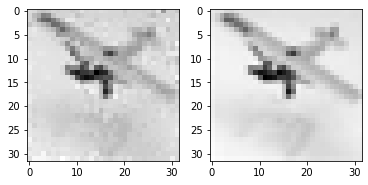

True label: 0
predicted label: 2
Time:  536.6249709129333  seconds
Initial fitness: 
 [-0.48996649593558306, -0.5332193461206636, -0.5115251663886999, -0.5341774620932823, -0.45544329825282615, -0.49005360600490017, -0.5013754893552574, -0.5727236729589451, -0.5313860706451423, -0.46898923468509524, -0.5161132708999996, -0.47613935284158265, -0.5199048707527144, -0.45841546229965413, -0.47896915825974173, -0.48879924933598995, -0.45661539260243855, -0.46712536077581224, -0.49627437783711004, -0.48908695299106963, -0.4933851153142176, -0.5067468591343929, -0.47073548518659164, -0.4194677507903728, -0.48074657053086856, -0.5286075502010266, -0.48816630356508245, -0.4900440460164397, -0.3974525999630274, -0.4929171867967038, -0.4367108523394028, -0.5067593182852956, -0.5510148656566566, -0.5584980485514136, -0.452101906156432, -0.5084360837589085, -0.5240671249122422, -0.5612323485486224, -0.4933866508545832, -0.4734227457759126, -0.5089633711177721, -0.5158500474577821, -0.48563624456246

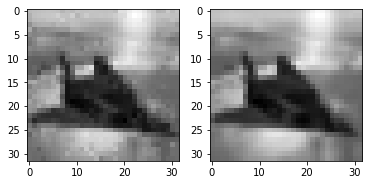

True label: 0
predicted label: 8
Time:  375.10476660728455  seconds
Initial fitness: 
 [-0.16915492898522277, -0.346018413304393, -0.268972823933431, -0.3304047057477393, -0.3931085246460898, -0.4034068134821817, -0.18092132987554702, -0.35144427122523403, -0.3730489326410489, -0.39927553909434776, -0.23765454949062728, -0.1515646451979081, -0.40151804322739504, -0.3976905253188178, -0.3459907514269134, -0.2838625838982255, -0.46926632010305513, -0.31912945246032953, -0.03979908275379729, -0.07693285996773092, -0.35393713625308776, -0.1838658153236933, -0.269305908454595, -0.1858302978625785, -0.342810653953593, -0.24000168882721254, -0.3632720334517934, -0.26247668963272286, -0.44932803729837756, -0.39988399064579816, -0.33153111095652316, -0.31241278204339235, -0.27302479506463967, -0.38890542707358244, -0.30877765190543216, -0.3228501173708951, -0.25117926034390625, -0.29319105931193157, -0.3392845998485704, -0.2894066278967974, -0.29025323078904985, -0.18447427840295189, -0.3187079

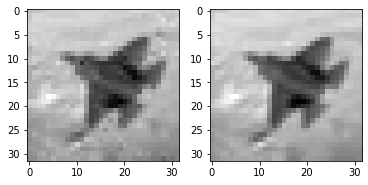

True label: 0
predicted label: 2
Time:  314.82515478134155  seconds
Initial fitness: 
 [-0.5962654518190851, -0.5946255490881964, -0.5962877964684855, -0.5948960842007839, -0.595991398898133, -0.5938655883063729, -0.5913183988268274, -0.5934442261907453, -0.591950967226123, -0.5930403049443623, -0.5970267936816618, -0.5949647058527809, -0.59501613490546, -0.5919822129290816, -0.5929251427701495, -0.5922421314138042, -0.5925698546377718, -0.5965898314634166, -0.5931917569058232, -0.5960087680759321, -0.5965766202142072, -0.5938931129116292, -0.595390193894628, -0.5919195302098241, -0.5930268382083068, -0.5867911230726185, -0.5981027728002906, -0.5956652644340301, -0.5915716279754559, -0.5937875865633004, -0.5958212097860878, -0.5921212728615042, -0.594506049611189, -0.5949020698272305, -0.5910427161655681, -0.5935252104937135, -0.5910417627565852, -0.5968597275794587, -0.5972977049178223, -0.5917750114401985, -0.5965430854652927, -0.5946475086394258, -0.5927929982781923, -0.594564934243

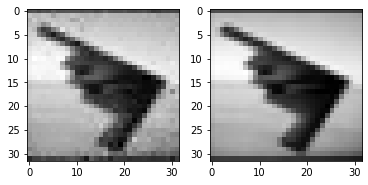

True label: 0
predicted label: 2
Time:  730.1116468906403  seconds
Initial fitness: 
 [-0.5179201976952036, -0.5500320280003202, -0.5443105748256443, -0.5844723900411767, -0.4811460712153254, -0.534728018175166, -0.5277717030509108, -0.5290887454387943, -0.5044510320388017, -0.5641924851102019, -0.5161551651216184, -0.5432158917458778, -0.5070394923256655, -0.5513815145263826, -0.53835440969243, -0.5527259086306565, -0.5358941741366205, -0.5308510175112011, -0.5182962201431837, -0.5453266762302664, -0.5426597505842524, -0.47069003943057, -0.5538814051453873, -0.5444655250462235, -0.5708302413128887, -0.5597384288318269, -0.5494261885997331, -0.5291875836803723, -0.5309624177763386, -0.5409467190891785, -0.5448064240968528, -0.522962019293989, -0.5752647926430237, -0.5482857964327913, -0.5207849233129388, -0.5432212106831571, -0.5471306835356361, -0.564277490495974, -0.5385739908703642, -0.5080884681710431, -0.5782468895948883, -0.5208127639302512, -0.49958202428509735, -0.5635399236369

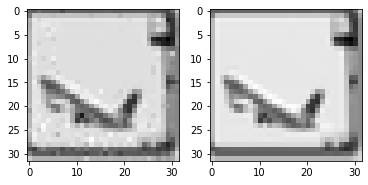

True label: 0
predicted label: 2
Time:  277.87460565567017  seconds
Initial fitness: 
 [-0.6092933257337655, -0.5962075659372338, -0.606464266980042, -0.6075827631982123, -0.6039647723080437, -0.6146911465383221, -0.5945250635423038, -0.6097149150202692, -0.602906705213752, -0.608622526002517, -0.6048580190042593, -0.6083164739907584, -0.612442224576806, -0.5978177909966664, -0.5996642792675545, -0.590178265330714, -0.6022732457441913, -0.6071067988974683, -0.5975956095423606, -0.6122771087669797, -0.5982687751652274, -0.605886555710621, -0.6032555316456367, -0.6113217807736847, -0.6040780929155536, -0.6141419607313168, -0.6088570241548812, -0.6035185880756564, -0.6055225863501209, -0.5972257702781201, -0.5996346693249305, -0.6049935354158218, -0.5946582344215473, -0.6094578290657887, -0.613136753025525, -0.6014765578555514, -0.6018560401548476, -0.5929402657298486, -0.6001751387674789, -0.5870421138776213, -0.5992744069611949, -0.6026637800715847, -0.6084520557348649, -0.5924140101116

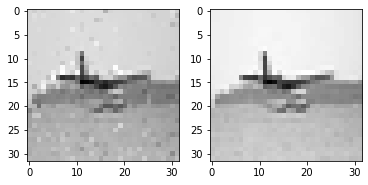

True label: 0
predicted label: 8
Time:  273.1765339374542  seconds
Initial fitness: 
 [-0.6014855475628024, -0.6067807678916696, -0.6022790508469041, -0.6036742583785702, -0.6011458071935778, -0.6067781702565644, -0.6127335253757255, -0.6070552912315187, -0.6036844597489673, -0.6025147430815412, -0.602983738316722, -0.6006639239015912, -0.6021453533567545, -0.600053589331234, -0.6048984505367643, -0.6060118162307058, -0.600545228556659, -0.601657126090887, -0.6012617554264558, -0.6051649521220086, -0.6052223192227548, -0.6038702627205607, -0.6007774203558293, -0.6018009140542441, -0.5997926506267685, -0.606792003975453, -0.6036909605434166, -0.6018287187684035, -0.6006101372324905, -0.6089945175073331, -0.6030938597204782, -0.6047131290047552, -0.6071114913855788, -0.5998516499074049, -0.6026510574644971, -0.5999337381136906, -0.6031957904385485, -0.6025617958582532, -0.6003306844050217, -0.6011212270203442, -0.6023054235462663, -0.6061567175279616, -0.6050699894531032, -0.599960842118

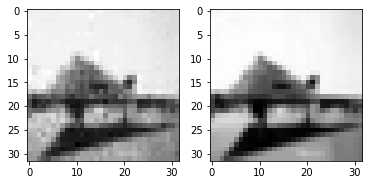

True label: 0
predicted label: 8
Time:  573.6389937400818  seconds
Initial fitness: 
 [-0.5963039811724522, -0.5929172376955754, -0.595086113028934, -0.5978685717661858, -0.5957463941790874, -0.5953496576298248, -0.5955247648256601, -0.5936331929766254, -0.5932950917774169, -0.5963458689654668, -0.5964532943446177, -0.5982166421185525, -0.5976433486715493, -0.5961204316235029, -0.5929945167767205, -0.5960329772026823, -0.5978886189926613, -0.5963198505037628, -0.5960565685375383, -0.5960941217981134, -0.5951225064491202, -0.5937960435450589, -0.595698622801473, -0.5964785354038572, -0.5948433620758268, -0.5960172554579412, -0.5969389816087947, -0.5958602781993926, -0.5962606603245635, -0.5942177970358705, -0.5971166164794095, -0.5963339338578924, -0.5960480621231777, -0.5972074703414898, -0.5911998696899465, -0.5964077647398229, -0.5975941197000995, -0.5946154141940287, -0.5958056212021545, -0.5956391947172174, -0.5952101054751693, -0.5944017538359003, -0.5947228118385989, -0.597396616

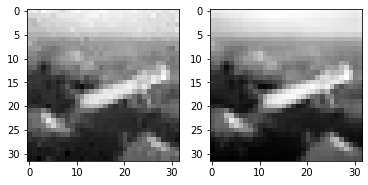

True label: 0
predicted label: 4
Time:  537.0764753818512  seconds
Initial fitness: 
 [-0.5686290725146061, -0.5892272283241614, -0.5780277952537781, -0.5815462661118975, -0.5658040871682414, -0.5803220317608003, -0.5787994824724971, -0.5829065213988058, -0.5756447539026768, -0.5754438214458094, -0.5802304960780514, -0.5755934842499788, -0.5804431772803857, -0.5909530135245799, -0.5765999222419983, -0.5815909661043945, -0.5726480794614532, -0.5680108937704141, -0.5855155621286672, -0.5772429823564834, -0.5774527556736931, -0.5789601590327782, -0.5873608994500102, -0.5812803382069816, -0.5711573422839831, -0.5671053269063053, -0.5853224431188965, -0.5874714700097593, -0.5703592867321482, -0.5870919621182832, -0.5844306598593993, -0.571030485930356, -0.5824451836083612, -0.5765755032376826, -0.5811551262455573, -0.5768717091601699, -0.5801314214505607, -0.5724770721331456, -0.5862478702708322, -0.5755828153923975, -0.5755176307843197, -0.5782619694438876, -0.5669608532056687, -0.57565529

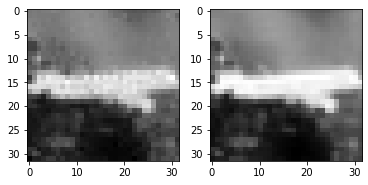

True label: 0
predicted label: 8
Time:  445.209189414978  seconds
Initial fitness: 
 [-0.2116491301082923, -0.08003495410107658, 0.03765588832486427, -0.15159001061015276, -0.12153606370893749, -0.07106451794539045, -0.30967000693082636, -0.0945457218348992, -0.08145939097781763, -0.042726157651945235, -0.11718132625477046, -0.050668881119138504, -0.3268026437418833, -0.10973947130721365, -0.22262336291875778, -0.20330623794075803, 0.07939939294162554, -0.11209201804805419, 0.016330783501048107, 0.03829968815499099, -0.0037144790217777945, 0.06261268645101065, -0.01618376413749323, 0.029096859261505348, 0.3170732733179732, 0.1371319078145025, -0.17662793231461532, 0.04390877717511513, -0.27616675497591237, -0.2687846023772247, -0.0909806069780606, -0.10455371195953278, -0.0472016867859148, -0.10500045835520286, -0.28187612636023907, -0.2128278576915361, -0.024677574010145642, -0.24294746323034008, -0.23061681455705926, -0.041113911523891905, -0.040645007075980955, -0.21687819039337644,

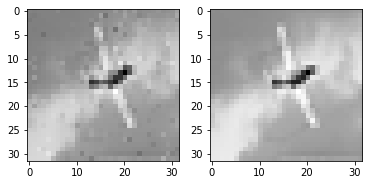

True label: 0
predicted label: 4
Time:  241.95870971679688  seconds
Initial fitness: 
 [-0.2879539791205158, -0.5426108455978699, -0.5026471514606563, -0.5084040175992327, -0.5472786799650095, -0.4794284547684209, -0.4987834438254406, -0.5494960700276705, -0.5636332159492681, -0.510980800328479, -0.5547063619247663, -0.49652037306482344, -0.44571992536377086, -0.5444707914840469, -0.5159051941260411, -0.5069145915354829, -0.5399465652451886, -0.4496239848364132, -0.519473905673056, -0.5743883926764197, -0.5121020713202437, -0.5159346238184108, -0.5419998777942869, -0.49490956015457976, -0.49691788303046014, -0.5114588920755936, -0.4863601996878484, -0.48603195771874613, -0.47731221488625986, -0.4681015809312905, -0.49182319092685595, -0.5437066788591011, -0.568101866325804, -0.5164573232653024, -0.5160420349752359, -0.5227806043815573, -0.5362985871370217, -0.5640240327959634, -0.5029508337208997, -0.4860091717502674, -0.5529166860459548, -0.49058899222631436, -0.532779511020326, -0.50

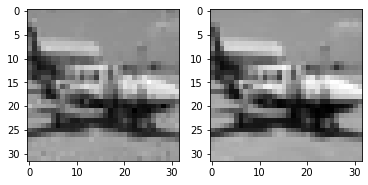

True label: 0
predicted label: 9
Time:  312.82915592193604  seconds
Initial fitness: 
 [0.4099361892287895, 0.5257747055068549, 0.424264499890298, 0.4293140567633894, 0.35641004351508887, 0.4403816882098859, 0.4678042883347594, 0.45084930645907, 0.37869778595954023, 0.4386109354966481, 0.4549752182252414, 0.481429322330258, 0.48287426199048095, 0.3998656043935923, 0.36327678200532243, 0.5583367325720539, 0.6394358161378655, 0.3940668429712679, 0.4252925462189588, 0.4028539621500753, 0.4503797596371535, 0.34374477183791324, 0.4188895091778254, 0.42333997211112395, 0.46499243952040714, 0.4457753335143242, 0.4119194246093617, 0.36558431842756556, 0.44514149436962525, 0.3838165347599719, 0.40969498397019066, 0.44147147899788186, 0.37614528724968843, 0.436368593842154, 0.37325012186798534, 0.39823565745964884, 0.3743747490706698, 0.3726808519115976, 0.6041270127536269, 0.38096164946276123, 0.598624172501736, 0.40634361109096645, 0.38805708492079183, 0.4534240813060807, 0.5823856081186691, 0

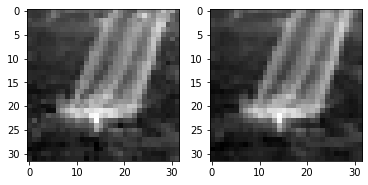

True label: 0
predicted label: 2
Time:  315.03972339630127  seconds
Initial fitness: 
 [-0.0799793724927218, -0.28034110017105607, -0.29859413253986267, -0.15934114880190006, -0.15563982551193514, -0.2021036004599684, -0.17548839099929284, -0.25593610826318824, -0.39009613274018456, -0.31765652890358576, -0.1651960999966481, -0.35841337185245736, -0.2150633580178178, -0.5040005992078975, -0.13102666846658328, -0.2696546050394485, -0.21226834810406311, -0.04684968225328154, -0.25991668665048484, -0.36330980365814514, -0.36016554634200104, -0.35646879729520176, -0.22702809496750914, -0.25335695494799226, -0.2775984607011617, -0.17234092419299007, -0.28119328417855743, -0.16719054379940662, -0.3048954463921809, -0.15465595726213802, -0.4953790799475448, -0.2735540997276512, -0.18301269831976197, -0.08513311756675906, 0.03151855986893068, -0.2696703608555487, -0.41143446611908085, -0.16762558754843263, -0.15640774032377794, -0.36666782280988364, -0.23064192652133034, -0.2296928998201524, -

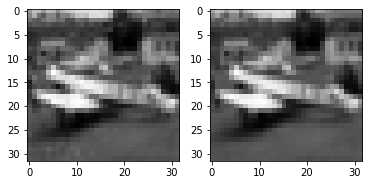

True label: 0
predicted label: 8
Time:  403.8511664867401  seconds
Initial fitness: 
 [-0.6005621498497573, -0.6010548269891771, -0.6024176772519301, -0.6002702949953032, -0.6031351460315838, -0.6008310863094771, -0.6014512431257157, -0.6012809716028806, -0.6000407121858201, -0.6005671959840311, -0.6020421113216832, -0.6003883856233471, -0.6013566418643513, -0.6010644842059639, -0.6001980022584926, -0.6038292783352026, -0.6004069516404068, -0.6002979843942189, -0.6045757910813517, -0.6005454651605412, -0.6002621173460564, -0.6002170937624928, -0.602088208605603, -0.6005509402001629, -0.6031401169025671, -0.6024673867603608, -0.6025624209034917, -0.6027197938070816, -0.6025828164841964, -0.6020649191041447, -0.6000937902221589, -0.6018175531978357, -0.6020940494837685, -0.6024665810910488, -0.6006776140834179, -0.6022346607914989, -0.6021219659055682, -0.6007874119823343, -0.6009327208787307, -0.6020963663433808, -0.601797254564599, -0.6003942723191871, -0.6022802148232567, -0.600556809

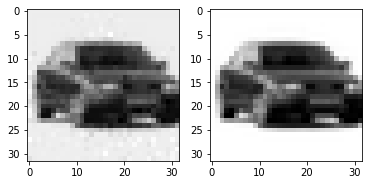

True label: 1
predicted label: 8
Time:  532.4187097549438  seconds
Initial fitness: 
 [-0.5072332077555466, -0.5777268966521867, -0.5305995695642239, -0.5629443455787309, -0.5209553860416964, -0.5362662271418417, -0.5521507206010297, -0.5442861011768008, -0.5531116189737983, -0.5385568049081394, -0.5121049584090653, -0.5419671180128408, -0.5430801127648972, -0.5486496238116491, -0.5285835048061613, -0.5816685261915275, -0.4975140261424962, -0.5095985507629017, -0.5448374229056603, -0.5566614129066213, -0.5528744876539878, -0.5442836152774598, -0.5446141036468868, -0.5111697644247735, -0.4961083859537496, -0.5334692648153723, -0.535836813725064, -0.44937278987841855, -0.5202167306254093, -0.5307993487556849, -0.5468512452621642, -0.5351729725837897, -0.538069444277841, -0.5000055306647196, -0.5577875702609226, -0.47655067987677324, -0.5331324915374056, -0.44377453285005, -0.5059031167688897, -0.5481100142280039, -0.5707593506687746, -0.5002195978063996, -0.5052548505347879, -0.571435978

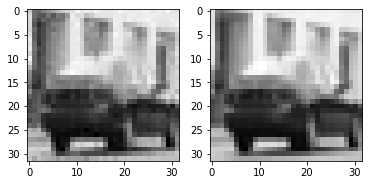

True label: 1
predicted label: 9
Time:  790.6642711162567  seconds
Initial fitness: 
 [-0.6028511537814893, -0.6026418455421619, -0.6060602444864668, -0.6004990688496552, -0.6031953125151208, -0.6031142399707863, -0.601425293815146, -0.6023014770061061, -0.6032027963776084, -0.6052357272393486, -0.6091158739449233, -0.601677684854338, -0.6032590677224305, -0.6023381658027823, -0.6002779405881704, -0.6019638450554389, -0.6000555174828691, -0.6005047621982932, -0.6065682569747124, -0.6015776840868688, -0.6002947367345715, -0.6007567185671553, -0.6066207765480387, -0.6017315657255395, -0.606165441668034, -0.6036624196205853, -0.6015785698237837, -0.6043141382504955, -0.602850364296504, -0.6015915439509435, -0.6014048614008022, -0.60555825490182, -0.6045818320112085, -0.6044425948669541, -0.6049772947805819, -0.6011843774572507, -0.6014178512242553, -0.6013017468557718, -0.6016023444715415, -0.6011879177267649, -0.6038250679478532, -0.6015046975989137, -0.6000705054938611, -0.6000245564584

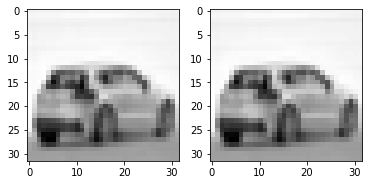

True label: 1
predicted label: 1
Time:  178.0922405719757  seconds
Initial fitness: 
 [0.49789928716946863, 0.46346894647790315, 0.3031121095120525, 0.5007746500724078, 0.5349557696603464, 0.43413849164159724, 0.46697146135704626, 0.6219313484134494, 0.23360245578307653, 0.38722565234422546, 0.22525798145133086, 0.26162176591869946, 0.2457918502461057, 0.3362971685728472, 0.28188701767962954, 0.2184831753225614, 0.23267905062782765, 0.15769642200718237, 0.601979573998175, 0.3348329252820669, 0.48681008827014355, 0.45543156221711145, 0.37241923188461007, 0.4731714016818598, 0.4716319300535377, 0.4563216049056693, 0.4810592481171991, 0.36762798635370586, 0.6505492107300361, 0.5171131189077194, 0.5558539336233583, 0.24158121428926552, -0.010559687556656677, 0.5836067032182728, 0.3192999189120355, 0.43187290733034006, 0.6723742959948537, 0.27580424336612314, 0.4388506436431165, -0.13983843523187367, 0.3319930184822546, 0.5411525897742844, 0.2630176717099882, 0.41281424834384384, 0.64548391

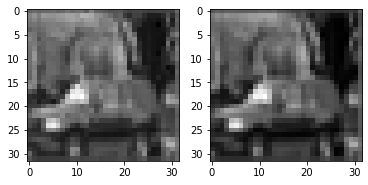

True label: 1
predicted label: 7
Time:  374.6660108566284  seconds
Initial fitness: 
 [0.4876334528334403, 0.5064468761971015, 0.5513483033779439, 0.5333222764548509, 0.4545681131437268, 0.5481087428684936, 0.5679761730422885, 0.4260087815422582, 0.4079555581795261, 0.5695175222879191, 0.5491783805351176, 0.5284263461485974, 0.4791637392293181, 0.5498179347716938, 0.5126431216339855, 0.5559390479496277, 0.5760431607670856, 0.48726613101645, 0.6301644735901444, 0.5117392163426226, 0.6327910752496784, 0.4603943807177622, 0.4645939709923043, 0.5557190752063641, 0.572170560767736, 0.5826413071907938, 0.5560332294431558, 0.524149172430806, 0.5617646894868207, 0.569739458906379, 0.5653736045356692, 0.565949210914496, 0.5229918568443324, 0.49681390592450403, 0.4989579933720043, 0.5702796242559789, 0.4298514674312012, 0.5367174040424776, 0.5107504932868198, 0.46892463189243366, 0.6452110141501133, 0.4155646061958705, 0.45572294176862393, 0.5534561748610203, 0.6316928205935454, 0.56973510291003

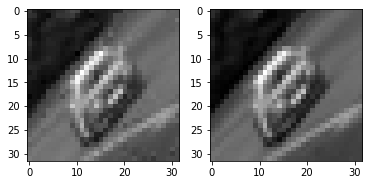

True label: 1
predicted label: 6
Time:  461.5935273170471  seconds
Initial fitness: 
 [-0.5911394140256323, -0.595952459655101, -0.5871310164264698, -0.5980304517957516, -0.5457372731453836, -0.589554164002476, -0.5921981881449634, -0.5911138215585386, -0.5955260950631414, -0.5916940185818678, -0.5928981808157139, -0.5965505793699749, -0.5916808945817147, -0.5948374301995791, -0.5913738232432709, -0.5943776094745685, -0.5916314054567544, -0.5925201029329971, -0.5906562478184795, -0.5764865796064595, -0.5863457289445614, -0.5943509960843643, -0.5929925745545572, -0.5790865221406125, -0.5918933174902494, -0.5871061580007129, -0.5903712126301663, -0.5895931806371323, -0.5871268206314785, -0.5792844447666636, -0.5924799425950286, -0.593884822930061, -0.5764224782477254, -0.5838159353855923, -0.593021313473231, -0.5932191559248884, -0.5959275744093313, -0.593767688478316, -0.5933240090545118, -0.5376897194238957, -0.5841942113439607, -0.5938627000600697, -0.5874368380772967, -0.592006214717

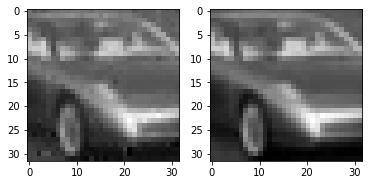

True label: 1
predicted label: 0
Time:  667.4350187778473  seconds
Initial fitness: 
 [-0.6000398689549299, -0.600034487409535, -0.6000493754986107, -0.6000435767984232, -0.6000738197512564, -0.600045832609597, -0.6000313329510676, -0.6000800417426801, -0.6001040905634648, -0.6000077951712933, -0.6000760211802592, -0.6000319083586905, -0.6000259761206984, -0.6000478034502266, -0.6000392699772978, -0.6000792326669652, -0.6000420619323196, -0.6000206203821782, -0.600008875071946, -0.6000323606707113, -0.6000099344259213, -0.6000933086483976, -0.6000229188662695, -0.600044931233054, -0.6000316162672666, -0.6000158248675832, -0.6000529902481297, -0.600041428212057, -0.6000102582861381, -0.6000520773822042, -0.6000729222198067, -0.6000092729174163, -0.6000733944296368, -0.6000384603216107, -0.6000191941071935, -0.6000318473243628, -0.6000149322999313, -0.600017681013999, -0.6000978090906977, -0.6000429339315492, -0.6000582094572524, -0.6001731464626543, -0.6000488296849947, -0.6000212814657

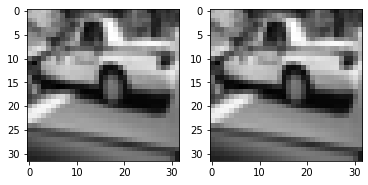

True label: 1
predicted label: 1
Time:  119.91025972366333  seconds
Initial fitness: 
 [-0.6002795582234843, -0.6013440114537046, -0.6000227056907538, -0.6000349180254492, -0.6002211624347555, -0.6007690980579888, -0.6001903260393809, -0.6002066168732099, -0.6006270874524344, -0.600152267864975, -0.6001784097130356, -0.6002908216685581, -0.6008993583576026, -0.6000814773901003, -0.6019545277248577, -0.6007420770279716, -0.6021070216258423, -0.6003281431282571, -0.6005755849866469, -0.6001099703517557, -0.6000639109554836, -0.6002099680357816, -0.6001094742310448, -0.6010642589964845, -0.6009276395786451, -0.6005093314859395, -0.6002340060833091, -0.600237079269805, -0.6003718955499101, -0.600311669823749, -0.6002363547139736, -0.6004537737274982, -0.6003877073337647, -0.6008207792300135, -0.6003380809215534, -0.6000303528509142, -0.6010254849333904, -0.6002669926991364, -0.600091413106796, -0.6002152093272419, -0.6000140664858039, -0.601703404991332, -0.6002070737084244, -0.60005055312

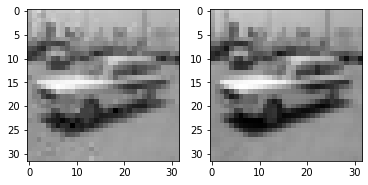

True label: 1
predicted label: 0
Time:  276.3644881248474  seconds
Initial fitness: 
 [-0.6000527121232939, -0.6000393647556941, -0.6000157137390257, -0.6000898388731928, -0.6000481329362342, -0.6000301237484201, -0.6000393658714135, -0.6000158992032048, -0.6000661281359516, -0.6000549528387815, -0.6000505391744285, -0.6000941936163058, -0.6000485980116301, -0.6000312366062652, -0.6001005552779416, -0.6000796505586508, -0.6000457123720546, -0.6000600241247144, -0.6000562776280345, -0.6000363402718297, -0.600053984585244, -0.6000424994361623, -0.600018189595936, -0.6001021803466661, -0.6000278913853991, -0.6000227240793484, -0.6000216703848296, -0.6000680659460669, -0.6000363883391816, -0.6000431830029067, -0.6000224745072711, -0.6000152038970011, -0.6000303280073388, -0.6000440036428966, -0.6000439152489921, -0.600033092325867, -0.6000277833196093, -0.6000552693459902, -0.6000841371430813, -0.6000307796618931, -0.6000164958086815, -0.6000638583947799, -0.6000908364971789, -0.6000078159

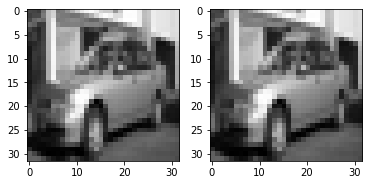

True label: 1
predicted label: 1
Time:  120.29507279396057  seconds
Initial fitness: 
 [-0.5994462248157906, -0.5998589004491991, -0.6000560846958019, -0.5994862201992084, -0.5993621424516117, -0.5999051960898969, -0.5997929079253883, -0.5999948056955889, -0.5996843299808448, -0.5997040014118508, -0.5996329482552128, -0.5996939831249177, -0.5995302842135171, -0.599752373948168, -0.5997752109093224, -0.5999064245208584, -0.5995556840915229, -0.5999657797304925, -0.5997856599649009, -0.5997121982044289, -0.5998552481742825, -0.5993427803767276, -0.5996262302790268, -0.5991622579991056, -0.5995814261169781, -0.5997145221394826, -0.5995533657462278, -0.5990729970871801, -0.599749645592669, -0.5994405630191872, -0.5997188631004527, -0.599825906223307, -0.5993918475642819, -0.5997635539053289, -0.5998593449299274, -0.5997513317055638, -0.5996166717340379, -0.5995708213623704, -0.5995469766087158, -0.5998895341687835, -0.5997957654526674, -0.6002256021954218, -0.5997880586200244, -0.599282572

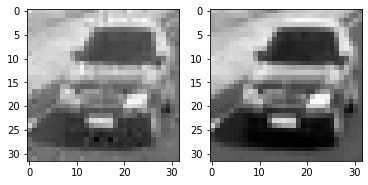

True label: 1
predicted label: 9
Time:  394.9592378139496  seconds
Initial fitness: 
 [-0.6000250051997531, -0.6000522768703856, -0.6002371197670329, -0.6003475272797072, -0.600184436907152, -0.6001633051350694, -0.6000686609786772, -0.6001442726193804, -0.6005630278169095, -0.6000906606322338, -0.6000659099855239, -0.6001414626576744, -0.6000888114961134, -0.6001165065827714, -0.6000847721104309, -0.6001398851062892, -0.6002299784353149, -0.6001249238566283, -0.6001158848583138, -0.6002591585800288, -0.6001407792123779, -0.6001682220451016, -0.6003461286050311, -0.600045582063915, -0.6002258338347823, -0.6003305289402396, -0.6000186842391011, -0.6000493673117818, -0.600118568662718, -0.6000762660167178, -0.6002044240257909, -0.6001020470383875, -0.6001051437714497, -0.6000764590754831, -0.6000980447239934, -0.600098514978624, -0.6001081183381803, -0.6000660267006317, -0.6000330469031473, -0.600209950020831, -0.6001225656604342, -0.6002712718130914, -0.6000887176957086, -0.600159757742

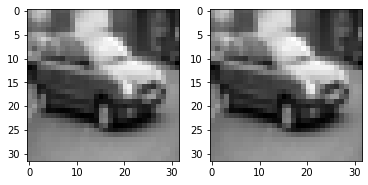

True label: 1
predicted label: 1
Time:  120.4832067489624  seconds
Initial fitness: 
 [-0.6000804732465418, -0.6004381422912619, -0.6001872159908985, -0.600058491349452, -0.6000309720137558, -0.600058184718107, -0.600395022744055, -0.600135574237208, -0.6000751389564932, -0.6000599905911741, -0.6002384946166228, -0.6001865198216578, -0.6000852177643092, -0.6001635108067308, -0.6003374391071868, -0.6001583820058604, -0.6000957574470427, -0.6000523272455954, -0.6002534754266734, -0.6001929192542246, -0.6003119612923411, -0.6000092277084443, -0.6002124580945917, -0.6002207769721438, -0.600700670699691, -0.6001170713811643, -0.6001350633831806, -0.6003818049567687, -0.6002125263291531, -0.6004098560347159, -0.6002948589875334, -0.6002319819226148, -0.6005461634642567, -0.6000848645619292, -0.6000745922316648, -0.6000491654806545, -0.6000939787966968, -0.6002611583137674, -0.6003808994653709, -0.6001105734639798, -0.6002519688179315, -0.600672530725438, -0.6002663950359532, -0.6000821953896

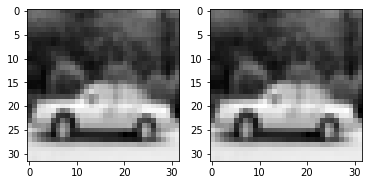

True label: 1
predicted label: 1
Time:  120.31207752227783  seconds
Initial fitness: 
 [-0.5837229847639646, -0.5925139768126615, -0.5914080338538519, -0.5939414641695103, -0.5937671002555581, -0.5904427885435041, -0.5943486840964455, -0.5939816139412832, -0.592938063684374, -0.5907462203656577, -0.5896879695348141, -0.591771701302589, -0.5938718671417114, -0.5880398044020746, -0.5901086011185079, -0.5982003409194773, -0.5929931606026663, -0.5949471366697888, -0.5939867577994409, -0.5912584322436825, -0.5838368707945675, -0.5939980849830842, -0.5957783987306164, -0.5933737440806244, -0.5911064410434678, -0.5940481487490098, -0.5931796293408343, -0.5916887197091252, -0.5918561754942379, -0.5947440451872843, -0.5951599025824523, -0.5898526487003606, -0.5930031925645547, -0.5911656108815948, -0.576393607883963, -0.5924290859175096, -0.5930012564089246, -0.5920127931112816, -0.5950694644557312, -0.5946280550466246, -0.5931738628637544, -0.5927971632980426, -0.5953606952460209, -0.594996414

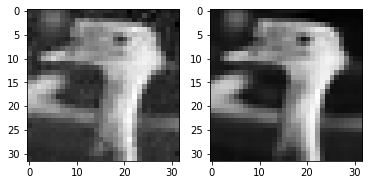

True label: 2
predicted label: 3
Time:  1055.6753866672516  seconds
Initial fitness: 
 [0.6620607353866008, 0.6099707640293479, 0.5625883245428246, 0.7286250655304557, 0.6674427945938634, 0.662458838529959, 0.5933334640706217, 0.718727198838166, 0.6059788129754146, 0.7496212051836446, 0.7473314512986807, 0.6364755760770969, 0.549459088208242, 0.45889311601152316, 0.710608713244324, 0.4846216604213751, 0.6352625147255619, 0.601182631603034, 0.6544838406412631, 0.512763510276689, 0.6126367734101417, 0.6340093604367196, 0.6228403097193147, 0.8857090171364905, 0.8716646683885116, 0.5577969186128011, 0.6105899459709405, 0.7563953539809295, 0.5050126847645803, 0.7089627745399126, 0.4468802274693835, 0.7905423805280085, 0.4905866316276887, 0.6461251366123502, 0.6234611661439194, 0.29340831426999, 0.2879558668047337, 0.6372150864315701, 0.39430701355714054, 0.7109170083017345, 0.7663297051256526, 0.6696628363912636, 0.5889985202143219, 0.6887000802948133, 0.7172687417712637, 0.6487385183836869

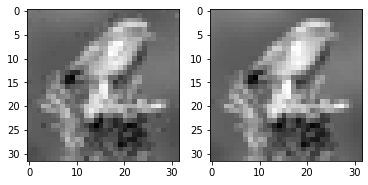

True label: 2
predicted label: 6
Time:  201.78998851776123  seconds
Initial fitness: 
 [-0.2738785553505457, -0.22775946051278018, -0.2977169835513175, -0.12817652284306869, -0.28635920800211623, -0.1911244213857192, -0.19648800542668787, 0.09942305525087548, -0.18967131458107453, -0.07944859878858807, -0.28374790258841176, -0.1934015562905998, -0.3044711006664913, -0.288083323637314, -0.0672181425642823, -0.17155616608406407, -0.17997125860583207, -0.24027948848716935, -0.2001223982053451, -0.04780648085898287, -0.22167996646805932, -0.23074944343471576, -0.28629548033222846, -0.18414538454497426, -0.18300195398492403, -0.179890742665584, -0.23657834826362775, -0.3180029808873359, -0.2372481368285283, -0.23079643627998392, -0.12354931996369384, -0.2636680413048311, -0.2554722609518013, -0.10929379949022319, -0.1644715626968971, -0.23974016764537234, -0.1016998029427584, -0.2533949839204687, -0.23350666330628062, -0.15685095421082823, -0.28482814774960563, -0.171444099537768, -0.275479

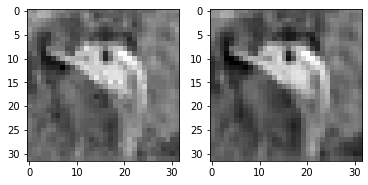

True label: 2
predicted label: 6
Time:  308.027955532074  seconds
Initial fitness: 
 [-0.4287907761523731, -0.2792948361673244, 0.12421339011625303, -0.0796483371210357, -0.17567566559918577, -0.17340585277291576, -0.23331017040264548, -0.28698218332392605, -0.10350297639759432, -0.21909053791774863, -0.22024946769131598, -0.16575040271760988, -0.367824196643575, -0.19650187888610543, -0.1642497086947406, -0.18910848527940846, -0.16210585550498743, -0.21569334811558935, -0.11196408138381589, -0.18512608072266826, -0.2291313689609965, -0.23342265821159522, -0.17185027125799623, -0.2010261196979113, -0.16636315340570818, -0.1927397494285873, -0.2862451731678356, -0.41913782272966765, -0.28006701774832427, -0.09899827925163682, -0.38741909581901435, 0.09065177945924052, -0.27002694678016603, -0.1715617043628701, -0.24844774186718718, -0.33550013338313966, -0.24557711328987536, -0.17762892345459988, -0.19140197426534267, -0.32275432536499804, -0.22094312618852716, -0.2197524673682861, -0.2

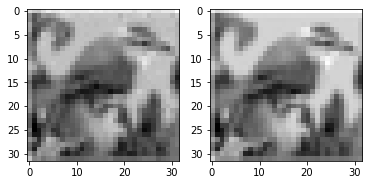

True label: 2
predicted label: 5
Time:  451.2821500301361  seconds
Initial fitness: 
 [-0.6001470651602429, -0.5997210051184637, -0.6000202504609204, -0.6003416972128294, -0.5998378120579994, -0.5999747702575375, -0.6008729130251294, -0.6012436699572523, -0.6005096435760293, -0.6000348481614568, -0.6000422099138683, -0.6008250278004442, -0.6002085706598341, -0.5997627047389933, -0.5999329548188068, -0.5998189841432067, -0.6007050501530551, -0.5999889176324732, -0.5999327250242898, -0.5997902876437786, -0.6004734694749391, -0.5997185205291966, -0.6000730010977043, -0.6005489520502466, -0.600980313666087, -0.6006041731324091, -0.5998849118412244, -0.6003993783631673, -0.5998599983968042, -0.5999667678119367, -0.6004001958808001, -0.599942273261842, -0.5997066262404134, -0.6001630643724845, -0.6006412560255641, -0.5999885410458676, -0.6000245478046446, -0.5999999352865835, -0.5998208965789935, -0.6002907909778564, -0.5999984986404817, -0.6005042841203665, -0.5997470214943518, -0.600089127

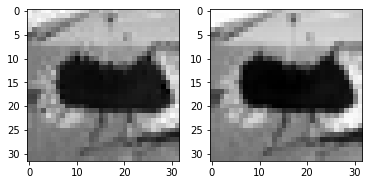

True label: 2
predicted label: 0
Time:  740.0634217262268  seconds
Initial fitness: 
 [-0.04857302378202591, -0.15528089033456205, -0.27826458136165455, -0.15941404964906158, 0.041980143679112236, -0.12102804067980932, -0.08105355376113288, 0.437397197168772, -0.09598806453546038, 0.0277206258295708, -0.19811230410309077, -0.10232951576768748, -0.10587199938361896, -0.14835651952461212, -0.3482028462158493, -0.13508219976546154, 0.06900875378779509, -0.27506000499374894, -0.009460212821220948, -0.14595006931874044, 0.16538654582225337, -0.2963121864448449, 0.06705820459887307, -0.37039929063541616, 0.1322659482917722, -0.24894576095010446, -0.2990009142433629, -0.12124320509358058, -0.3791653125908421, -0.4715560417062885, -0.3087724331016466, -0.11069716936666457, -0.13308050975794072, -0.25704933263819113, -0.19929431160646102, -0.22750826277851138, -0.15646968879604795, -0.4874247501799327, 0.03648134580702608, 0.07224842093039975, -0.0738647599512626, 0.13495898370427062, -0.091117

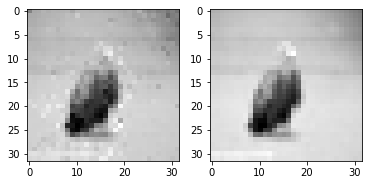

True label: 2
predicted label: 6
Time:  285.6167573928833  seconds
Initial fitness: 
 [-0.5980904594230048, -0.5913038755044662, -0.5932388850586606, -0.597242080473946, -0.5930969636863398, -0.5971054685938028, -0.5952968430527654, -0.5940656758324876, -0.5960612072884095, -0.5965979265957778, -0.597491977738945, -0.595854589688241, -0.5945959681788076, -0.595920904166376, -0.5968126072524007, -0.5966926853427718, -0.5928117916562442, -0.5968796422113293, -0.5965265630547603, -0.5955988235731894, -0.579999148067773, -0.5961873276901827, -0.5947998354932336, -0.5953457804879057, -0.5952000504626709, -0.595918726083904, -0.596487478672834, -0.5964726590212085, -0.5961296135727499, -0.5973342710891313, -0.5955840328454848, -0.5950074857318939, -0.5921230919529163, -0.5979291602629632, -0.595991772440758, -0.5896949367218379, -0.597376864965061, -0.5965090945741051, -0.5935457076866524, -0.5939759669290553, -0.5945394545541572, -0.5944476449324714, -0.5916779918290249, -0.5954247335176762

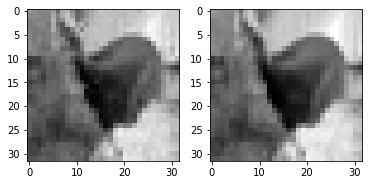

True label: 2
predicted label: 4
Time:  265.4836504459381  seconds
Initial fitness: 
 [0.017882131852055144, -0.14770650174471806, -0.061560940033207445, -0.04595978135963685, -0.17672339963934572, 0.01820004475244727, -0.17419585313865105, -0.05605364286155623, -0.04283952166874927, -0.1889519318478607, -0.048862500118489804, -0.052096478934741536, -0.08357544636118919, -0.281369975794865, -0.14999825568427033, -0.10847145774002837, -0.1078899808200025, -0.04084102628858405, -0.06439847651609829, -0.12533341235319778, -0.16814551818658846, 0.16200327228710626, -0.12733238325220703, -0.17024233962530683, -0.0323132263411674, -0.045950702844710006, -0.05642853132550696, -0.009205417786829734, -0.0836063259767324, -0.07523663157055915, -0.14360098837003593, -0.15015828519502977, -0.019735334424337864, 0.28262707266470655, -0.18109267322906952, -0.20569177539026245, -0.10703031848258321, -0.08840525965830526, -0.033124114002452076, -0.08759100825640692, -0.23726677784539202, -0.2161052249

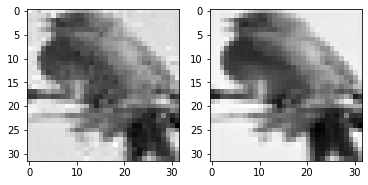

True label: 2
predicted label: 3
Time:  617.3763027191162  seconds
Initial fitness: 
 [-0.5674243098128271, -0.5817092258469421, -0.5888695822254899, -0.5931886874785165, -0.5704911220843607, -0.5718438304997053, -0.5793261560536809, -0.5826082039476254, -0.5899356360510128, -0.5858052794420491, -0.5886016526731244, -0.5847435449071665, -0.5661712290094277, -0.57992456305159, -0.5855013873987314, -0.5785954114213545, -0.5808456798794395, -0.5815412896625796, -0.5792409827925432, -0.5858601033376126, -0.5793713698672229, -0.5524012068342473, -0.5776412814245477, -0.5657421371400682, -0.5850454241128181, -0.5890550953571617, -0.5778562490187249, -0.5844409434332102, -0.5929804722178276, -0.5876556457057064, -0.5797488546145094, -0.5772998334988515, -0.572547854684338, -0.5734512097752652, -0.5876174994904835, -0.5806893591421983, -0.5798539882899527, -0.5559596278502591, -0.488988072954902, -0.5815700261097312, -0.5771222524361823, -0.5811622931793565, -0.5926100658443009, -0.58152569371

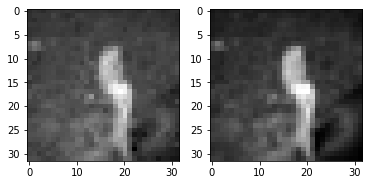

True label: 2
predicted label: 3
Time:  433.7723948955536  seconds
Initial fitness: 
 [-0.5663435702021398, -0.5587856234674015, -0.559658958146465, -0.5619799082125567, -0.5681683657186165, -0.5587634202446992, -0.5646689163839986, -0.5452601824867028, -0.5275131506529611, -0.5525530925107872, -0.5578848267575008, -0.5665012212782053, -0.5575200593094525, -0.5640289808935026, -0.5626677725593848, -0.5670846193950685, -0.5533540823663259, -0.5499802117644012, -0.5559214236936183, -0.5531936120904306, -0.5532382050952356, -0.5433718564048879, -0.5635618654692779, -0.5549483650018229, -0.5687213173722266, -0.559685355739371, -0.5712146773535505, -0.5638813304666974, -0.5428118101081376, -0.5577325677091762, -0.5534170222130594, -0.5614480969963115, -0.5621540753974061, -0.5280873751576304, -0.5514488590553623, -0.5710660371219207, -0.5547565321354292, -0.5476380347202665, -0.5687912556052654, -0.5435422226922687, -0.5595257474813349, -0.5712274707499871, -0.5724561170750836, -0.557829124

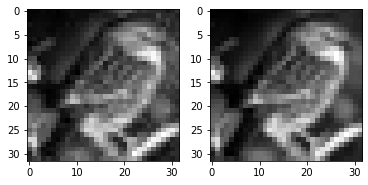

True label: 2
predicted label: 3
Time:  753.6550421714783  seconds
Initial fitness: 
 [0.8801766575550837, 0.8282384299785961, 0.9027577035171929, 0.8784969190631675, 0.9171753676080482, 0.9025131303168398, 0.8665271263951994, 0.8568721347008529, 0.8892344231216504, 0.8705448628454674, 0.8699799993341559, 0.8828871896991967, 0.9435196994964085, 0.8801602065200274, 0.8014087118489601, 0.8724917323631384, 0.9091911278302585, 0.7799300299744827, 0.8743339011712268, 0.9079423330594536, 0.8406492574711711, 0.8297080016386202, 0.8475971523692742, 0.9040639047716181, 0.900256783270692, 0.8855766528894843, 0.8859828785591175, 0.9102739430255332, 0.9018986429247531, 0.9022780627758324, 0.8492846281476737, 0.7940071996654147, 0.9168991566173927, 0.8655442040595172, 0.9015163386117482, 0.8696558505618274, 0.8434519420225943, 0.877070860598794, 0.8718489437692469, 0.817339132156265, 0.8980407158530612, 0.9530054887091074, 0.8948800286582775, 0.9098200786350753, 0.7587412210573922, 0.87388509514654

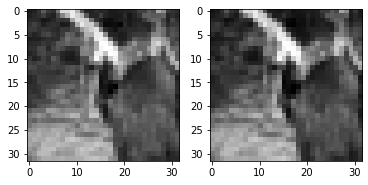

True label: 2
predicted label: 7
Time:  241.6428587436676  seconds
Initial fitness: 
 [-0.6166427753313417, -0.6148798001331113, -0.6125610049238376, -0.6166402567542341, -0.618048529226884, -0.6078879200964088, -0.6092484333287137, -0.606355423301154, -0.6183198015122986, -0.6099954104455481, -0.6134454548841649, -0.6200791626657172, -0.6011243144685761, -0.6163034519154281, -0.6316616251525479, -0.6087685769745109, -0.625974470448589, -0.6112575965725076, -0.6276738843995511, -0.6242765800844385, -0.60272908438804, -0.6081068377070105, -0.614534006562223, -0.6091131539229193, -0.6087421044796106, -0.6099002963177012, -0.6135112641691469, -0.6044010178016559, -0.6127435069828813, -0.6137596056085248, -0.6103982275595021, -0.6161380885335207, -0.6200390262386865, -0.6229955214640119, -0.6027382918093731, -0.6133717144230936, -0.6111189302269825, -0.6148139575125418, -0.6050709820442843, -0.6262025568212399, -0.6196790690484235, -0.6186774681311524, -0.6250317982434769, -0.6254548355847

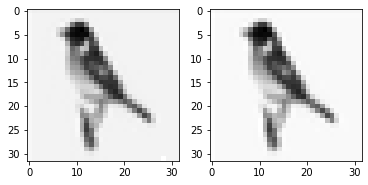

True label: 2
predicted label: 2
Time:  120.88920998573303  seconds
Initial fitness: 
 [-0.6001528132813427, -0.6002336894052812, -0.6003834600581, -0.6006081966428891, -0.6000873497555708, -0.600583338907388, -0.6000035244841115, -0.6000631953454768, -0.6004023794140616, -0.6001217487492994, -0.6003389774249784, -0.6000620987116357, -0.6000254286868392, -0.6000717991694019, -0.6002961834933369, -0.6001856032244433, -0.600026633579255, -0.6002628258900996, -0.6001636954475857, -0.600136663203856, -0.6007372866898458, -0.6001515685842959, -0.6003507512575024, -0.6003240564559373, -0.6001710965703951, -0.6000284230076534, -0.6003057458363047, -0.6002605618112098, -0.6001455049858787, -0.6003460748971172, -0.6001838801530828, -0.6002687883134645, -0.6002681241518435, -0.6000243743587423, -0.6002640759763744, -0.600183867391066, -0.6002274900061929, -0.6001323137841815, -0.6001049726097529, -0.6000975629829004, -0.6000046976876738, -0.6001049687799394, -0.6001622782996018, -0.6005205234049

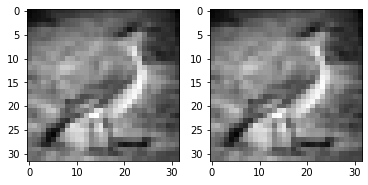

True label: 2
predicted label: 2
Time:  120.59738183021545  seconds
Initial fitness: 
 [-0.6031115102094989, -0.6033387028544147, -0.6047976511940913, -0.6013742521176122, -0.6010805006616528, -0.6002805574049906, -0.6027680374743101, -0.6007468999030697, -0.6023878973875442, -0.6010068887596576, -0.6026322626290535, -0.6007352956870278, -0.6010198699534628, -0.6016692965737647, -0.6009774671699706, -0.601168424071889, -0.6010131327686605, -0.6005648166959027, -0.605247747216974, -0.6022780198916021, -0.6018478657068732, -0.6027323443881968, -0.6011285043744763, -0.6031962466052786, -0.6020240432894749, -0.6010255346597886, -0.6011354950337482, -0.601469512820348, -0.6016955016260287, -0.6007028162834563, -0.6062800497979575, -0.6010849095388151, -0.6010414026147347, -0.6005188738714097, -0.6009382522731277, -0.6011448885280158, -0.6040020325999694, -0.6011910467699638, -0.6005333853224419, -0.6008854532663348, -0.6015906319415051, -0.6014621272895473, -0.6034980674552154, -0.601097941

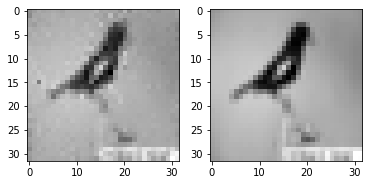

True label: 2
predicted label: 0
Time:  743.5647208690643  seconds
Initial fitness: 
 [0.9828661621816743, 0.9909476264802998, 0.9852190485849073, 0.9921221960093499, 0.963928903100775, 0.9833669476092116, 0.989208047164813, 0.9899571857937587, 0.9904286735890215, 0.9836408634193651, 0.9847976767294364, 0.9843051170506627, 0.9849780034066662, 0.9884981111048428, 0.9916862310119177, 0.9856757607410331, 0.9871721249636779, 0.9896694778623552, 0.9887126279571011, 0.9802754927744293, 0.9839007603301562, 0.987398552658376, 0.9760710520768274, 0.9916823563291932, 0.9812735218865394, 0.9895110177681345, 0.9932444064011191, 0.9903616092907731, 0.9887154984457466, 0.985236084863173, 0.9853226040122505, 0.9932015687563703, 0.9905578829891223, 0.9881606669345091, 0.9907611700698632, 0.993453664613138, 0.9759656897315112, 0.9797685242902268, 0.9872681795030105, 0.9912617843915859, 0.9936097146290446, 0.989828752202706, 0.9815373767357434, 0.9945116587624072, 0.9877010884700165, 0.9807061133426156,

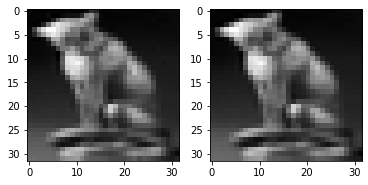

True label: 3
predicted label: 2
Time:  4.604083061218262  seconds
Initial fitness: 
 [0.32639358416320285, 0.20120661381942767, 0.26682329341692446, 0.13424226080966756, 0.2603752963185233, 0.228365751663853, 0.2799855286739255, 0.32054913078305747, 0.36457447485488104, 0.37806781473673384, 0.11843924354165711, 0.3865619186360797, 0.23837780275033388, 0.0310098491760101, 0.06784257164838844, 0.25459578836893737, 0.050820701828360654, 0.4005225409868029, 0.19018328442870158, 0.5216906656648543, 0.067868286198313, 0.2495446908503018, 0.2970020364661868, 0.23825570062528317, 0.34068542295225246, -0.20502824682401144, 0.34346696420537937, 0.4333379643746318, 0.2775312442000138, 0.3098130660997425, 0.3381000676068464, 0.3546629246289923, 0.16143114205617126, 0.33382183477178584, 0.4139212504167662, 0.5163101248116416, 0.2471263607388069, 0.2607248941397607, 0.2789743254657455, 0.48421324324647874, 0.20330740828289381, 0.249311817789835, 0.18841033538244967, 0.35191937059242406, 0.492074512

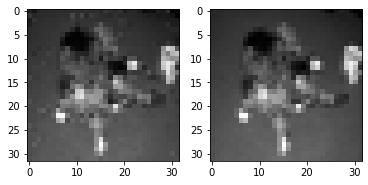

True label: 3
predicted label: 0
Time:  281.0308427810669  seconds
Initial fitness: 
 [-0.1614715246360082, -0.23898624903489557, -0.3330753343986973, -0.3244836138071393, -0.20958729863991438, -0.3496435287225881, -0.2764720619396695, -0.2406575046269117, -0.22107635294343297, -0.2718358865718215, -0.25664356523803955, -0.38973902686099327, -0.2930479239331486, -0.3275827195472523, -0.331210087971722, -0.22524093604753606, -0.2584076279029597, -0.2895195801031167, -0.31517521499291706, -0.23708041430093876, -0.3110142892518545, -0.2815020276781264, -0.3685404195749695, -0.23067737760864707, -0.2704819361447809, -0.17878628875022112, -0.23619383936829078, -0.29648364076100253, -0.26230036183189903, -0.2789089529050287, -0.21393092673533198, -0.2668121849061831, -0.22260771520974462, -0.32212323352866123, -0.2724548701287377, -0.3028326566021907, -0.24290128913263484, -0.120649321824222, -0.20683091853832086, -0.27707204345071035, -0.2955298317824698, -0.38132498733745446, -0.2948288539

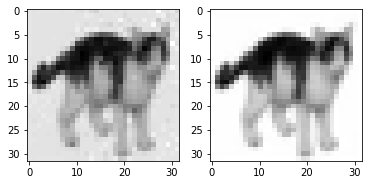

True label: 3
predicted label: 5
Time:  477.37685203552246  seconds
Initial fitness: 
 [-0.5631255267232294, -0.5583562299646809, -0.5454078998599179, -0.5704250254919809, -0.5562880783920074, -0.5626684702983429, -0.554224591700023, -0.5488110233616201, -0.5658732118794447, -0.5732509097390527, -0.5730910113206324, -0.5672599387096644, -0.5767255830230392, -0.5656837770600387, -0.5797612495249751, -0.5846692176523456, -0.5717723764142212, -0.5604532566750968, -0.5673582955573717, -0.5597419891193932, -0.5343029618889604, -0.5502402200205151, -0.5540434564850378, -0.5596974946297197, -0.5605195227583626, -0.5676820619549655, -0.5702186464420631, -0.5563108204276327, -0.5420914072364315, -0.5616914675148186, -0.5612798538635855, -0.5608843867079255, -0.5659411984510464, -0.5604946290075821, -0.564086399576617, -0.5805545055594493, -0.5754180682379122, -0.5486683266033805, -0.5403097627570743, -0.5715045861495828, -0.5682213410383135, -0.5581885375813205, -0.5683725683890487, -0.56302976

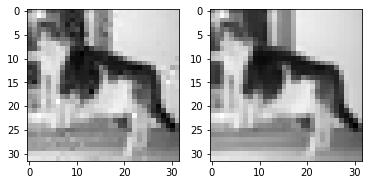

True label: 3
predicted label: 7
Time:  438.1483495235443  seconds
Initial fitness: 
 [0.611088931422678, 0.6781926062391932, 0.5097013993219496, 0.7543260586119093, 0.6923714367551648, 0.6322925131502191, 0.6522305927061607, 0.6672211716783789, 0.6637816703905225, 0.6975892771697274, 0.6669386684703843, 0.6400935639390636, 0.5901502960575532, 0.5243881700525418, 0.659919480640471, 0.5864500863033575, 0.739653946527414, 0.7877800202381704, 0.566791823381396, 0.7449213408642532, 0.6782166766674931, 0.6272638233217787, 0.7047197845769652, 0.6588613496037383, 0.5953007631624243, 0.6502440749047613, 0.6395420493432742, 0.6286108981727633, 0.616336558335739, 0.6608177203066561, 0.7300277317170121, 0.764350808861927, 0.6728957001848883, 0.6588592674849173, 0.7889065383473645, 0.7398417829357284, 0.6999829042626518, 0.7192724582621024, 0.6842575319400293, 0.6487053602283995, 0.6181629892098005, 0.6933994017004023, 0.7217346789212767, 0.7784057880433304, 0.5726039855592464, 0.6841932381475191,

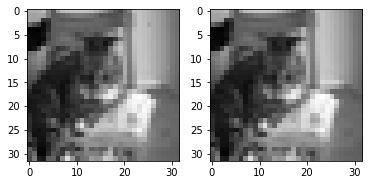

True label: 3
predicted label: 2
Time:  4.616342782974243  seconds
Initial fitness: 
 [-0.27376728178206855, -0.2992359265167037, -0.2847899816826518, -0.18965504235643302, -0.2599856530999123, -0.2350880159665049, -0.2335653560635356, -0.2847820214657859, -0.1961710435090721, -0.2880224508984057, -0.2743112583939963, -0.11672953898940952, -0.22942453368987442, -0.3440679165330981, -0.2515444021338853, -0.2580770955705275, -0.27608923153445764, -0.18664010284150834, -0.2856132871114042, -0.2775042504634979, -0.29057181958871703, -0.19696806673155387, -0.27386868400695347, -0.15519587768135512, -0.3161950685240052, -0.23742892605342159, -0.2320865553062102, -0.2056965877752438, -0.15741454362894522, -0.22856134750903187, -0.2642161201525079, -0.23629775664062758, -0.19691290905097683, -0.33723273741822823, -0.1422098521984016, -0.30277363013203734, -0.27254526281640323, -0.17697476387610067, -0.11927736639849348, -0.3536651644267943, -0.19549771000669103, -0.26349290144648807, -0.248264

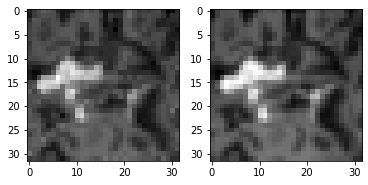

True label: 3
predicted label: 6
Time:  522.2651703357697  seconds
Initial fitness: 
 [-0.5845279957894546, -0.5756593937521194, -0.5912956485265597, -0.5876953882485346, -0.58437552058373, -0.5819476909883522, -0.5868922706687197, -0.5843980134210123, -0.5814571286155692, -0.5843537360435507, -0.5810958178225387, -0.5825904435426719, -0.5843539419249238, -0.5840252460089563, -0.5888894500284707, -0.5829721196664651, -0.5717008944839297, -0.5883615356142881, -0.5787973763420708, -0.5780136042220728, -0.5819047974878421, -0.5829657978127798, -0.5816399130764895, -0.5867473334056822, -0.5792894684976018, -0.5811684052404609, -0.5890922748440446, -0.5861001671527207, -0.5896840601089173, -0.5846747445900007, -0.5803776532236109, -0.5870255797723646, -0.593272866207285, -0.5843869126419774, -0.5882479683196956, -0.5866240389320354, -0.5783701878557167, -0.5825545607940577, -0.5787766139907059, -0.5860408555937684, -0.5898695971639945, -0.5834750387678116, -0.5862909747573305, -0.5790635450

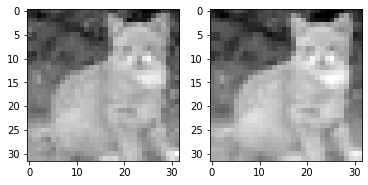

True label: 3
predicted label: 5
Time:  494.56163454055786  seconds
Initial fitness: 
 [-0.23270949980504196, -0.1862988249584874, -0.398906967410958, -0.23860458645650884, -0.27904372222783025, -0.40378595365705555, -0.3543894070697835, -0.3384065881645474, -0.3481846117348165, -0.37584967769830135, -0.42964377675027854, -0.31693552864234975, -0.3215533482112297, -0.3244620576939271, -0.3431884456919414, -0.4078179902157618, -0.3822227922391695, -0.29336446423267076, -0.3066572343147308, -0.18527374994058327, -0.33858120396130786, -0.3989539583560363, -0.14430292887363808, -0.3292744717153062, -0.3207271635306215, -0.23230284404818685, -0.3981631071010021, -0.3600522131626544, -0.40816890492297575, -0.258726902509816, -0.3567722268107759, -0.2935807922746325, -0.2572715346213015, -0.3928701616214578, -0.03503664865511158, -0.22789966114070062, -0.241769507958822, -0.2614603799643186, -0.4018649869664452, -0.3242206007468566, -0.33260820569180516, -0.349385030632956, -0.294906104376657

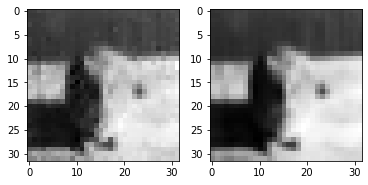

True label: 3
predicted label: 7
Time:  756.1548659801483  seconds
Initial fitness: 
 [-0.5802502061499919, -0.5828312914473561, -0.5522987055386867, -0.5575797364910209, -0.594085972040646, -0.586023401989874, -0.576871854755715, -0.5767063441812953, -0.5860820167733097, -0.5941610604783711, -0.5746291298117188, -0.5795899556412186, -0.5805929164793622, -0.5924458516237359, -0.5919564754864675, -0.5702067173620915, -0.582285635123766, -0.5879505367848942, -0.5738928429395292, -0.5831356903185931, -0.5802440847854582, -0.5785475575476946, -0.5964729932241541, -0.5652417611197555, -0.5858109383357704, -0.5800415916966867, -0.582638329562233, -0.5802441074855655, -0.5832366934296322, -0.5829115786803639, -0.5833551373185212, -0.5923115377899186, -0.5825109806475331, -0.5906859657462147, -0.5914899938659111, -0.5630576507654054, -0.5841745976712835, -0.5878547953311313, -0.5891522008186945, -0.5828689327698189, -0.5847470725737793, -0.5847050996519711, -0.5829612105994192, -0.584465984010

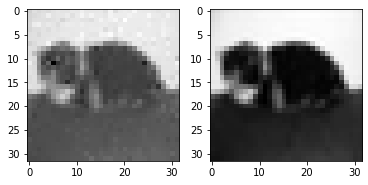

True label: 3
predicted label: 5
Time:  399.29426741600037  seconds
Initial fitness: 
 [-0.5517819730036656, -0.516520141075648, -0.5294189764954547, -0.5488556757313243, -0.5381019481990479, -0.5397373549585617, -0.5339542933768044, -0.529638551878229, -0.5343902569001906, -0.5497568492175369, -0.5185634580382097, -0.544474723564869, -0.5442223838342765, -0.5715223776519068, -0.50645797766498, -0.5506222821872109, -0.5426593566286485, -0.5238997920128691, -0.5645691670682293, -0.5401852135997658, -0.5471419347355111, -0.569528730186033, -0.5440427153863399, -0.5678239507062668, -0.53197547697688, -0.5292458921094374, -0.5529996657753743, -0.5450554853142512, -0.538436872217029, -0.5257119817928815, -0.5453805528456137, -0.5466323715807891, -0.5619476103479218, -0.545488917134074, -0.5003314354293458, -0.5186699197691506, -0.5536571651553678, -0.5489249097383878, -0.5562418707842635, -0.5581833809601754, -0.5552603144004733, -0.54550034002205, -0.5450503222562104, -0.5594674086203562, 

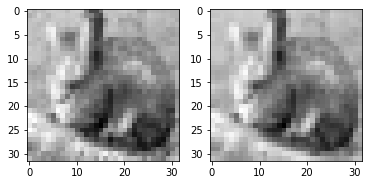

True label: 3
predicted label: 2
Time:  748.0922956466675  seconds
Initial fitness: 
 [-0.5251799746324118, -0.5060481965193542, -0.4963264536892813, -0.5197183182376323, -0.5179290286590594, -0.5110396755887815, -0.4900939701760248, -0.4977668510333149, -0.4855737107374793, -0.5297402547630448, -0.5326423661132574, -0.46413337872325033, -0.5406457744147, -0.5111803167101211, -0.5156298295802977, -0.49756678444432295, -0.5307541107492946, -0.5336058072570762, -0.5294413656029164, -0.5231548304060814, -0.5158643649538697, -0.5070720033739742, -0.5225478324406949, -0.5318977177515465, -0.46822849017439583, -0.5391251777000665, -0.5124915855921202, -0.5073827227737048, -0.5038899498151221, -0.48688288904125937, -0.49927570846511715, -0.48894608212112645, -0.5228213383346687, -0.48434039687263875, -0.5214605065865744, -0.5139909579069093, -0.5305778058130413, -0.47233772304553656, -0.5630547301763672, -0.5401598294953023, -0.5421784830822962, -0.5367359375477334, -0.5487195797626276, -0.49

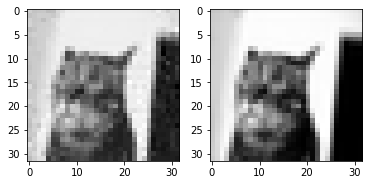

True label: 3
predicted label: 7
Time:  594.2664461135864  seconds
Initial fitness: 
 [0.6728651411508115, 0.7404344612071201, 0.7010134916768923, 0.6948247369146368, 0.6380767006302113, 0.679401008198302, 0.6601882101191949, 0.6059910520682388, 0.7139478475558309, 0.8719831729437534, 0.6928113013215806, 0.7594172419457699, 0.7162374818598056, 0.6107100961398719, 0.656721657229246, 0.5357430678037515, 0.7239247436851316, 0.666846564591378, 0.6528685382600499, 0.6485682262925422, 0.767932780461716, 0.7594476080490563, 0.6243201267901686, 0.6337630540050043, 0.6841957072510958, 0.7522687488131335, 0.6911271401918285, 0.6124958542277098, 0.5607950865471778, 0.6133804244349037, 0.6268017011555458, 0.6392172638402217, 0.6226631465869464, 0.6981189755928644, 0.671636710187265, 0.7309125324732109, 0.7126394159813595, 0.6573113954742478, 0.7649721309489229, 0.6444057595756444, 0.670283196190422, 0.6767915355743893, 0.5782666966024794, 0.7116967273504865, 0.6676606293586789, 0.5990998101567258,

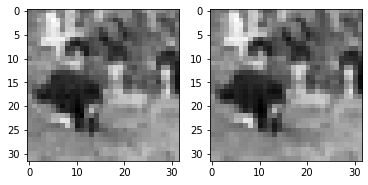

True label: 3
predicted label: 2
Time:  272.54330015182495  seconds
Initial fitness: 
 [0.449755978528597, 0.3464505473136849, 0.2988424049446065, 0.2438638284581668, 0.28085999028006353, 0.31983010412424556, 0.2677077771427121, 0.34769779103861054, 0.5342886598866254, 0.24922559142456716, 0.2996986202410177, 0.29071161041617366, 0.32261206310905144, 0.33005314863021495, 0.39941858734834423, 0.45500122233018764, 0.28834954768677784, 0.37823356338252684, 0.29626361621666264, 0.28795606889832426, 0.44881281828539077, 0.43577190600384447, 0.4347039893934569, 0.37614837924187344, 0.2966490839778993, 0.3630935810660572, 0.36538086737899156, 0.2092319679763125, 0.3620599033176167, 0.37760802492230156, 0.31436519249601136, 0.34105944411972866, 0.2378556815816828, 0.34395070597173794, 0.24045557695107317, 0.3301416048125667, 0.3340980141484189, 0.28537165490324123, 0.33489115311080453, 0.3541586063513927, 0.33032142964870725, 0.30072050066064593, 0.5178324907623175, 0.3812554127932102, 0.34401

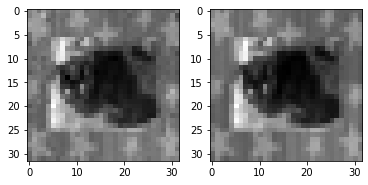

True label: 3
predicted label: 5
Time:  412.5110855102539  seconds
Initial fitness: 
 [-0.6000713117307079, -0.6000976772022579, -0.6001211200904383, -0.6003828554842497, -0.6001553720897853, -0.6000486143777041, -0.600056556256115, -0.6004762480933521, -0.6000350551275178, -0.6001767389769563, -0.6000702260693713, -0.6001978078140185, -0.6001469597431396, -0.6003088763615151, -0.6004895236345028, -0.6000240191858768, -0.6003646986421687, -0.6001781514510726, -0.6003161309239443, -0.6002282550793341, -0.6001836478951591, -0.600071973848023, -0.6002965474772933, -0.6000711065494295, -0.6003227556375976, -0.6001612846814357, -0.6000082922534472, -0.6000138285370133, -0.6000401131096714, -0.6001323308768965, -0.6004339160465071, -0.600037308437339, -0.6002952244653762, -0.6002665298826527, -0.6001272313541223, -0.6000597091808528, -0.6000952862679085, -0.6001758574110615, -0.6002285324465831, -0.600173139943984, -0.6001349871389043, -0.6001670336723541, -0.6001347878738411, -0.60003932602

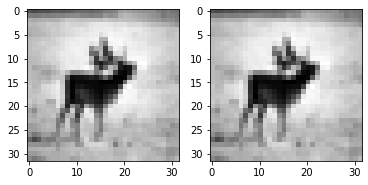

True label: 4
predicted label: 4
Time:  121.3574047088623  seconds
Initial fitness: 
 [0.5890440420400276, 0.5984265661796684, 0.6717988098136304, 0.34467239867987726, 0.6857987901838694, 0.5909866770197685, 0.6088215224268602, 0.7353169306448363, 0.6600842684141207, 0.6574400336368492, 0.5982570648054996, 0.6432424165212423, 0.6621545429154605, 0.566669901381487, 0.7456553529934106, 0.5421167984814568, 0.46995608315272175, 0.7311899339233856, 0.7011042445581063, 0.6502337875661051, 0.5930705526080526, 0.7580181188590924, 0.7557487391150131, 0.40832996176411385, 0.6816061331169578, 0.5208558736001849, 0.5506659172966198, 0.6768582810423371, 0.48405841379982606, 0.4709777344307182, 0.5677910751965451, 0.6661473613935647, 0.6368435284973457, 0.6642625555741835, 0.6130475234500863, 0.7372323906842391, 0.6371238933373871, 0.6831104184148342, 0.6288498264094602, 0.7309021339515377, 0.739609788870631, 0.6622052366468126, 0.5149943569932935, 0.6466647494276028, 0.6672318322329037, 0.683349586

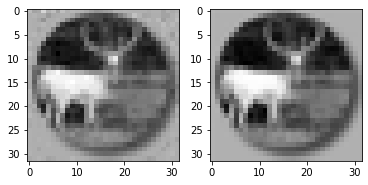

True label: 4
predicted label: 1
Time:  459.90539479255676  seconds
Initial fitness: 
 [-0.4543366019709255, -0.4787904280520586, -0.4295973868987786, -0.4791776805069428, -0.43249325803908034, -0.4736233928575374, -0.4753667430235631, -0.5098084200702084, -0.4688866394116071, -0.4577173978908811, -0.4992328052177285, -0.4217719037268182, -0.47391118767704177, -0.4299512302329741, -0.4903671411440843, -0.4349332637594947, -0.42376660704879865, -0.4201137139240092, -0.4254056476228866, -0.5100873163078362, -0.3978436370602738, -0.511614413237906, -0.5234712479268757, -0.4831911293700317, -0.4232854400388151, -0.48297992980638665, -0.4900930125187576, -0.5172050421890798, -0.47237115874883623, -0.3840360813860837, -0.3697986940007463, -0.4750098313320398, -0.38311872146777914, -0.4788282472385292, -0.46478376426052914, -0.4938486239198952, -0.4528470019652196, -0.43775849430903374, -0.43617227238647455, -0.4527429801098274, -0.39095872048940705, -0.41687666885100116, -0.4722363657839834,

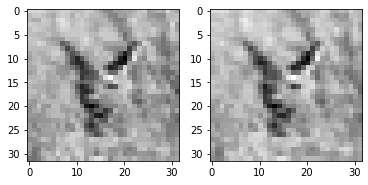

True label: 4
predicted label: 2
Time:  447.74827814102173  seconds
Initial fitness: 
 [-0.5945276555320715, -0.5939105730463069, -0.5951861421210943, -0.5963939459485665, -0.5966116540867752, -0.5941318543511841, -0.5912330031176032, -0.5902382780069267, -0.5968202783632606, -0.5932912264105931, -0.589855487875232, -0.597795917862312, -0.5887919363865742, -0.5948075624335866, -0.5904429057877209, -0.5975668247318376, -0.5934740316508269, -0.5908445934999764, -0.583590662074392, -0.5940960181609354, -0.5931160765346308, -0.5927034879147772, -0.5950946928021597, -0.5915635072552969, -0.5950590664802293, -0.5948561153233811, -0.5933288338907445, -0.5934247202543019, -0.5916514298217417, -0.5935757886335574, -0.5918985459752613, -0.5940893667773762, -0.5946351972998556, -0.5924699365217718, -0.5932870942337383, -0.589939326578558, -0.5930794911711794, -0.5921650427022442, -0.5926209647211474, -0.5874037588312171, -0.5965739324415295, -0.5921398078468045, -0.589503398628753, -0.59226428556

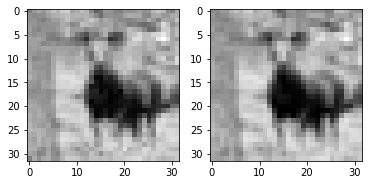

True label: 4
predicted label: 7
Time:  437.1187081336975  seconds
Initial fitness: 
 [-0.47204781942906693, -0.5529112479039537, -0.5388744981293554, -0.2736097308835256, -0.4809187614503385, -0.5509818464057771, -0.48512472361017955, -0.5095956532560151, -0.5141331707724895, -0.5399372232337223, -0.4099610598695388, -0.5375451463954133, -0.5382501762194567, -0.48237725063719994, -0.5211312124838858, -0.5459331233972321, -0.5159523206936336, -0.5092664195065857, -0.5286306436839108, -0.5313884383951454, -0.5303041819179485, -0.38334176662915287, -0.5724304793506133, -0.3136830713180601, -0.5009963766173139, -0.5473793456898175, -0.48364454481532737, -0.5725556416156616, -0.5181885424993918, -0.5314327015279638, -0.5065401533838748, -0.4805222942195584, -0.4901735276393214, -0.5326971224856981, -0.5366807734924061, -0.5564732736070404, -0.5371082641456658, -0.5697662732949234, -0.5101381785677772, -0.5388925440120561, -0.5413459231755191, -0.5328109927246115, -0.5292318010629357, -0.52

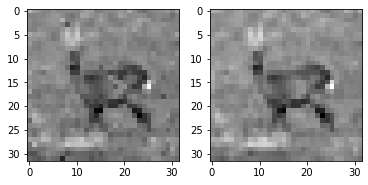

True label: 4
predicted label: 2
Time:  201.89309334754944  seconds
Initial fitness: 
 [-0.5948947697874889, -0.5960631799315492, -0.5956677185816399, -0.5966068837202773, -0.593343146835966, -0.589820254147377, -0.5980124213819307, -0.5940364344809886, -0.594693165902609, -0.5970195419472251, -0.5925284344169284, -0.5955811065785053, -0.58196004289909, -0.5988648523694518, -0.593952410845967, -0.5962706642878066, -0.5936482014131036, -0.5881097544206797, -0.5952787733182321, -0.5907065352867482, -0.5949557889259851, -0.5935228464712714, -0.5933479049467119, -0.5956236567478717, -0.596605113464526, -0.5957290583231356, -0.5983689906938499, -0.5919255990544843, -0.5937812995182907, -0.5924379624554714, -0.5971870567174251, -0.5942131844526484, -0.5743630830203359, -0.5932615024459609, -0.5954990720467268, -0.5879105531937048, -0.5903894428268617, -0.5949675512855062, -0.5975997254439176, -0.5814397144095484, -0.5942311953770308, -0.594362253500016, -0.595889233967485, -0.596369203393869

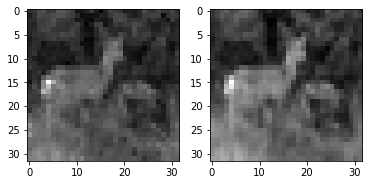

True label: 4
predicted label: 2
Time:  332.7407591342926  seconds
Initial fitness: 
 [0.36242687832189807, 0.3199577812646817, 0.013020338292983213, 0.5208822062362333, 0.1559404433071398, 0.4026531779539532, -0.05948483125141055, 0.1470694562612487, 0.3915644951285995, 0.36025362261745464, 0.399248915917095, 0.28836481695764205, 0.4405075536603805, 0.10221205053108245, 0.3126874670994176, 0.3411779448271688, 0.29043681591587867, 0.03600208016978376, 0.16200493994496432, 0.26888852907223726, 0.35334600674968586, 0.24093311812548532, 0.2954720744076845, 0.03559814468543898, 0.45323800167120953, 0.4446847429745042, 0.302681350685613, 0.3057636585836182, 0.057638150704921315, 0.2484952644580166, 0.46346329914320206, 0.1952064105104822, 0.11782724648447948, 0.23349436310569252, 0.3977223864440447, 0.33862406006182855, 0.48028631536350885, 0.4054660710624588, 0.20288090538120523, 0.3055798700698169, 0.4151692338543387, 0.561888265457716, 0.16145682812739467, 0.22266317760716148, 0.34124083

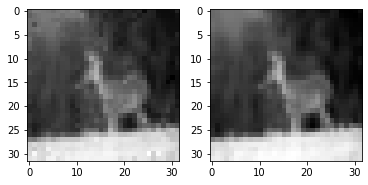

True label: 4
predicted label: 3
Time:  339.3449342250824  seconds
Initial fitness: 
 [0.9938776597853594, 0.9961808664372308, 0.9955515459036729, 0.9968202977270393, 0.9966727890375481, 0.9958624681890377, 0.9968530608026077, 0.9956124786207352, 0.9941521661421181, 0.9944415410317322, 0.9942840599715177, 0.9974524768886794, 0.9959626828968628, 0.9958798870440873, 0.9970709697996082, 0.996420869442213, 0.9941279300208563, 0.9941502154098483, 0.9958295732869182, 0.9941276246317737, 0.9966087533216188, 0.9955700719344482, 0.995750652916516, 0.9971399016007769, 0.9963273265624453, 0.9910333781940512, 0.9955754678387356, 0.9950733713570832, 0.9967798095458004, 0.9956400582577917, 0.9956749764730735, 0.995010829561799, 0.9952851382703877, 0.9961618833727053, 0.993614045998728, 0.9929129775030481, 0.9965528217979094, 0.995856035347386, 0.9958224495824421, 0.995938274412207, 0.9940340174938211, 0.9954264409158176, 0.9945886012844452, 0.9959889117025824, 0.9946655057389774, 0.9967590322093889,

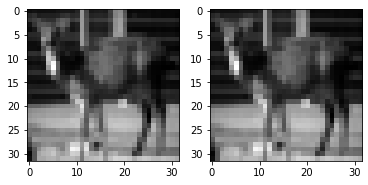

True label: 4
predicted label: 7
Time:  4.704914093017578  seconds
Initial fitness: 
 [-0.5597668095008291, -0.5682465860706698, -0.5726029412509288, -0.557885427747303, -0.5462511534467867, -0.5673844382258378, -0.5762001935496666, -0.5577040084708142, -0.5650889627415285, -0.5658511074733434, -0.5675650804052554, -0.5750776813251517, -0.5833802004106166, -0.5721814490739179, -0.5783882235274674, -0.5673880590442423, -0.5583512558621723, -0.5697807490882816, -0.5797103769988423, -0.5643341427692423, -0.5505552580412157, -0.5765616212090144, -0.5671758807908972, -0.5589579031864995, -0.5686375956120729, -0.5718484734576847, -0.5651242335682332, -0.5765745504690558, -0.5689327704678476, -0.5755901497626574, -0.5579524749238193, -0.5674852763288337, -0.5503914526385218, -0.5751973344439913, -0.5471070060945935, -0.5654054511798609, -0.5655528685777285, -0.5684072949629182, -0.5785911363215878, -0.5631788992332304, -0.5738230002761536, -0.5693429832496719, -0.5719371713791606, -0.56056044

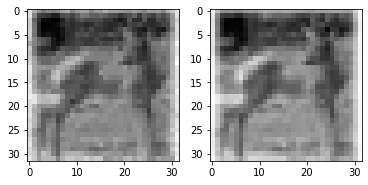

True label: 4
predicted label: 2
Time:  811.5006511211395  seconds
Initial fitness: 
 [-0.592751751730259, -0.594103633254009, -0.5939132082924741, -0.5949252605893908, -0.5931016064394972, -0.5961785100304573, -0.5953261302788098, -0.5896146169128773, -0.5942446185286915, -0.5955806699404456, -0.5927747015139481, -0.5917640916504401, -0.5925641254085383, -0.5920598079435467, -0.5971558641081433, -0.5909689903250723, -0.5938538833481992, -0.5923889770280406, -0.5885503038410221, -0.592710447497838, -0.5942656799759025, -0.592283244216763, -0.5907013634053773, -0.5912935456385812, -0.5884467047460864, -0.5935513380921424, -0.5931012184196847, -0.5924340872483732, -0.5928183847087573, -0.5948227173612091, -0.5913337671413432, -0.5938789065156123, -0.5927664212485935, -0.5963703763031354, -0.5938124039255992, -0.5943092775535794, -0.5921007218696293, -0.5935609335025114, -0.5918816848544178, -0.5915143311339843, -0.5930067045888036, -0.5919515989440457, -0.5930459454285949, -0.59394484915

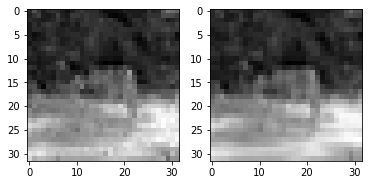

True label: 4
predicted label: 2
Time:  594.8326683044434  seconds
Initial fitness: 
 [-0.10862361782929247, -0.17092708890663283, -0.05046235484064593, -0.12717287132969052, -0.0675975396155847, 0.10860384460863515, -0.007947702782498733, 0.006595588129059693, -0.01905194183255285, 0.026183396820223193, -0.049548153965588954, -0.22716739216390192, -0.18284877096192848, -0.17111399936642419, -0.019423632328056772, -0.0013523455976141574, -0.01717332322786086, -0.28624313950343044, -0.05629608842934586, -0.27656642085873, -0.16764628954536062, -0.09476766640291034, -0.10968615427246547, -0.23570638456860374, 0.03425289316339131, -0.07051422923987269, -0.06083368353247534, -0.035082359917907396, -0.13790790336735703, 0.05176143333605371, -0.20296527068867964, -0.3769418772951526, -0.20490063283624688, -0.12368989465228364, -0.05366713244723054, 0.051123010181176015, -0.13266031147217458, -0.13056749296030482, -0.15777497729760406, -0.018215990271062105, -0.31429818286840927, 0.0670864811

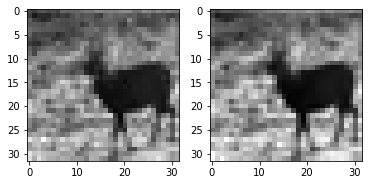

True label: 4
predicted label: 2
Time:  412.8456733226776  seconds
Initial fitness: 
 [-0.5966217253624547, -0.5951300599709823, -0.5950681450111109, -0.5935462722979227, -0.5913474945868953, -0.59853725464151, -0.5945703867896484, -0.5972063688364097, -0.594625391898197, -0.5970622048452143, -0.5930153597042168, -0.5930071652744251, -0.5961891753530209, -0.5978569723916489, -0.5917201810155482, -0.5983509325943964, -0.5941323938597196, -0.5961389202945302, -0.5956269230230515, -0.5930172552399104, -0.5935716491830145, -0.5939844281740247, -0.5966259105985066, -0.5955135505185776, -0.5906955869623838, -0.5942478041233976, -0.5964825866197702, -0.5925375188239272, -0.5929370032864555, -0.5969093153759972, -0.594465866308608, -0.5934342302336519, -0.5957212308009595, -0.5955216705582683, -0.59642514574788, -0.5909877182104725, -0.5977312963000003, -0.5962831589090052, -0.596250146366555, -0.5940221221527822, -0.5945513765725247, -0.5944901544908183, -0.5975490346315949, -0.59503929697530

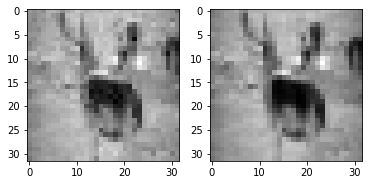

True label: 4
predicted label: 2
Time:  430.76894760131836  seconds
Initial fitness: 
 [0.39208317810659665, 0.4175910825769722, 0.3919601383333372, 0.3950808286913874, 0.2686769023124953, 0.3158483147252866, 0.4456810854103737, 0.36415684124562214, 0.4288021220373238, 0.41767891264108875, 0.4800097270388991, 0.31142990979687923, 0.5452327831019428, 0.31238443852900216, 0.43508695652630464, 0.41441979819053454, 0.3280881402454379, 0.47545740628458905, 0.347381435474903, 0.3236926930999324, 0.5173079592922079, 0.3954443775836748, 0.39576342720225677, 0.2137188610748954, 0.37774530169368914, 0.3759930565969174, 0.4868642383338999, 0.33120572068814114, 0.4550169504661402, 0.38879869512183324, 0.3445705690206352, 0.4363227666343181, 0.37797341024391073, 0.3312749507889017, 0.42718514924489026, 0.42218201246878906, 0.4566216703295136, 0.2643070619652381, 0.507696284444763, 0.32017580156731096, 0.42004329701227106, 0.37510875565642077, 0.44306290314888075, 0.3598601533424667, 0.4508750165034

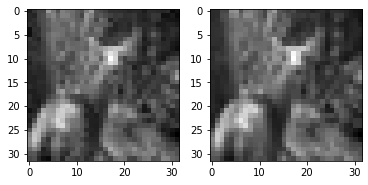

True label: 4
predicted label: 3
Time:  704.243759393692  seconds
Initial fitness: 
 [-0.2848716755433599, -0.25263517231458305, -0.4323396407816261, -0.35611358625879586, -0.24268613470548883, 0.0010820332733194327, 0.20475165350967728, -0.23880877928374217, -0.15370394414487568, -0.15271204292571247, -0.04960399826053691, -0.24634218286700327, -0.2756477071711698, -0.09369782801524573, -0.2908220994498416, -0.37324031817075776, 0.09396147810417291, -0.26509136577677817, -0.2120233174348345, -0.4231934212788805, -0.031072717272573658, -0.17490045527590953, -0.250621126856048, -0.19059884565989407, -0.20631588520911365, -0.2114391854889648, -0.08639932289519461, -0.16741668503898277, -0.21917570393267002, -0.11771886374335427, -0.3264206302405488, -0.18851576307460996, -0.2802528194518523, -0.42506027525454004, 0.2918075881272034, -0.31854543992110296, -0.28727218003224314, -0.11380530020235902, -0.10908932185716402, -0.15333752377615997, -0.19999330944575083, -0.34695310328309675, -0.

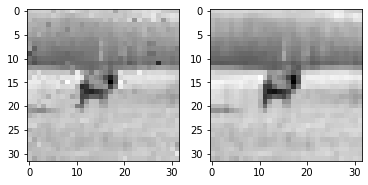

True label: 4
predicted label: 0
Time:  295.7421987056732  seconds
Initial fitness: 
 [-0.2123027588304621, -0.1089049808003387, 0.11575794110191762, 0.0918285018268405, -0.10098857073092049, -0.07371435483170147, -0.10632840763318574, -0.026037192453357977, 0.1558516130807213, -0.1197188096431844, -0.03978948793278439, 0.13478570263128187, -0.05065926656174011, -0.17130243768790904, -0.19517682709448037, 0.03808739441314449, -0.10326359631701507, -0.28838323183539927, -0.2018949392495885, -0.12031542928914277, 0.005504120374581506, -0.18599626161703262, -0.29497393518195325, -0.3069533568134427, 0.4218952202791003, -0.04280253467928785, -0.17905518488461517, -0.33440917975620754, 0.05395723681419981, -0.1672372782949714, -0.19857466260956552, -0.21959738954475538, 0.11562218092540566, -0.039543926906325744, -0.27549181279515617, -0.06773287885501672, -0.21247284117294463, 0.24342710616679689, -0.0016856344367907894, 0.04262996361557561, -0.05742212346909695, -0.2325370663985484, -0.07

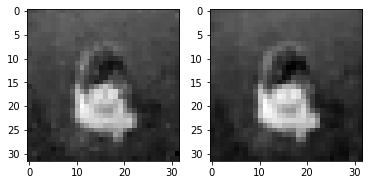

True label: 5
predicted label: 3
Time:  303.6390323638916  seconds
Initial fitness: 
 [-0.588109270852213, -0.5831541377238074, -0.5858414375712836, -0.5894692128740794, -0.5841726812486331, -0.584058938172175, -0.5782933125267988, -0.5897906282026222, -0.5870681373416319, -0.5825633778667536, -0.5869611969142903, -0.5898439999081584, -0.5815913215790955, -0.5865900582366067, -0.5856797123328662, -0.5865436525381069, -0.5831542603936918, -0.5847589260184592, -0.5870824584735986, -0.584144559347399, -0.5762898986235515, -0.587330414057959, -0.5881886912510292, -0.5914042831365018, -0.5843962583451737, -0.5871786747974108, -0.5896325850645907, -0.584950852881895, -0.5804869735651887, -0.5841349423411063, -0.5849546802775512, -0.5874654019053918, -0.5795962721599129, -0.5867974783293486, -0.5864073044485778, -0.5903408301467602, -0.5869483253338985, -0.5891726944333021, -0.5889524079397332, -0.5836914899714887, -0.5857118957083441, -0.5871788886414696, -0.5920978215552787, -0.587220196569

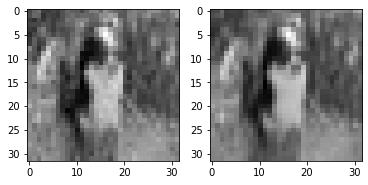

True label: 5
predicted label: 2
Time:  877.2170062065125  seconds
Initial fitness: 
 [-0.4898988846934994, -0.3723142629061348, -0.5127558127171908, -0.44873860980546276, -0.5161784607369375, -0.518820894315621, -0.48880748047422057, -0.42839965962254967, -0.4398316735605314, -0.31403379641921203, -0.548834402800317, -0.47909818450634, -0.4384497556390333, -0.34893319625965263, -0.4839482539230387, -0.34518206638836857, -0.49343915128564564, -0.3958682502742908, -0.47069832496754327, -0.49295085642128406, -0.35820644631419507, -0.525459841796252, -0.47846986715282225, -0.38335431542613885, -0.3981915282305123, -0.4824284616762218, -0.5164061082447107, -0.4883162704226336, -0.3790202853864879, -0.3556557841042842, -0.4236663858357348, -0.4322711048901424, -0.4579535627353376, -0.41590840341017665, -0.5046798082910829, -0.3709918072257253, -0.44265479044460543, -0.3980601026127454, -0.43221775564549747, -0.43768173300727564, -0.4459604972078145, -0.3019398608123407, -0.4331531927112262,

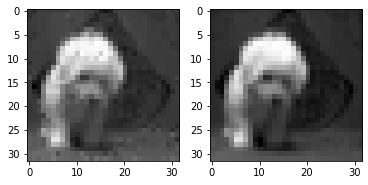

True label: 5
predicted label: 2
Time:  292.4041826725006  seconds
Initial fitness: 
 [-0.5855426890137776, -0.5810582711236898, -0.579920982704453, -0.5857302560904847, -0.5639059562959455, -0.5781619293599602, -0.5845411569749873, -0.5836383225865223, -0.5843544072253559, -0.5758305588895761, -0.5869181853240755, -0.5787026296802809, -0.5777148770614767, -0.5810405123302581, -0.5813061100231818, -0.5758815095675935, -0.5776518591940298, -0.5828896123049295, -0.5517059966217461, -0.5896718739868647, -0.588206055237168, -0.5828906310238214, -0.5789687112445979, -0.5765463850102404, -0.5853695623763501, -0.5846535624486622, -0.5837112005077005, -0.5825072045205443, -0.5863017585392614, -0.5934595625245161, -0.5856265782516171, -0.5764647055043641, -0.583098824600804, -0.586517851364267, -0.5761313543666217, -0.5874291640986755, -0.5853217697106502, -0.5696135252936029, -0.5843035676195337, -0.5827603818093325, -0.559812427199279, -0.5813591227263695, -0.5672061382308727, -0.586423014325

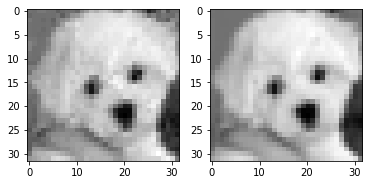

True label: 5
predicted label: 3
Time:  759.8882727622986  seconds
Initial fitness: 
 [0.392999252400065, 0.12464920218536672, -0.05826525476772321, 0.06547218000531732, -0.12355620252377594, 0.062290062715993105, 0.26634878215746893, 0.002551843828622613, 0.5375887362156969, 0.3681403196435512, 0.31996999841022145, 0.36616583542436965, 0.04270968378921769, 0.1678731436150871, 0.13798812410154918, 0.37066397274635315, 0.07440247702940633, 0.37746864479913284, 0.18238268395963048, 0.28307792612772725, -0.017827223226846572, 0.08878872937316393, 0.02889323754241588, -0.1758356213622408, 0.05725740339775012, 0.09700059327665735, -0.025454626374440903, 0.20968443867131037, 0.02256412758768017, 0.0675544758782029, 0.06111076110636329, 0.0659628396413022, 0.23721606393246844, 0.0698975213700345, 0.1853544891913798, 0.10651654980918135, 0.08981894355517946, 0.0026657016223579355, 0.3035609784319642, 0.19716894817859523, 0.19222881164404387, 0.1341709379508901, 0.17038768157669282, 0.376875625

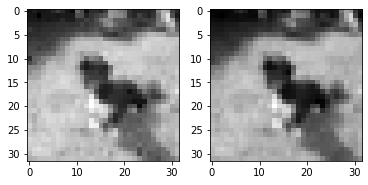

True label: 5
predicted label: 2
Time:  303.7205057144165  seconds
Initial fitness: 
 [-0.02989941507902527, -0.17313662950506847, -0.20577812180790803, -0.0699961749201655, 0.032359580384334646, -0.11250503581867816, 0.04246607423331422, -0.17979465940534145, -0.0821200486629606, -0.05487203731500462, -0.1434632004757252, -0.25998490666028506, 0.00991115847282828, -0.1302658705079275, 0.04340883974718221, -0.16569004124927672, 0.042458188798112306, -0.14560088082695008, -0.1568701873823734, -0.09757197849607044, -0.09493552457725651, -0.1886407848269205, -0.12834993156272553, -0.22236032858645777, -0.030520668273111007, -0.0894459248587848, -0.05615670274885959, 0.046043045963166884, -0.08759037951620835, -0.03083571870542451, -0.27284724177521963, 0.013068128973265258, -0.18220995593897785, -0.09464319694933554, -0.07155380764761587, -0.0031938916857450483, -0.22666419238882665, -0.08068656949661479, -0.11862997221569385, 0.048223480938466456, 0.08652921972532139, -0.080300669673917,

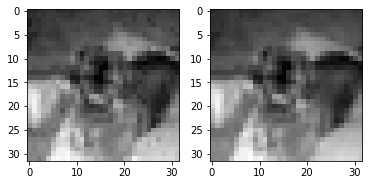

True label: 5
predicted label: 6
Time:  8764.866561174393  seconds
Initial fitness: 
 [-0.5986782862170648, -0.5993946288152151, -0.5999515482346804, -0.5987514957200257, -0.5990503740724741, -0.5989631577023428, -0.5980830517366148, -0.5983571493571833, -0.6012768176615093, -0.5978926582842783, -0.6016152818726573, -0.5988008861410532, -0.5989635328111531, -0.599201762234749, -0.5983255396060679, -0.6030105314620624, -0.6000292929948076, -0.6005462831845556, -0.5984692504938819, -0.5999171931225573, -0.5995808704688315, -0.599063392647843, -0.5988393620760598, -0.5992031419899635, -0.5988760998444264, -0.5986653299825723, -0.600100554440333, -0.5993421066646624, -0.5985753618699413, -0.5983001446237732, -0.5983725144994483, -0.600823485930201, -0.5989186330887412, -0.5996690718911107, -0.6004885770585158, -0.5991898886137015, -0.6000111947517195, -0.5994371466746187, -0.5986748186997236, -0.6003488991208892, -0.5986309104539572, -0.6003106857399331, -0.598983237253403, -0.598270981649

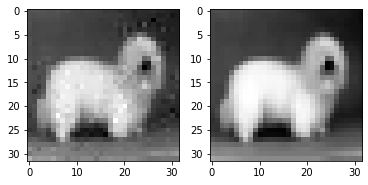

True label: 5
predicted label: 3
Time:  561.7699382305145  seconds
Initial fitness: 
 [0.7738929954864024, 0.8073172489371934, 0.7101504675171975, 0.6883836941374999, 0.7329586121289643, 0.6673227251222313, 0.7208514294063466, 0.6429938476304495, 0.8058483236327627, 0.7136534505866299, 0.7458146819885392, 0.7940512328182487, 0.6858747502385316, 0.7479567352013641, 0.6547957694434057, 0.731617253095115, 0.7503455047951133, 0.7305061364918124, 0.6617997203105692, 0.7633791102176777, 0.6910389404667681, 0.685797586493011, 0.737400432443074, 0.725078550314607, 0.6993475936743319, 0.7544026962713591, 0.7249261005182179, 0.7578452889056277, 0.7988178438715021, 0.7416840640219232, 0.7084466381821324, 0.7458112173480783, 0.7170701447450765, 0.7213258184117212, 0.7217065648315396, 0.7254115102870374, 0.7150721901305641, 0.6738882639505255, 0.6900383086892465, 0.743941653890012, 0.7741813112375094, 0.7609266086983129, 0.5969183492494126, 0.7236187710736515, 0.7483138243976334, 0.7077432427036745

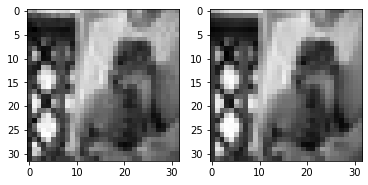

True label: 5
predicted label: 3
Time:  1216.8112902641296  seconds
Initial fitness: 
 [-0.3544807821685917, -0.2954854119014746, -0.32582175160605875, -0.3833131104203366, -0.39502392024453226, -0.36554899472560654, -0.33148093961052527, -0.30715664072020343, -0.35052688861808845, -0.2706721157084356, -0.31462198837264294, -0.28784742291062726, -0.35470906901047017, -0.30853155900942786, -0.3362463998983072, -0.32602649511427895, -0.33379415525544, -0.25479048314345726, -0.3309616406146147, -0.3898396321908499, -0.3300427948596334, -0.33664363193525737, -0.27685282117159327, -0.31488675609394234, -0.33299695049588307, -0.40315649057455605, -0.27098910452780556, -0.3079199644689028, -0.37514270018401163, -0.29668182498071904, -0.2728709977332569, -0.4185914624779361, -0.3068187142438074, -0.4641480173360427, -0.3773597439319958, -0.3450630592945134, -0.3149883119873502, -0.36192065861453837, -0.351684225238477, -0.3613382715678479, -0.4165959887081764, -0.3341649304969185, -0.368234761

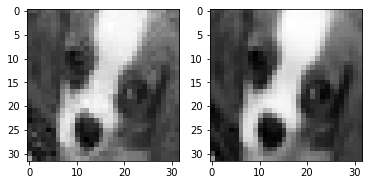

True label: 5
predicted label: 3
Time:  819.9375817775726  seconds
Initial fitness: 
 [0.1724248868592056, 0.17030302732140645, 0.2255331357873871, 0.16891316515644397, 0.0890492119772602, 0.17921608567574424, 0.19862668461837563, 0.18053956426080586, 0.22326187251979465, 0.10811107197978764, 0.2791087473063666, 0.23128831231620112, 0.1448082970298247, 0.15128628944270317, 0.23832954061486344, 0.20919060723687047, 0.1500297660667084, 0.17491765308957966, 0.16598871608407162, 0.15687728004176685, 0.20005534406454814, 0.2753143561114544, 0.30552393363016234, 0.14207650922946516, 0.24953951117528891, 0.20394284307435329, 0.16773811496934482, 0.1816796803071632, 0.1586980719352573, 0.22126549286940955, 0.11179287396444629, 0.1782195755721967, 0.18286381698992588, 0.2532447237795445, 0.019407216618779866, 0.20335148773668202, 0.22594490315066437, 0.11269895170720501, 0.1459565678787777, 0.17378269501584626, 0.13728713568606632, 0.14634647228792252, 0.208856078761256, 0.12467041866267749, 0.

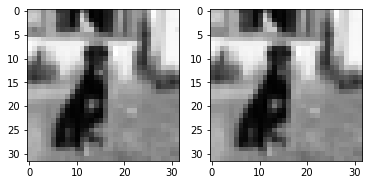

True label: 5
predicted label: 3
Time:  4.664194583892822  seconds
Initial fitness: 
 [0.5571907041925893, 0.6283231898764313, 0.6146107976785925, 0.5871758253838275, 0.5536430602365908, 0.5893181357909898, 0.6485816887056112, 0.5637775544380181, 0.5660928743320752, 0.6487348926804748, 0.6085123216899941, 0.517222567205292, 0.6031734323789222, 0.5501956769550949, 0.5355631783961327, 0.5319481670225661, 0.6061983046170448, 0.4425608398580251, 0.5352737012767852, 0.5599835853150344, 0.525263717484516, 0.6090926090284492, 0.6590318558778157, 0.6145283236181123, 0.46699150728099936, 0.6837059748005496, 0.4977796402526219, 0.5417365842313454, 0.5455983279312706, 0.5233107163176552, 0.5404382100084565, 0.6191402396926311, 0.45385183101164206, 0.6132326807842841, 0.5766161191487622, 0.6699201029900858, 0.5312867691766336, 0.6143857110659778, 0.6056858919541324, 0.5700609768187894, 0.46731873424128034, 0.595078052599119, 0.5962339383109363, 0.5624495236286696, 0.5022962847787553, 0.73355638293

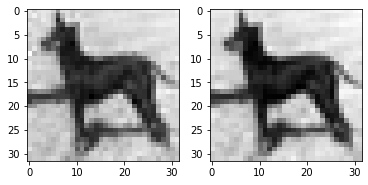

True label: 5
predicted label: 7
Time:  659.7251486778259  seconds
Initial fitness: 
 [-0.6000024811577244, -0.6000900987340057, -0.6004649037959591, -0.6000347921643712, -0.6000358933344008, -0.600046216650535, -0.600000094206807, -0.6006065983473605, -0.6000633471144545, -0.6000591798871293, -0.6001640568143213, -0.600392553527699, -0.600142443471531, -0.6013112788366233, -0.6004619439598446, -0.600052320934058, -0.6002450158589896, -0.6003647382475978, -0.6000463799607918, -0.6004376064288613, -0.6001089603048848, -0.600071645498516, -0.6001932993361971, -0.6003142898902929, -0.6003951979983411, -0.6000118377098236, -0.6000545304023188, -0.6001807719605821, -0.6000072431695631, -0.6001502007690478, -0.6001131672601308, -0.6001910280125453, -0.600500310776507, -0.6000818994261561, -0.6000476796986036, -0.6001322010286264, -0.6000941646732945, -0.6000903681202377, -0.6002249541858792, -0.6001715323801673, -0.6000703716097743, -0.6005177113679534, -0.6000510479625925, -0.60025551144949

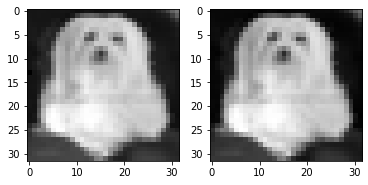

True label: 5
predicted label: 5
Time:  179.86627650260925  seconds
Initial fitness: 
 [0.4218185894370892, 0.15377295214781977, 0.39014747054589827, 0.3213001484226562, 0.48123765340696617, 0.45214087422655513, 0.3018028840827288, 0.40584919074049913, 0.35900859875424007, 0.4241675222597274, 0.3168823701342302, 0.33964963307065255, 0.28015650897982924, 0.3904990126069886, 0.33524405240857236, 0.28975698082057316, 0.332476602576117, 0.3644929233284563, 0.28844940011424436, 0.3233469268369872, 0.383353559902573, 0.27227276172129106, 0.31918886600230145, 0.37618013145732077, 0.3230244287696902, 0.28678006783459387, 0.25803576355531976, 0.36158329619243623, 0.28309035464636306, 0.2941796242648447, 0.40031591125653254, 0.2308413916594409, 0.20067733515940384, 0.3364682220262787, 0.5100430744652166, 0.11065847580951742, 0.27311677432034875, 0.3420188280468271, 0.41998614790417627, 0.2422303605702164, 0.37601227556792716, 0.3286617536330384, 0.27782566026393973, 0.22163612390756163, 0.368817

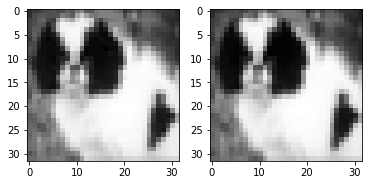

True label: 5
predicted label: 3
Time:  19.101020336151123  seconds
Initial fitness: 
 [0.4054447180626296, 0.550889819119028, 0.6287390740572072, 0.5469933398106099, 0.5776270811696969, 0.4193345084114124, 0.3158908456294097, 0.3172646954674802, -0.04114011166163964, 0.4722685668826163, 0.32756506891570253, 0.4741339083485496, 0.48374813719779414, 0.5007361937754623, 0.6066486327416202, 0.41548498874013273, 0.5529001960296253, 0.5205958310445681, 0.4333367972140988, 0.37251426404635435, 0.5651186896694361, 0.39204045769094514, 0.3658526233635362, 0.5622484214478929, 0.7416211545895952, 0.8573757588008608, 0.423848774640462, 0.41823750758825395, 0.44173295126618645, 0.36615057312177013, 0.2723205073393631, 0.39379188554784195, 0.36637956942234506, 0.46147230025914576, 0.03857074675197436, 0.3230060170922673, 0.4335446501260082, 0.32648451296502623, 0.2962985998181719, 0.32615250772140736, 0.5105963011959107, 0.48372222108884877, 0.4637055052193777, 0.4518610733931242, 0.348335973206057

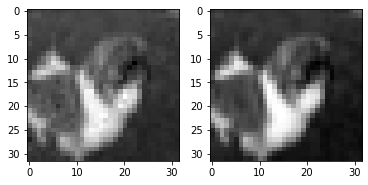

True label: 5
predicted label: 3
Time:  532.3339865207672  seconds
Initial fitness: 
 [-0.6000832314650502, -0.6002550349896234, -0.6002264886850147, -0.6000825916092088, -0.6003326422161578, -0.6004612751285462, -0.6001661896119792, -0.6002652092611218, -0.6000745142269803, -0.6002238337253161, -0.6001183168222926, -0.6001385172382849, -0.6002728655018663, -0.6005381055536421, -0.6001024315324244, -0.6002898870762632, -0.6000917839472322, -0.6000754658462827, -0.6001788626824063, -0.6001133567185689, -0.6004783097499901, -0.6000659174864332, -0.6001374629515388, -0.6003422094135021, -0.6001052053836664, -0.600298786339974, -0.6000675273960347, -0.6001000367359858, -0.6001642159119848, -0.6001377860053074, -0.6003948136127967, -0.600315236923875, -0.6000783173555846, -0.600554729239196, -0.6004186527926599, -0.6003483198033293, -0.6000399453005836, -0.6000653507042014, -0.6000805504747482, -0.6001357342837746, -0.6002531196979143, -0.6001716027134001, -0.6000814375688033, -0.6004631202

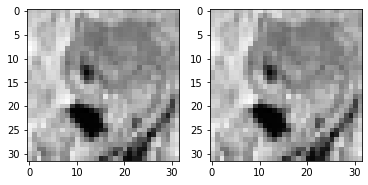

True label: 6
predicted label: 6
Time:  179.21265745162964  seconds
Initial fitness: 
 [-0.5509086998644329, -0.5368946327611029, -0.5596220495877755, -0.5441583506319835, -0.5582419136725166, -0.5599502961030807, -0.5474851426266805, -0.5565283695107592, -0.5685947512759166, -0.5413842604537313, -0.5535272130411578, -0.5508652276138376, -0.5721049426653266, -0.5266821588161754, -0.5316805932096196, -0.5305443824585293, -0.5405734723833396, -0.5632537247741741, -0.5440633734022273, -0.5527485417810911, -0.5478495321179174, -0.5410475547114575, -0.5307849742377324, -0.5524800912125737, -0.5368267241062697, -0.5447620320541426, -0.5375471093950329, -0.5310646063914756, -0.5389420408287314, -0.5384049362544219, -0.5556969196522953, -0.5161595758309004, -0.5617737823644868, -0.5448859315405093, -0.5426665041066303, -0.5455298017268443, -0.5498362803154856, -0.5407669787887089, -0.5281623907204076, -0.541810633852757, -0.5602143905363306, -0.5510802839965763, -0.5248730540762025, -0.5497691

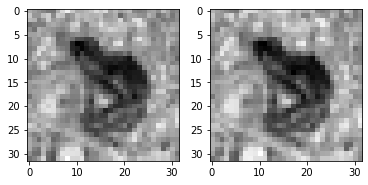

True label: 6
predicted label: 2
Time:  681.283499956131  seconds
Initial fitness: 
 [0.5091789299474991, 0.4998453554947182, 0.5294820543946926, 0.5165675627145037, 0.5623817876262329, 0.5612364815224, 0.5550539508130392, 0.5843951418333821, 0.4919110549952358, 0.5597592294340494, 0.5769509269515629, 0.5963439271930765, 0.5303720075560775, 0.6342447026872746, 0.5359131350066103, 0.6054343123609875, 0.5698229379897511, 0.5851298193346983, 0.5618714064809626, 0.5571124532668958, 0.4317387093772242, 0.5705612845486354, 0.5849910225669915, 0.6513915593185884, 0.5471618469687317, 0.5992946185915138, 0.5379801912682363, 0.5492279409590077, 0.5307603443791786, 0.5472338679762299, 0.5467979968714455, 0.5451052898237173, 0.6780455704393202, 0.5067268511993099, 0.543742824794256, 0.5585903169086863, 0.5563239786460404, 0.6401255841994291, 0.5675290811658574, 0.5204652897091193, 0.5666137173666206, 0.5565187943099603, 0.49421954137920054, 0.481155531690847, 0.507824853667979, 0.5743059739860853,

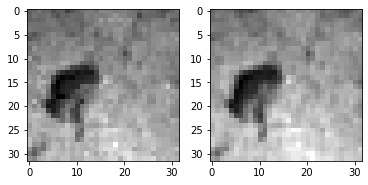

True label: 6
predicted label: 2
Time:  412.7697193622589  seconds
Initial fitness: 
 [-0.5994919124878284, -0.5995022646127969, -0.599646596370054, -0.5993266935535767, -0.5995406489636332, -0.5998736021580635, -0.5995859022020528, -0.5994815112913994, -0.5996325302715272, -0.5993801374697465, -0.5995287813698927, -0.5999560096661117, -0.5994877694349261, -0.5995360078402122, -0.5995592284128322, -0.5995876663068143, -0.5996580894574914, -0.599353488658739, -0.5998193393688852, -0.5995187331497132, -0.5996156853288547, -0.5996268698531638, -0.5997954306797126, -0.5998491393321317, -0.5996171177907488, -0.5998048907253049, -0.5995317163733855, -0.5998838019759929, -0.5995965722015566, -0.5996340144146504, -0.5997308390772775, -0.5998907233308464, -0.599643142488832, -0.5996891456094038, -0.5992209929874919, -0.5995994646692906, -0.6000209507966175, -0.5997469154161784, -0.5995106563224477, -0.5997246318893081, -0.5995366053269202, -0.5994548779603264, -0.5995983128903967, -0.5995228760

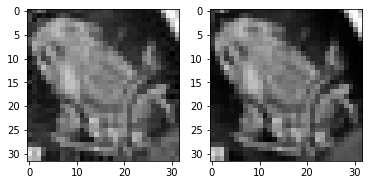

True label: 6
predicted label: 2
Time:  1549.3512663841248  seconds
Initial fitness: 
 [-0.599727531123252, -0.606622741283073, -0.5993834468475947, -0.6039493265702376, -0.6046999305064064, -0.5959784374622049, -0.5953440625576432, -0.5961391064436892, -0.5987803668343591, -0.601903325301835, -0.5959485438459865, -0.6062720961451415, -0.5900782675734657, -0.5986429701360703, -0.6056970586966911, -0.604922066137902, -0.599570203138881, -0.5984402756486552, -0.5978344353441624, -0.6010305477847836, -0.6026965771056726, -0.5981332509306794, -0.6011210730254618, -0.6057203280143707, -0.6111907932561884, -0.6025752682046486, -0.6000434382229121, -0.6040444324948513, -0.6005146228411904, -0.5976772523751215, -0.5992553322530926, -0.6043784676471671, -0.601794061358704, -0.6085760026569336, -0.597539427309381, -0.6022851478121787, -0.6031271627669237, -0.6054810211594036, -0.6045114129629852, -0.6009787017980425, -0.5961642152659204, -0.6098114227546156, -0.6062785225432288, -0.6045840509595

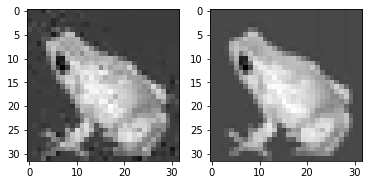

True label: 6
predicted label: 2
Time:  546.2057054042816  seconds
Initial fitness: 
 [-0.41489854475036575, -0.48930969150143433, -0.5089784684917892, -0.48764464640264815, -0.40597012305227, -0.5242626826084336, -0.5175938432356734, -0.47775144426487237, -0.524880947411878, -0.48600775318614764, -0.5115642546013733, -0.42198419937563447, -0.5204839988502001, -0.4175173147485881, -0.5211264024064747, -0.460617051762787, -0.3002179108539962, -0.47321060461036857, -0.4501217795490091, -0.5148881717373225, -0.5558009718099732, -0.5281462867850357, -0.4527331135585505, -0.4989416623654076, -0.47957787940702623, -0.5548790951249747, -0.534771133065057, -0.433004423503336, -0.4865316967161206, -0.5418201971825779, -0.5356119330698115, -0.4920201215389255, -0.48769634429935743, -0.49032978657418363, -0.4724793297523773, -0.48616051097367174, -0.49708157587233454, -0.5279521477805131, -0.4967562448992139, -0.4842603804949934, -0.4894026911577438, -0.47905170615176607, -0.4308326998645845, -0.

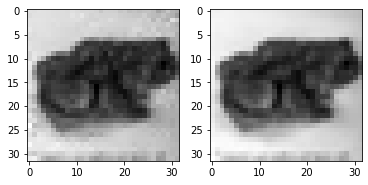

True label: 6
predicted label: 3
Time:  765.9414596557617  seconds
Initial fitness: 
 [-0.5990294960805302, -0.5992437152859948, -0.5994828858012488, -0.5992735380476818, -0.5986451933282365, -0.5994539116985497, -0.5994336006792781, -0.5992846114394142, -0.5988852840698309, -0.5985131520438149, -0.5990644913901066, -0.5998619266880256, -0.5991498159549701, -0.5991538772850362, -0.5994300395204973, -0.6000495184402902, -0.5992176358497615, -0.5991500284694288, -0.5996949243708681, -0.598795965863991, -0.5994199801653428, -0.5994242105861054, -0.598710884789331, -0.599198043606054, -0.5991079967667625, -0.5994847074270023, -0.5994158975985551, -0.5989346359466365, -0.5989177440740288, -0.5991588578961292, -0.5992296637786373, -0.5991122319117298, -0.599472884237613, -0.5995630219469325, -0.599807621844009, -0.5990009101720688, -0.5993336075504749, -0.5995497893255333, -0.6001657236875545, -0.5989793208928702, -0.5994027445907737, -0.5990135517639367, -0.5995708625983516, -0.599963525581

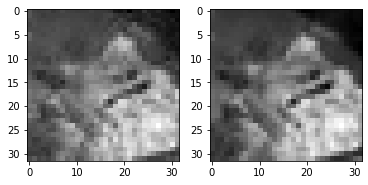

True label: 6
predicted label: 2
Time:  1107.6381244659424  seconds
Initial fitness: 
 [-0.30626394973040766, -0.09761902237629821, -0.12467355358336471, -0.043508086407706925, 0.051517732573427094, -0.09029805310405309, 0.0940644511476357, -0.10023015249917169, -0.1229777104321779, -0.0901634722229831, -0.04124360217057557, -0.029271156193772407, -0.2823147173368261, -0.03766941924542902, -0.10818298219467368, -0.2452956359417667, -0.11721967406273914, -0.0708880359100782, -0.255961712815311, -0.10546510273830506, -0.05025140274033035, -0.2506632338974236, 0.12404636748582518, 0.32335636729931216, -0.22345468426694293, -0.1306785502515662, -0.009017978901459223, -0.11207725399703583, 0.03060510325256971, -0.21413662720990045, -0.027190769515623797, -0.1596361418935649, -0.08059907431985985, -0.16798919756610392, -0.08120776571761118, -0.27349014149826667, -0.30257704347110126, -0.3836117705447952, -0.42243382531402796, -0.18420440752330264, -0.12516088954252264, 0.12184292114794751, -

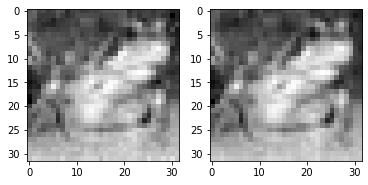

True label: 6
predicted label: 4
Time:  597.1350529193878  seconds
Initial fitness: 
 [-0.5997387953191998, -0.5997899249729294, -0.6000807289192478, -0.5998030468951295, -0.5997995388627803, -0.5999064527835526, -0.6005093748967478, -0.599801463510583, -0.5998316457608969, -0.5999163775786966, -0.5998749602019595, -0.5999603686893632, -0.5997240858328479, -0.5998367780670004, -0.5997614072620672, -0.5997868892203031, -0.5999128102111057, -0.6001122470116712, -0.5998580503205246, -0.5998591330498826, -0.5998559262308427, -0.5998466798956554, -0.59979049124037, -0.6001018365745172, -0.5998404352293515, -0.6000973274043052, -0.600036249164301, -0.5998555097479376, -0.5998919746813383, -0.5999692315225813, -0.5999474935151216, -0.599807578376614, -0.5999783931625443, -0.5997753709714879, -0.6000842117014316, -0.6001393683776337, -0.5998584303792602, -0.6001540646004757, -0.5999253867751739, -0.5998225548863252, -0.6000008535537366, -0.5997832888701147, -0.5998737397723329, -0.599970785650

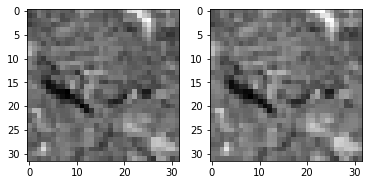

True label: 6
predicted label: 2
Time:  1094.7413094043732  seconds
Initial fitness: 
 [-0.5890127783292185, -0.5842388780183949, -0.5944819379566195, -0.5977541750826153, -0.5945537120746404, -0.5881050345357981, -0.5893492375168019, -0.5859151296843467, -0.5926552216838958, -0.5844606172160031, -0.5828666588393431, -0.5914608095164927, -0.5865865470347784, -0.5910421318416357, -0.5882617084217966, -0.5914889258965196, -0.5828592816539451, -0.5923243041029451, -0.5924148605672641, -0.5938660067369441, -0.587828016747617, -0.591817815678143, -0.5868183019658983, -0.5923282393007863, -0.5917436050915428, -0.592535416436888, -0.592994697643565, -0.5841070094850557, -0.5879691726877285, -0.5778726297549317, -0.5828939045009576, -0.5923901043451416, -0.5879033766596999, -0.5898013197951453, -0.5931076724371306, -0.5915979431944273, -0.5893182256942237, -0.5935500123713308, -0.597006537698035, -0.5866079267717041, -0.5890848840998124, -0.5871200309454292, -0.5854267629802496, -0.59143857027

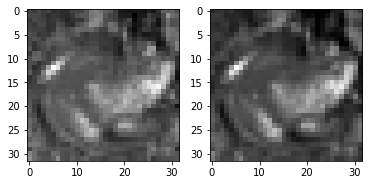

True label: 6
predicted label: 3
Time:  856.2132256031036  seconds
Initial fitness: 
 [-0.5977149075710728, -0.5990299976458946, -0.597343509920844, -0.5960842904536923, -0.5976204796745352, -0.5978331722425522, -0.5978519830927999, -0.5977508818913015, -0.5975974134309868, -0.5978912927227815, -0.5988153813466168, -0.5980700371035776, -0.5974778073475315, -0.5981152576563693, -0.5980607564035152, -0.598260317385489, -0.5973042045693004, -0.5976867894826038, -0.5981028267782431, -0.5988050648711333, -0.5986643485224545, -0.5980979822058432, -0.5979624294909064, -0.5978019143326131, -0.5978943290458676, -0.597986369468889, -0.5981521218832327, -0.5977668593347303, -0.59829611101933, -0.5978368424640986, -0.5973877330983888, -0.5980863416374448, -0.598284292683924, -0.5990943933461019, -0.5986222184098229, -0.5982267077454801, -0.597988734553682, -0.5975506913105987, -0.5984015935106468, -0.597706412589364, -0.5978422873863825, -0.5973643719752736, -0.5983164461363063, -0.598408486081536

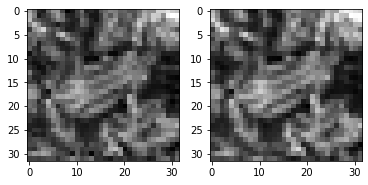

True label: 6
predicted label: 2
Time:  689.7617127895355  seconds
Initial fitness: 
 [-0.5949367167488688, -0.5907246730054618, -0.5972488121866876, -0.597388651662266, -0.5977125442570028, -0.5933100667056525, -0.5961545670001079, -0.5963960885422125, -0.5938397186128941, -0.5972318559552356, -0.5952528605394979, -0.5969422197767725, -0.5936222530519444, -0.5955131372072423, -0.5969991690912337, -0.5964550468338163, -0.5977692876914299, -0.5963236720792039, -0.594027975217154, -0.5982009678510045, -0.596091723929114, -0.5944437251206429, -0.5955158918100036, -0.5960564153905188, -0.5962166890393733, -0.5963003469226948, -0.596309769298717, -0.5942046404232977, -0.5957607959927498, -0.5972486459688131, -0.5968428771477868, -0.5969795632177064, -0.5960426756001566, -0.5972977803613316, -0.5976935140044124, -0.596953042729888, -0.595158974121724, -0.5976326598719006, -0.5989803634295161, -0.59369881007991, -0.5948960865117904, -0.5973255719593347, -0.5942824370467577, -0.596159096311537

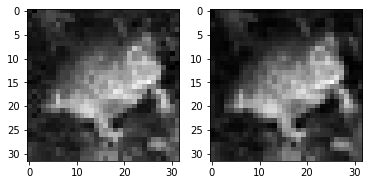

True label: 6
predicted label: 2
Time:  465.601371049881  seconds
Initial fitness: 
 [-0.5977810216197557, -0.5993018599339412, -0.5974815093452204, -0.598237303216356, -0.598597355672821, -0.5974024825643729, -0.5981532572385696, -0.5984059051224331, -0.5974686710929972, -0.5982261286258401, -0.5991595269836882, -0.5990901331393219, -0.5990124270385887, -0.5987740344566042, -0.5977988952243354, -0.5980253458727204, -0.5986675219004551, -0.598455941119451, -0.5978474012955296, -0.598272693034972, -0.5980381372074197, -0.5966858756117523, -0.5970139738754456, -0.5979816703378198, -0.5981407053758928, -0.5988994321796817, -0.597315474273651, -0.5979055738192068, -0.5978478485279245, -0.5986445280389652, -0.5975687613780054, -0.5980933885950468, -0.5980936691319522, -0.5982521652455421, -0.5974697908391714, -0.5978827011003076, -0.596914345157359, -0.5980559223563792, -0.5989341051930506, -0.5979763495328038, -0.5987656977553096, -0.5975124459594707, -0.5980713158967436, -0.59805218827034

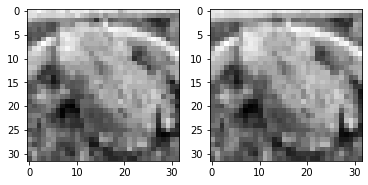

True label: 6
predicted label: 2
Time:  404.25117468833923  seconds
Initial fitness: 
 [-0.6000159652723718, -0.599469981191044, -0.6010672719017408, -0.6002986940095016, -0.5994173185270418, -0.5990278826635965, -0.6021423060156446, -0.6008332468102608, -0.6008435050023408, -0.6002118405437784, -0.5980306043659529, -0.599034929904529, -0.6025372903861569, -0.6007194998848101, -0.598728095533316, -0.6029568219461644, -0.6001123762160993, -0.5993690199266845, -0.601612757993929, -0.5998480053202054, -0.6020484848667973, -0.6030561164337236, -0.6004664435142402, -0.5997785193865175, -0.6010403467442261, -0.602485937973973, -0.5992681067441505, -0.5992750223465086, -0.6004835337514891, -0.6006287678629035, -0.5997045508265443, -0.6001828150423455, -0.6009179226129099, -0.5993741151587143, -0.5997490845702225, -0.6017023336177316, -0.5994355988386664, -0.5991230512300014, -0.6013154522328215, -0.6019317144427061, -0.603312305073492, -0.6014193749170044, -0.6019070241061306, -0.599098327754

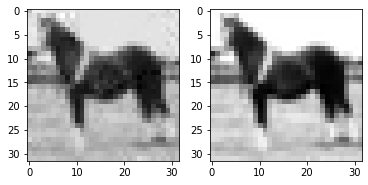

True label: 7
predicted label: 5
Time:  604.922845363617  seconds
Initial fitness: 
 [-0.6007922560418005, -0.6028489036520115, -0.5987482697716984, -0.6002194381280542, -0.6062477410247799, -0.601635436710172, -0.6041475920539728, -0.6047979802273971, -0.6037318386081704, -0.6027873351701347, -0.5980091176342218, -0.5987235763567236, -0.599405693385655, -0.6014277373000336, -0.6006491418409245, -0.6034488582944025, -0.6014366329238697, -0.5997937548518323, -0.5991436831883736, -0.6031181957789962, -0.6064454714729188, -0.6017572761113281, -0.6007645651132154, -0.6020761159452122, -0.6022562028572022, -0.6000790450408683, -0.5988006689214567, -0.6025917310612801, -0.6025052315385779, -0.6053544480160322, -0.5991154018245376, -0.602702043261971, -0.6031656364519289, -0.6022839633715874, -0.6036295654432619, -0.6022157646118143, -0.5997511686673086, -0.6019295820271323, -0.600030725514088, -0.6076015442960006, -0.603421775768443, -0.6003915276627843, -0.6048103494139848, -0.6018820505887

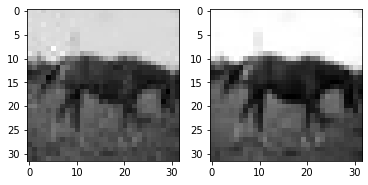

True label: 7
predicted label: 4
Time:  532.9053847789764  seconds
Initial fitness: 
 [-0.6001131145541789, -0.600117855294036, -0.6005813573624583, -0.5996796449100463, -0.5997307244204497, -0.6013981124640297, -0.6012202109713721, -0.5995943855521655, -0.5998214493186541, -0.6011912575899201, -0.6001665741469481, -0.5996251394852709, -0.5996524630017825, -0.6007355417117146, -0.5999060970306993, -0.6001793214003327, -0.5998199079899252, -0.5999966668892358, -0.6000345107613527, -0.6006317915719042, -0.5997052454826783, -0.6008562997493744, -0.599693155100929, -0.5995821228585656, -0.6007144165244733, -0.6005417553006762, -0.5998162491208854, -0.5997185618162051, -0.600110167102078, -0.5999815035552207, -0.5999517825953589, -0.599908656686401, -0.5996887570514817, -0.5998141853475455, -0.5995696898433658, -0.6006184844542569, -0.6000997961826903, -0.5996778296906511, -0.5999113955272992, -0.599951434054363, -0.5997583561588946, -0.5995662949121586, -0.6001406103519433, -0.599767618795

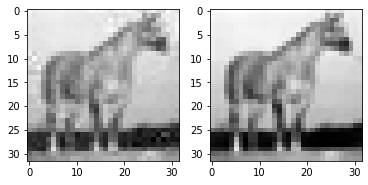

True label: 7
predicted label: 3
Time:  1621.6215603351593  seconds
Initial fitness: 
 [-0.5387960974895261, -0.44254731322749474, -0.48516585345506813, -0.5021142443006845, -0.5382560399563666, -0.5103365805777409, -0.556222884705988, -0.5664638245691715, -0.5151419359149164, -0.5458068268288008, -0.5183590514343392, -0.4878058456526396, -0.5204574040009592, -0.49286763338376405, -0.517482144515127, -0.4933318085261106, -0.5329059635278657, -0.5650424215431511, -0.5262273258119955, -0.5008105734932393, -0.5581706929691748, -0.5242435090447801, -0.5101154248688798, -0.4689375557008998, -0.5419128301701477, -0.49176791048912977, -0.5122644987927438, -0.5177308072147982, -0.5111405390368587, -0.532417074262466, -0.5246343416680317, -0.4649116007592925, -0.5126806490833806, -0.5308957987685615, -0.5391786393676632, -0.4158281363573305, -0.5109786559249858, -0.5415692771665126, -0.5266762304442887, -0.47222182633573384, -0.5440452903206972, -0.5017544895372782, -0.5467165028167678, -0.5252

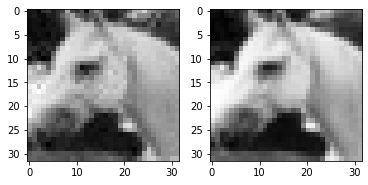

True label: 7
predicted label: 3
Time:  971.2118501663208  seconds
Initial fitness: 
 [-0.47183001506883493, -0.3790913647851732, -0.45347699182372336, -0.5163015457237244, -0.4517735773466264, -0.4681187732878155, -0.4757522489748721, -0.4782983038978866, -0.5179711062326924, -0.48819748014481634, -0.47269878242205965, -0.42217637750997805, -0.5118192991590123, -0.4528819316207812, -0.527137617628917, -0.40569799722669064, -0.49071821160070256, -0.5058669923230447, -0.28411120644777355, -0.5106045909356157, -0.47879342180611517, -0.423899398384877, -0.4510377664299948, -0.48733275554996097, -0.29661464446125674, -0.5001934086782321, -0.5293677209579918, -0.39147324758096, -0.4576441047394505, -0.4223017700528773, -0.5052794118873866, -0.49358669440438463, -0.49231113849990127, -0.4792714433908337, -0.4958482225718421, -0.4897922284287603, -0.4975223935944446, -0.5202423583410059, -0.45507041918953917, -0.48331078281955075, -0.44167921177647634, -0.49670659255607486, -0.405106140451951

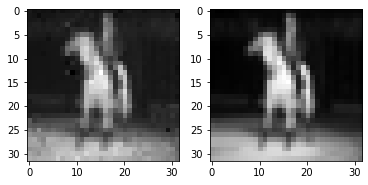

True label: 7
predicted label: 5
Time:  543.8071410655975  seconds
Initial fitness: 
 [-0.600468123161179, -0.6013831622370712, -0.6003408357922182, -0.6019776399078086, -0.6003324448943974, -0.600254777597981, -0.600153242482088, -0.6001192679611284, -0.6002559499249264, -0.6015248257608002, -0.6001830870218536, -0.6002679313403512, -0.6003074530735913, -0.6011227574891856, -0.6000410436480424, -0.600750893940259, -0.6012187119560883, -0.6003942622472549, -0.6006089148214775, -0.6005254932870782, -0.6000664661473364, -0.6009942661265127, -0.6010286110936822, -0.600448750992251, -0.6003705992551177, -0.6004977632093044, -0.6009292557929263, -0.6008094858264018, -0.6005950602914397, -0.6010740319219267, -0.6008235814108064, -0.6005474882525474, -0.6020100682717268, -0.6005423286892506, -0.6005320953828365, -0.6007926948430893, -0.6007020983681316, -0.6006359270248917, -0.600240572096681, -0.6008678651597487, -0.5999996976239805, -0.6006355252988951, -0.600076584840586, -0.60035926292121

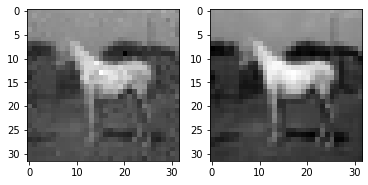

True label: 7
predicted label: 5
Time:  627.0353815555573  seconds
Initial fitness: 
 [0.4876905417841686, 0.572059561985397, 0.5830359087222656, 0.6095678341255445, 0.6550955998257152, 0.5943356175812622, 0.5349337989381452, 0.6186946361889978, 0.5870785562213464, 0.6084435027931513, 0.599071321352182, 0.7143719592896903, 0.5401301850958294, 0.5742168156036919, 0.723400124580734, 0.5562561486268397, 0.6059781762631349, 0.5820892564393059, 0.677121429875954, 0.5964710933170764, 0.535015969796196, 0.6480869189923515, 0.5937681604904207, 0.5970826004993907, 0.6830667717256913, 0.5901764199734207, 0.602655117164902, 0.6430867562123372, 0.5476791032023683, 0.5612853261516375, 0.5772737022789319, 0.7589508641033857, 0.6464136288723723, 0.6950892176449048, 0.5849747142746822, 0.5950421274862592, 0.5552130667048536, 0.6016823422388708, 0.620058333508071, 0.6003385072971641, 0.5563675157813016, 0.624164548734952, 0.5611549522692468, 0.5912402638885417, 0.5821585630703421, 0.6272017160754688, 0

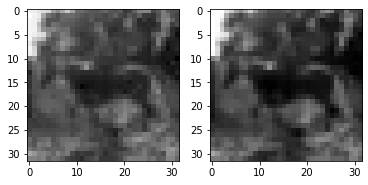

True label: 7
predicted label: 2
Time:  319.30135846138  seconds
Initial fitness: 
 [0.2056223772095736, 0.41455513338999994, 0.2915488844820552, 0.2822084269345056, 0.36265703322584153, 0.2506684873116097, 0.36034916036568554, 0.41314145673611635, 0.26216599222043463, 0.37578945395565194, 0.21923788684483117, 0.1170923272969487, 0.5981507703407399, 0.29402078315031316, 0.3304519034319936, 0.20097275995339894, 0.39067760401240914, 0.32685880165581677, 0.32215807782734535, 0.41549100500283087, 0.1773521027664659, 0.313741860885541, 0.36818389203776214, 0.43071668502988936, 0.40448326640604537, 0.47070271159403554, 0.2834680090305187, 0.26429855201535063, 0.3159276559446501, 0.17613424751360485, 0.3288297291522856, 0.26847343697434034, 0.3090075547076927, 0.36033500705624966, 0.3603209021798607, 0.18422087171041857, 0.3321991487016046, 0.31570372919061906, 0.3594284960491201, 0.29656747364549985, 0.33793116579436344, 0.2775512271869055, 0.2747909265555407, 0.37504167818884565, 0.26458514

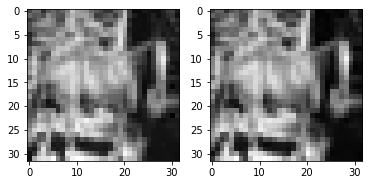

True label: 7
predicted label: 9
Time:  431.0333020687103  seconds
Initial fitness: 
 [0.24457037136121879, 0.21255752146274834, 0.5149688971387761, 0.2583649453294531, 0.2716069193436137, 0.2872283286907756, 0.5011527985673646, 0.5604427766341482, 0.46432258646324565, 0.029873027671739244, 0.272085715189237, 0.21375993916289207, 0.2353900950451201, 0.09110151956951353, 0.37687661504200376, 0.19088586007575786, 0.3931911650800336, 0.26988251744836095, 0.28008247622031046, 0.13227359089565877, 0.28714840698352306, 0.2904593364231114, 0.08068463714202571, 0.3028828224545404, 0.23171092776897664, 0.21547639547241743, 0.16538715554467723, 0.3853031267504286, 0.35493300589199805, 0.25997731405699265, 0.5203848052224871, -0.013421636652349023, 0.30764038049088827, 0.44173564897095285, 0.26402836033348387, 0.35074795511585866, 0.29351458956141235, 0.4368494559712052, 0.46963260013462266, 0.26440119894416153, 0.2073372379200886, 0.32975276400277725, 0.3618730356280091, 0.28362468552791403, 0.3

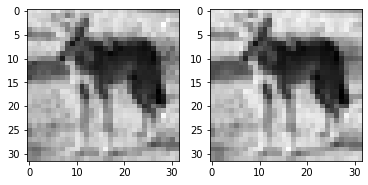

True label: 7
predicted label: 4
Time:  456.8249273300171  seconds
Initial fitness: 
 [-0.5803738248549266, -0.5708734251980345, -0.5815284049133359, -0.5847011873485823, -0.5661486335836221, -0.5726918211360741, -0.5812200569778535, -0.5886028552848033, -0.5851057082427831, -0.5703396979481166, -0.5896761430245683, -0.5862269156568354, -0.5746893041112937, -0.5782078050541444, -0.5861424943732463, -0.5747693351161428, -0.5814400901199118, -0.5725865354135469, -0.5816987088196701, -0.5875287623812199, -0.5785280932990173, -0.5631162279156127, -0.5794334392871789, -0.5725159835038137, -0.5816135465665672, -0.5778145604340215, -0.5818389661117507, -0.5754771908513678, -0.579713695482228, -0.5493196476153209, -0.577465947902458, -0.5733624741877597, -0.5784603381540578, -0.5750676526337453, -0.5831560072132076, -0.5749262073794497, -0.5833551540373809, -0.5791558034989464, -0.568684476662279, -0.5097146131427319, -0.5834104599034383, -0.5729259883294414, -0.5833382609222203, -0.5768129122

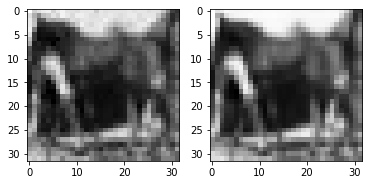

True label: 7
predicted label: 6
Time:  856.845782995224  seconds
Initial fitness: 
 [-0.5975982204848, -0.5910883941739689, -0.5973150868523378, -0.5970620522616169, -0.595024149705587, -0.5964921000774036, -0.5968878725165467, -0.597901845789566, -0.5969314640326668, -0.5976943886743787, -0.5941120674419974, -0.5944414364498023, -0.5975732161286575, -0.5937094158535201, -0.596720791323547, -0.5964671629657201, -0.5971718720800987, -0.597227389631318, -0.5981236749020972, -0.5957229995404653, -0.597034762922403, -0.5968136484665943, -0.5953145884197601, -0.5978349828495794, -0.5981220703848084, -0.5975150197667662, -0.5954754705830217, -0.5973159540753057, -0.5968426802888529, -0.5966505685010756, -0.5957530641032434, -0.5978198855091547, -0.5978343337165212, -0.595126723152958, -0.5985063524173756, -0.5969398039625585, -0.5970375897567006, -0.5986474846787907, -0.596885413821412, -0.597472105171368, -0.593762997650437, -0.5966663730906241, -0.595639208999595, -0.5958465440171031, -0.

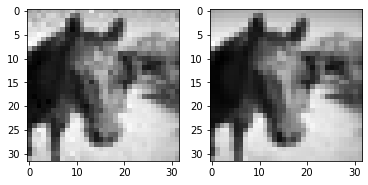

True label: 7
predicted label: 3
Time:  689.3978152275085  seconds
Initial fitness: 
 [-0.5894336372585427, -0.5880287963586024, -0.5865633767713639, -0.5892846589254699, -0.5950490272327154, -0.5902465482631114, -0.5908056505010257, -0.5895368794589295, -0.5899861694492683, -0.5904617842495731, -0.5901213082910591, -0.5832905623942145, -0.588317010918694, -0.5812777106213534, -0.5892408157165768, -0.5890817682850894, -0.5836740477733557, -0.5813615054020055, -0.5914578985968745, -0.5881349660248998, -0.5782497158260724, -0.5815365033776718, -0.5895204069790769, -0.5818975768173634, -0.5896733749654115, -0.591567914455904, -0.5862353185704906, -0.5680910208355322, -0.5930544377554376, -0.5905552664140858, -0.5827744335118584, -0.5856754295208485, -0.5924996364728903, -0.5901970422839964, -0.5913338970793528, -0.5904532292126764, -0.5849372098642482, -0.5912677239923789, -0.5851767678963854, -0.5869737767066611, -0.5880261665386479, -0.5890570729033009, -0.5909794689129878, -0.580925162

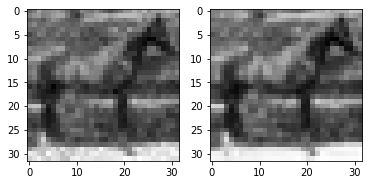

True label: 7
predicted label: 4
Time:  754.4259562492371  seconds
Initial fitness: 
 [-0.32117081342195153, -0.403415697793657, -0.30266348423257905, -0.2387021076008355, -0.317920553192901, -0.3069136822090987, -0.2320378081639114, -0.1347314508985854, -0.2977970941684794, -0.3420725084623998, -0.2704837367454118, -0.1931853332839539, -0.31626356049010274, -0.36127628824581787, -0.35708528887812385, -0.2904977472644035, -0.19196710061174355, -0.32689184521831854, -0.3665866940667295, -0.22858363572294105, -0.3948868750529264, -0.24828496699207447, -0.25004296140296967, -0.2545195881260861, -0.23794734421997324, -0.32204953836190486, -0.29390451100406756, -0.32449524521394474, -0.19901314233289713, -0.15873860653425007, -0.21151013755793743, -0.28758258450784535, -0.30699913814899504, -0.34185991440523394, -0.2188362698668463, -0.37461239023496823, -0.361858407659035, -0.34661499239403526, -0.3678415706873097, -0.35254267442549264, -0.4280348774671814, -0.2933915158090158, -0.38437990

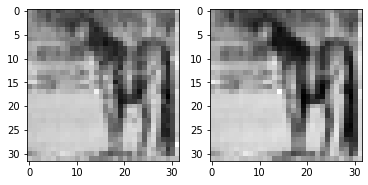

True label: 7
predicted label: 4
Time:  495.0823390483856  seconds
Initial fitness: 
 [-0.5993834256702926, -0.5995103365166741, -0.5991931176895109, -0.5992555787990936, -0.5992820596170809, -0.5995798462531367, -0.5993439757800161, -0.5993539141343541, -0.5994278997230922, -0.5996205755281305, -0.5995666248839358, -0.5994425462288603, -0.5983772819400104, -0.5999027058718182, -0.5993226537951373, -0.5988937540812638, -0.5996335821671005, -0.5997557687673365, -0.5996376661000132, -0.5993186000678528, -0.5997450863061519, -0.5993750775195753, -0.5989862996215427, -0.5998718035483466, -0.5980826958349866, -0.6001946205932556, -0.5994022099824888, -0.5995054599424712, -0.6001639600015886, -0.5995754001426943, -0.6003637599648601, -0.5989900708705606, -0.5997561626689991, -0.5992904216867152, -0.5991948035340242, -0.5993431082081608, -0.5990427956097355, -0.599724593146517, -0.5995791940437699, -0.5996139907798119, -0.5994611408998584, -0.5995107590879017, -0.5987584899471909, -0.59950189

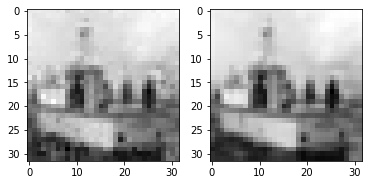

True label: 8
predicted label: 9
Time:  843.4372601509094  seconds
Initial fitness: 
 [-0.5697003430811077, -0.5632825549875891, -0.5486620152288888, -0.5623009695004063, -0.5662190386560252, -0.5646965639680028, -0.5796989438553464, -0.5442934390250531, -0.572620089383487, -0.5720214780860735, -0.5651637460608124, -0.5352680544260973, -0.5618613723126734, -0.5582895832519823, -0.5775296898300243, -0.5775062022403025, -0.5663629630372576, -0.5740617515328852, -0.5717672186543119, -0.5700516874274828, -0.5436197133013607, -0.5573869491021664, -0.5698148410076338, -0.5693938500335374, -0.5722975974339415, -0.572927929784282, -0.5636751521483215, -0.5734163474397201, -0.5675662781328256, -0.5772420375837576, -0.5407378189099268, -0.5738610101541648, -0.5594410893706967, -0.5747053369318109, -0.5734127995795593, -0.5581428059246376, -0.5744203289469536, -0.5700012836042698, -0.5638344743997152, -0.5731183645517349, -0.5759104614661941, -0.5751292223418286, -0.572238064332461, -0.5813135223

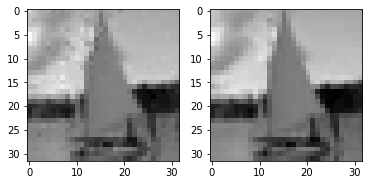

True label: 8
predicted label: 4
Time:  325.6851978302002  seconds
Initial fitness: 
 [-0.22849728334493805, -0.24199522205737548, -0.3975959296827326, -0.2992243705631359, -0.2305811920636135, -0.34151380107165574, -0.1510039148250699, -0.43139027324619084, -0.2870545195923244, -0.377731928222255, -0.38338558936810696, -0.297115021408511, -0.25383266025485546, -0.2735034832372737, -0.24184219085880934, -0.29516268201338836, -0.47321155835665485, -0.3751377758266912, -0.2907220904247837, -0.319435655343249, -0.20845083477121523, -0.25267849503096595, -0.440218990588071, -0.2393694958318911, -0.17194057045132166, -0.2986930970362516, -0.344225453422636, -0.3403434105079721, -0.45827581172503207, -0.34895551382655887, -0.32941233535148606, -0.33387219986055094, -0.21491995260705393, -0.1447687618016597, -0.17612256758641626, -0.4610365325613174, -0.4420563570168805, -0.411562702400769, -0.24380451501213746, -0.3118095499446952, -0.2872931480830122, -0.4444589312988272, -0.470365625616347

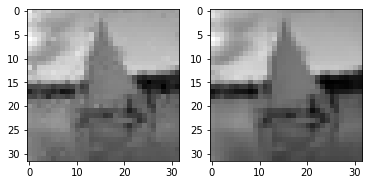

True label: 8
predicted label: 0
Time:  369.60182762145996  seconds
Initial fitness: 
 [-0.6031250115663276, -0.6081179567398313, -0.6056190946007701, -0.6033605994421052, -0.6051880059848305, -0.6030713675765481, -0.6099541545226522, -0.6019415967778722, -0.6029540891389726, -0.5999571347820842, -0.6045487801009156, -0.6027216472581522, -0.6063381893632984, -0.6002083417464046, -0.6038801354624139, -0.6050827597339035, -0.6023274239042387, -0.602948893015426, -0.6009965379565098, -0.6092215056827827, -0.6001276124670041, -0.6042962786689212, -0.6042267586765018, -0.602752072515732, -0.6048956010958216, -0.6137820531540408, -0.6012424700687395, -0.6037207796062743, -0.6020960150592904, -0.6002925789575329, -0.6000616675713525, -0.6101624141233933, -0.6009514633534002, -0.6022233458835741, -0.6008307236162445, -0.6000358273335475, -0.6012893709005706, -0.6020829382834317, -0.602975208909154, -0.6071555983295042, -0.6006880614893725, -0.6094907182215418, -0.6034215162321965, -0.600460629

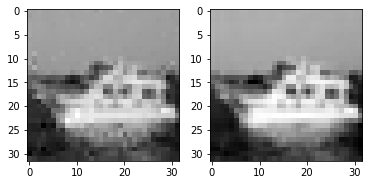

True label: 8
predicted label: 0
Time:  356.51581358909607  seconds
Initial fitness: 
 [-0.599782676930112, -0.5997111232994833, -0.5997159808124457, -0.5993531748460679, -0.5992556662221868, -0.5995971667749911, -0.5999284931029274, -0.5995805299417059, -0.5994652305850172, -0.5989302677484571, -0.5994825140564699, -0.5996013893612936, -0.5997907546820103, -0.5994979311392812, -0.5992977510292387, -0.5994771832203163, -0.5994950217793095, -0.5996611872000989, -0.5998975379102097, -0.5996153652812778, -0.5993731422531192, -0.5992234764426885, -0.5998643100378007, -0.5995430181928518, -0.5996120658109103, -0.599449216582321, -0.5996312442515432, -0.5997408570911206, -0.5993635904454387, -0.599731061375345, -0.5997224555216615, -0.5995637708241653, -0.5996058032174096, -0.5997430657423698, -0.5995322499006197, -0.5993983436574124, -0.5991536111238508, -0.5997023008841088, -0.5996352286278339, -0.5994872534220684, -0.5997700836112428, -0.5993812931996331, -0.598955052934243, -0.5997385361

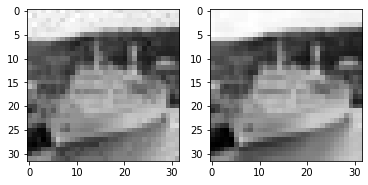

True label: 8
predicted label: 6
Time:  544.2070014476776  seconds
Initial fitness: 
 [-0.5954626677177779, -0.5822842621586622, -0.5865313198071638, -0.5898422182123814, -0.5939677272942989, -0.5892151128847689, -0.5971787475086985, -0.5899802279967147, -0.5911276192142415, -0.591375413847715, -0.5910804684405431, -0.5941085037113083, -0.5913771969272333, -0.5875543207581881, -0.5904581519685607, -0.5916094231586542, -0.5895712329152962, -0.5901940334193119, -0.5945156509909291, -0.5926656690613387, -0.5933877325946985, -0.5936991662395508, -0.587008293023673, -0.5954316496247015, -0.5934338383743014, -0.5883191171627784, -0.5835512775969004, -0.5892420407654362, -0.5918761837708069, -0.5915710466128608, -0.59275288876888, -0.5903773230003763, -0.5928003724601248, -0.5915239834500768, -0.591066433421882, -0.5884649035293983, -0.5935164182060565, -0.5880457916739845, -0.5865455016022635, -0.5903148099730026, -0.5874490695476003, -0.5912944309075208, -0.5922308005574946, -0.590526313666

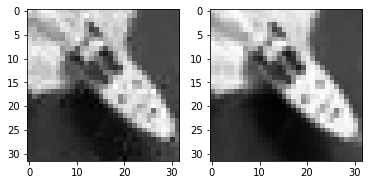

True label: 8
predicted label: 0
Time:  689.6321904659271  seconds
Initial fitness: 
 [-0.6008463053855958, -0.6027398694725329, -0.6015679906655353, -0.6087084176641182, -0.6007406285426803, -0.6001678181883329, -0.6017892846201117, -0.6002456697517213, -0.6035924204693072, -0.6021073999664506, -0.6007966418953585, -0.6002148681922149, -0.6016527518923607, -0.6036719657747439, -0.601408524148765, -0.6009797146582668, -0.6006363251570054, -0.6019931740669756, -0.6029135878207122, -0.6065615635312163, -0.60036035516455, -0.600790427727385, -0.6003775018365902, -0.6011218255163253, -0.6014293238644397, -0.6039472733275588, -0.6018428495867509, -0.6014102611434028, -0.6028891206042017, -0.6030727093423349, -0.6009476921653919, -0.6003859600385952, -0.6034826637496381, -0.6018864443531721, -0.6069315483012575, -0.6053348167852026, -0.6024634836683117, -0.6001750525071418, -0.6007260813692453, -0.6008732588806629, -0.6003641708345886, -0.6020463638315492, -0.6028532066920991, -0.60073384005

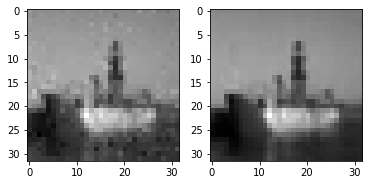

True label: 8
predicted label: 4
Time:  449.5146436691284  seconds
Initial fitness: 
 [-0.599642466681122, -0.5997621239315044, -0.5999282581739529, -0.5989798142768336, -0.5996177037451852, -0.5990968505928106, -0.599783746018631, -0.5997672833907124, -0.5997628729916514, -0.5998765770076553, -0.599435695293097, -0.5997757138692149, -0.5999061331753106, -0.5998633563051241, -0.5996887130949793, -0.5988188799028401, -0.6000132495447434, -0.5995928402027241, -0.5995123418316386, -0.5994233012559327, -0.5997984913920205, -0.5999352298711523, -0.5998891109703178, -0.5996126595496944, -0.5996741787120106, -0.5997091693757023, -0.5996038294752872, -0.599718009211379, -0.5999202483247862, -0.5996615475824443, -0.6000093814611651, -0.5997247939815298, -0.5995964276835123, -0.5999062418986671, -0.5998646935172628, -0.599855460040455, -0.5997801013984474, -0.5998430323920105, -0.5997465978331841, -0.5994257890473739, -0.5998691879038842, -0.5997139910640229, -0.5999559773505209, -0.599623328965

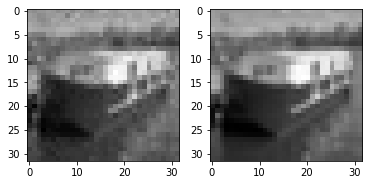

True label: 8
predicted label: 6
Time:  708.8124198913574  seconds
Initial fitness: 
 [-0.21894743824268037, -0.4336816665948765, -0.48466483049876674, -0.11175699722142374, 0.26844423545443113, -0.3893274257976984, -0.12824959419688114, -0.11378269849803627, -0.3711040153339338, -0.4767533702253972, -0.5023856506947331, -0.36389742063275654, -0.24374137287136807, -0.15441538750295214, -0.3280491255047433, -0.3924566736632302, -0.3531095958036523, -0.2975554111140196, -0.16385135517905397, -0.15193843783565414, -0.44155544488114934, -0.49451245666349675, -0.37057741450944104, -0.486173641444271, -0.4332495955990642, -0.21573665803472208, -0.2677736436741456, -0.33873539692890176, -0.4400675277026377, -0.3647312641955405, -0.23152988250759376, -0.42426048470122324, -0.43327827359968274, -0.2549564233892212, -0.39452882979961457, -0.24761925023843, -0.5080372131693365, -0.3090675740305578, -0.39731541295779416, -0.23471231370346254, -0.3297746410718697, -0.31800783206669436, -0.391392506

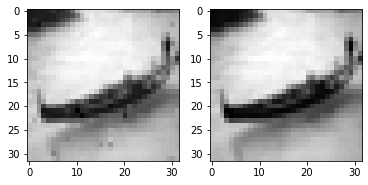

True label: 8
predicted label: 0
Time:  220.4312620162964  seconds
Initial fitness: 
 [-0.601539320266365, -0.6046383744808671, -0.5966424522585647, -0.6031124507218577, -0.6048820227913935, -0.6076855438093223, -0.5997642547843508, -0.6020330928473439, -0.6007753173678332, -0.6039887600106129, -0.6081345416713794, -0.6005094899539954, -0.6008026184936446, -0.6031548966455758, -0.6017661287689521, -0.5999781612796008, -0.6018130575242684, -0.6039182760719598, -0.599239310797981, -0.6011101899826249, -0.6081070523112395, -0.6075561111459065, -0.5998264807691904, -0.5996324198045331, -0.6012183675542985, -0.6041055339724797, -0.6025906627225721, -0.599654179640241, -0.6013188941448528, -0.5998753819821051, -0.6024656397826404, -0.5997815247575494, -0.6045167956201403, -0.5985055592310318, -0.6012574083736328, -0.6044982457887036, -0.6000473106234319, -0.6002023818143359, -0.6019953964106424, -0.6010124054893593, -0.6053096744680073, -0.6000712131842368, -0.6003454249062887, -0.5996069110

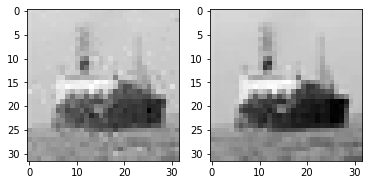

True label: 8
predicted label: 6
Time:  357.3961834907532  seconds
Initial fitness: 
 [-0.600362169201664, -0.6003544327540181, -0.6003431199403757, -0.6004696917205329, -0.6001650559932382, -0.6003777976972655, -0.6011348555940592, -0.6004104345953467, -0.6008386957186242, -0.6000985580591272, -0.6003568388133169, -0.6005405486041241, -0.6009097371294637, -0.6006133767233199, -0.6001832367846348, -0.6002210910847128, -0.6003623085532717, -0.6002402735795045, -0.6005615163081965, -0.60060494019819, -0.6003107701477568, -0.6003669356807819, -0.6003182999698871, -0.6002032772791506, -0.6002638944220132, -0.6002292760192178, -0.6006668970697017, -0.6001440858875069, -0.6002133555722723, -0.6001244155830898, -0.6002824512312332, -0.6003577998058334, -0.6009046618432693, -0.6001622230317429, -0.6005360572565763, -0.6003702327970711, -0.6002008056343017, -0.6005116763832539, -0.6008450149104317, -0.6003945640435516, -0.6002059740434508, -0.6006027022303672, -0.6001304818531337, -0.6004568621

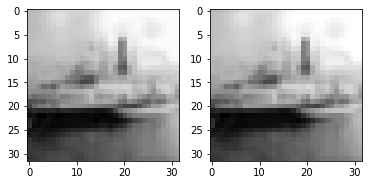

True label: 8
predicted label: 8
Time:  135.44113421440125  seconds
Initial fitness: 
 [-0.599765767500682, -0.5995805109718757, -0.5995689540386591, -0.5994101255642734, -0.5998233536118678, -0.5993778310450228, -0.5992474048012213, -0.5996298254040768, -0.5996744528515865, -0.599759184325998, -0.5995216010740346, -0.5995589312706652, -0.5996803898765545, -0.5997126638377488, -0.5993860187549237, -0.599839356190841, -0.5990157250106738, -0.5999950309694564, -0.5993935958828083, -0.5995903862626821, -0.5996826080764998, -0.5995208506198048, -0.5997034785773914, -0.5995563184803756, -0.5987022910813267, -0.5997823765536197, -0.5994688784086823, -0.599575445246272, -0.5994750996203942, -0.5993535990934822, -0.5995722217989068, -0.5991535707838113, -0.59922079895248, -0.5995814108348654, -0.5995886104043142, -0.5995389083503069, -0.5991731391284842, -0.5995671061290845, -0.5994866214166947, -0.5994714842190896, -0.5995352099940697, -0.5990281553207191, -0.5998551289152373, -0.599339236948

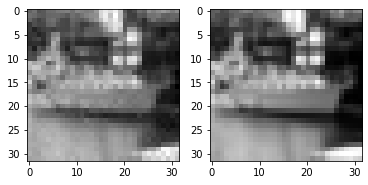

True label: 8
predicted label: 3
Time:  825.186936378479  seconds
Initial fitness: 
 [-0.6029080306326073, -0.60260268984365, -0.6041293873295437, -0.6029110022326072, -0.6009095596403605, -0.6048598901750823, -0.6035503276207933, -0.6033315037717044, -0.6025052191082723, -0.6024189654067187, -0.6037574176746496, -0.6026285366493738, -0.6023943418507494, -0.6023093822894923, -0.6044295330372434, -0.6018935701545116, -0.6065145755933411, -0.603666686822795, -0.6019682883268044, -0.6021102853472358, -0.601939045904105, -0.6000412038343124, -0.6011950978247564, -0.600599441006609, -0.6014096657532298, -0.6022279696113014, -0.6013666794957849, -0.604792174871469, -0.6045355903829175, -0.6020883588019526, -0.6016714258782205, -0.6075305516510338, -0.6013628991651835, -0.6036656198164725, -0.6023544471163205, -0.6029491935811906, -0.6027579967827253, -0.6010565319801611, -0.6022469506735244, -0.601088147347566, -0.6042957543282858, -0.6013288664843985, -0.6012218928574002, -0.601150110614852

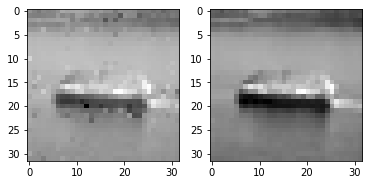

True label: 8
predicted label: 0
Time:  347.028427362442  seconds
Initial fitness: 
 [-0.5999689747063028, -0.5999390464630902, -0.5999431127700922, -0.5999383188968987, -0.6000209104736458, -0.5999697053917852, -0.599985851460318, -0.6000486344562623, -0.5999424348451217, -0.6001105292866447, -0.5999999499204918, -0.5999632546152609, -0.5999227175108848, -0.599912015693421, -0.5998940432567795, -0.6000535439548089, -0.5999448214243498, -0.5999738587418897, -0.5998999262477518, -0.5999169901638179, -0.600009959841641, -0.5999609989083498, -0.5999858627831969, -0.6000207146114105, -0.6000644017864455, -0.6000348859986697, -0.5999988144005041, -0.6000509675533495, -0.5999327157841301, -0.5999098221339115, -0.5998761538019046, -0.599868311367967, -0.5999189203935847, -0.600110696612659, -0.5999222697277181, -0.5997610139254789, -0.5999538688609439, -0.5999548905642695, -0.6000686027546415, -0.6000206035476521, -0.5999119197618299, -0.5999801087593467, -0.5999592623887596, -0.5999340766659

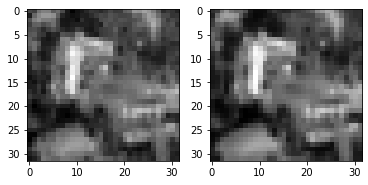

True label: 9
predicted label: 4
Time:  1148.4498360157013  seconds
Initial fitness: 
 [-0.3479742963402067, -0.2826267803989012, 0.0022555846467308127, -0.3047790029799662, -0.17208624815081183, -0.254366212452805, -0.21827712701297672, -0.166968293878609, -0.24177932786446826, -0.13710084732061772, -0.25565455480892674, -0.08465826694042078, -0.2670150617008357, -0.2273458723598389, -0.2810929692802588, -0.23564095442879626, -0.24227150913099976, -0.2179439202481634, -0.2209991297909968, -0.4221063543419513, -0.20117943252186937, -0.2614863572719066, -0.29980166607480374, -0.1370821081398711, -0.23026059974526875, -0.18431048641804695, -0.12905446165425155, -0.3261851798417241, -0.2509509665417984, -0.30063537691995823, -0.237840588237283, -0.2121517631919178, -0.14902431430701873, -0.21083933367192897, -0.2321279165878855, -0.24058570787894196, -0.20247150901040292, -0.2858963168464394, -0.19519506566236494, -0.10252003051186323, -0.3723636994017093, -0.256923573554454, -0.189719217

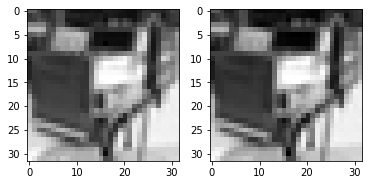

True label: 9
predicted label: 1
Time:  7.2394280433654785  seconds
Initial fitness: 
 [-0.5981331213870156, -0.5978320203680818, -0.5963610335231679, -0.598168654140592, -0.5984290895229789, -0.598417215554214, -0.5992075657569268, -0.5956852545088842, -0.596785290693063, -0.5992375945135336, -0.5984194385189235, -0.5970253639949208, -0.5981166029809694, -0.5988558509042259, -0.5975028481027356, -0.5984651507231998, -0.5977817080548393, -0.5979194399263332, -0.5981370100432521, -0.5981257457188525, -0.6002380667049292, -0.5984793713597527, -0.5975461000369846, -0.5954946479371304, -0.5977110752855082, -0.5980488380412381, -0.5985283599951934, -0.5975412390548894, -0.5986847510662903, -0.5978657017155791, -0.5969026459956948, -0.5979442991120935, -0.5979194334606566, -0.5982517895240286, -0.5975490607962427, -0.5980099763029378, -0.5985255414531065, -0.599816408371611, -0.5987010052391676, -0.5986746431933238, -0.6001718735178858, -0.5983360212733523, -0.5980858962782927, -0.5979944766

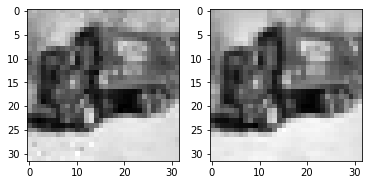

True label: 9
predicted label: 1
Time:  719.6424510478973  seconds
Initial fitness: 
 [-0.6038322374046752, -0.6014810423671552, -0.6012190658282643, -0.6059025886399537, -0.6022700123526348, -0.6039904854066266, -0.6005902273218349, -0.6006512327251977, -0.6056398818571963, -0.6016463925070911, -0.604559443950094, -0.5998321541853368, -0.6057049204469303, -0.6027692135989592, -0.6000947353741781, -0.6002521001158858, -0.6018864758075696, -0.6000859945252865, -0.6039122695807967, -0.6000709817816297, -0.5999416858604266, -0.6023396349167394, -0.6006778551908063, -0.6001870649436067, -0.6047627031382896, -0.5999545021613414, -0.6000313865563474, -0.6001847742852322, -0.5999580472728439, -0.6043975235432024, -0.6001171749965668, -0.6020757369627809, -0.6004687542291841, -0.6000360894171838, -0.5999717712355538, -0.603211496590259, -0.6016629613591196, -0.6007571966270056, -0.6031720803462401, -0.6013300051253483, -0.600082267001753, -0.6024884960486194, -0.6002118178369921, -0.6018206943

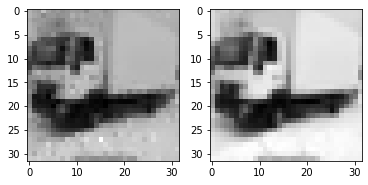

True label: 9
predicted label: 8
Time:  390.7398364543915  seconds
Initial fitness: 
 [-0.6016718110826123, -0.5998704077451277, -0.6008570019872818, -0.6032272070808095, -0.6000852780574085, -0.6007623339124648, -0.5998595225284041, -0.6048647450129019, -0.6004486711671484, -0.6036787074827522, -0.5995688678943607, -0.6046208203137146, -0.5999944430536877, -0.5999128437310696, -0.600381084084467, -0.6007055070227773, -0.5997131978248853, -0.6001287131352491, -0.5999332081885117, -0.5998547079636345, -0.5997011479547593, -0.599971853186019, -0.6043549220026322, -0.6003671918945328, -0.6023233027398174, -0.5996633371572173, -0.6056799042954041, -0.6079891743458112, -0.6007015849305551, -0.6025449564771201, -0.60396110679825, -0.6009960996399485, -0.6022674825003738, -0.6008325857177571, -0.6029816248842478, -0.6002103486591643, -0.6036439763203475, -0.6005297435077654, -0.6040482236384519, -0.5996397651410297, -0.6020664566444618, -0.5997960161685366, -0.6076623034294025, -0.60033052092

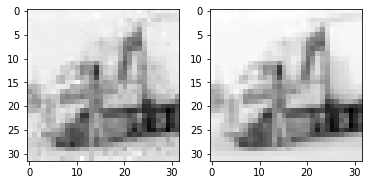

True label: 9
predicted label: 8
Time:  657.72754073143  seconds
Initial fitness: 
 [-0.6000580348434424, -0.600201514295744, -0.6000413230010374, -0.6003471650901826, -0.600596750859246, -0.6000866592346106, -0.6003108327137471, -0.6007439775347467, -0.6000765208187784, -0.6000805815258116, -0.6001847523942145, -0.6003126366211922, -0.6001051447969095, -0.6001054946550152, -0.6000684106643475, -0.6000417383660999, -0.6002906769130576, -0.6000110825240718, -0.6002877493760082, -0.6003381254047321, -0.6003263626019948, -0.6001611812298858, -0.6001096678084326, -0.6002400877635498, -0.6001309907373505, -0.6001267837612081, -0.6001632963432708, -0.6000580191857162, -0.6000707698317018, -0.6000355368816112, -0.6002899384868586, -0.6001880876220482, -0.6001853581454772, -0.6000393292163614, -0.6000895760315479, -0.600436790418023, -0.600124159320509, -0.6003769511752294, -0.6000315600879061, -0.6002245017236112, -0.6001117786560435, -0.6007853388504067, -0.6000961237437566, -0.6000420620348

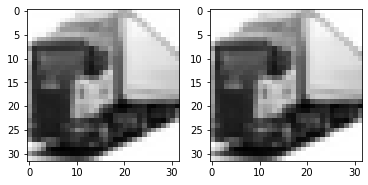

True label: 9
predicted label: 9
Time:  180.71219539642334  seconds
Initial fitness: 
 [-0.45331069499845833, -0.4794406076804617, -0.5231837299235643, -0.5093998769563925, -0.4400044848393614, -0.509634512644376, -0.4994587023671321, -0.47672229348560596, -0.4639313654327748, -0.4951196995646384, -0.4833728354622493, -0.4782916162532677, -0.48422491832529985, -0.46723980743019833, -0.47796171948077393, -0.4272867575345154, -0.47505906490653294, -0.46996888612618387, -0.47044462205243204, -0.4350320436980113, -0.5180228898144612, -0.4497302709625505, -0.5026146998919508, -0.44337734250870087, -0.500019065738186, -0.47230154273522246, -0.38642876835168094, -0.45596989461389126, -0.5037453350424098, -0.486555278450266, -0.4878586764099959, -0.5044057282196281, -0.5145981993365265, -0.524047812217803, -0.42330599882784775, -0.5079512369239527, -0.47482417934414334, -0.46065186290213855, -0.48203108268280487, -0.47867588376399006, -0.46008234799760056, -0.4457675118418988, -0.4810882619622

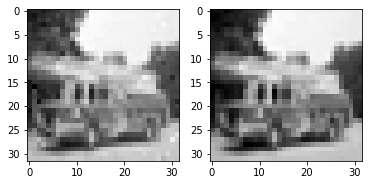

True label: 9
predicted label: 1
Time:  490.9240825176239  seconds
Initial fitness: 
 [-0.5999349105522734, -0.5999100774019966, -0.5999129538447837, -0.5999769998564293, -0.5997511741324277, -0.5998037755022222, -0.5997418966182511, -0.5997414317840272, -0.5998377039519082, -0.6000069877150472, -0.5998130306637977, -0.5999492048972028, -0.5999164282821676, -0.5998190189337409, -0.5997850149635588, -0.6000381033958342, -0.5998209944724877, -0.5997598943146552, -0.6000273639106797, -0.5999922739756524, -0.5998869917816471, -0.5997004743575888, -0.5999234822621593, -0.5999266954615987, -0.5999841622243206, -0.599916640559507, -0.5999032516406659, -0.599801431702828, -0.5998928214371565, -0.59986097520841, -0.5998548251076956, -0.5999152076389719, -0.6000671853036373, -0.5998295228802658, -0.5998344248656494, -0.5999661677687772, -0.5998367806046185, -0.5996584142075365, -0.599869060619647, -0.5995933055222753, -0.5997366092240666, -0.5997926061573713, -0.5998334924220257, -0.599827886543

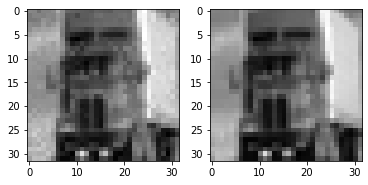

True label: 9
predicted label: 1
Time:  1116.2034213542938  seconds
Initial fitness: 
 [-0.5312205162570791, -0.5102481020898748, -0.4801408820066682, -0.535361036788174, -0.5208191426435864, -0.5259588402471688, -0.5341241398530764, -0.517060845327732, -0.5038612797731697, -0.5273420437782713, -0.5335365173639772, -0.4928038262091889, -0.5326557854618112, -0.5086725333396159, -0.5256531188760776, -0.5297893118876416, -0.51868896541914, -0.49673756561698784, -0.49674169177026856, -0.5273608945894009, -0.5461973341699672, -0.5175523279445483, -0.5250063293822329, -0.5146374895189512, -0.5315675792427776, -0.5121991826783345, -0.5123570916127582, -0.5160356166779749, -0.5201236566087816, -0.533797347715588, -0.5138179753829571, -0.5202110738019158, -0.5304485543442814, -0.5209045088118328, -0.49939884857442446, -0.5246490938126374, -0.5410187051099264, -0.5250024725408688, -0.4866293783017498, -0.5006230640328369, -0.5231019605849085, -0.502775281396332, -0.5346755827949825, -0.517953259

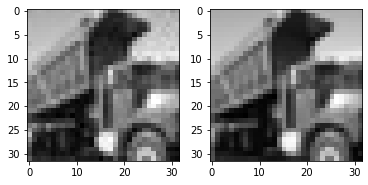

True label: 9
predicted label: 2
Time:  1020.4365000724792  seconds
Initial fitness: 
 [-0.5986486271039465, -0.5986884067140872, -0.5968429522842853, -0.5966930025645347, -0.5976952616471737, -0.5970040069480739, -0.5982402795572207, -0.5972070177399073, -0.5976782749379592, -0.5965389352666824, -0.5978196976558265, -0.5980526648701199, -0.5973624143063303, -0.5986840573364192, -0.5982877610260501, -0.5982258912551027, -0.5986466464059013, -0.5961379168545744, -0.5977274026624888, -0.5979562885113119, -0.5986159249352911, -0.5987216561806502, -0.5986763679555954, -0.5976183635748266, -0.5981708873151836, -0.598513187928962, -0.5993070282476136, -0.5969601952799741, -0.5978901819691795, -0.5976075248700508, -0.598580388133592, -0.5965517286302859, -0.5987522196686726, -0.5985394244248224, -0.5978478170537194, -0.5988297441339274, -0.597773924401769, -0.5982204792863083, -0.5979443600971104, -0.5999449322464296, -0.598203136232242, -0.5980841801987855, -0.5964539479359328, -0.5986096467

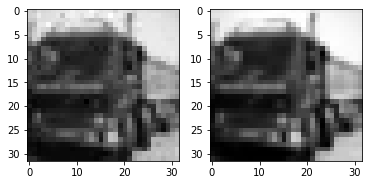

True label: 9
predicted label: 1
Time:  549.3115212917328  seconds
Initial fitness: 
 [-0.13461749486212993, 0.17188036744995477, 0.2169346939483589, 0.22402561492388184, 0.25512495696963355, 0.15079847748929537, 0.11233185589227873, 0.08547915507379332, 0.40741474978289005, 0.23204151553762473, 0.10111776436902442, 0.34856869361322357, 0.10950292673886655, -0.052238570277478885, 0.0038083918097157887, 0.09164796959073782, 0.13556172938376687, -0.030918088230088903, 0.09907019498183997, 0.13951918147129522, -0.009786821208557783, 0.02469381519435143, 0.22325895496387965, 0.11279211595068546, 0.07218460143685301, 0.08282788864354154, 0.19354799510952642, 0.4355298965975599, -0.0619167422564354, 0.19881085027058634, 0.14210177549567116, 0.14381977979002547, 0.03184599525892792, 0.17094529820968513, 0.001463483092658896, 0.30795317900559305, 0.22991050166872234, 0.24560398812914794, 0.18339999074132432, 0.09816142564024473, 0.26968948399230025, -0.05816653802880206, 0.2069555629811852, -0

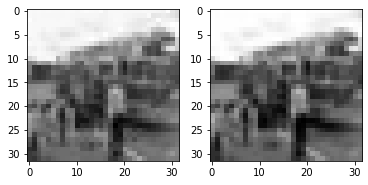

True label: 9
predicted label: 7
Time:  325.2729232311249  seconds
Initial fitness: 
 [-0.6003853708397453, -0.6007068169394743, -0.6000528229302927, -0.6003205261956694, -0.6005469145527649, -0.6007338145905157, -0.6001875131949732, -0.6002901247218712, -0.6006568573301737, -0.6003077891887406, -0.6019972709346113, -0.6001691815008352, -0.6001674194201431, -0.6006121555300455, -0.6012519485437519, -0.601340478382232, -0.6003884443245485, -0.6000647568494484, -0.6000955532091392, -0.6006703598519547, -0.6006535285782679, -0.6002929555976542, -0.6001273734700436, -0.6001567174116613, -0.6004688925472641, -0.6012114710086869, -0.6000528967275132, -0.6004721010408657, -0.6000249411143683, -0.6003722210422016, -0.600188036174485, -0.6005499894168834, -0.6003299391151331, -0.6004164882681325, -0.600060527412315, -0.600051274869385, -0.6001160454589649, -0.5999906498324867, -0.6003049668344342, -0.6001440149097093, -0.6000356522783171, -0.6008063982474007, -0.6000956388174945, -0.60070342177

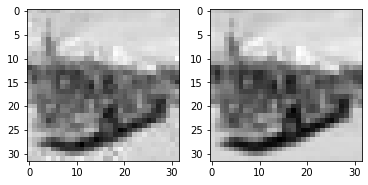

True label: 9
predicted label: 6
Time:  610.8928754329681  seconds
Initial fitness: 
 [-0.6001772594821745, -0.6000524502969323, -0.600452818995145, -0.6000809951712556, -0.6005680430853836, -0.6002216381461233, -0.6002256316425967, -0.6004588913236011, -0.6002670631639822, -0.6000017324843043, -0.6002949798954652, -0.6000073800776324, -0.600082211111367, -0.600068412867834, -0.6002637251097245, -0.6002186279095107, -0.6001674204796912, -0.6000971862185369, -0.6002187480535415, -0.6000491720577533, -0.6001575180017519, -0.6001722106015388, -0.6000649084993033, -0.6002316872930396, -0.6000204229867065, -0.5999973350148549, -0.6003112440197281, -0.6000978323663112, -0.6001118413235101, -0.6004980726191088, -0.6001266669589718, -0.6003005585249079, -0.6000425543033514, -0.6001707336596318, -0.6000920311770193, -0.6001586049803669, -0.6000476953356776, -0.6000567891523261, -0.6002867293931347, -0.6000223126391698, -0.6000966592392214, -0.600049619561189, -0.6000988561483229, -0.60010230647

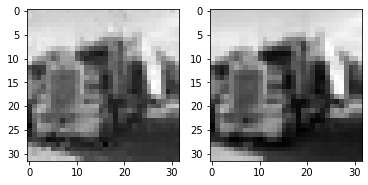

True label: 9
predicted label: 7
Time:  977.2646870613098  seconds
Initial fitness: 
 [0.4110489098312079, 0.1996834487671435, 0.43840668435596153, 0.3504317679627601, 0.32511603786574017, 0.3596593249492751, 0.5035508329448377, 0.3970222522586666, 0.41463792625409757, 0.4020600819721084, 0.4082859218500181, 0.40724291219374176, -0.06306965562183489, 0.5212060616945258, 0.38036170624514926, 0.5319011189550263, 0.26127714200022734, 0.4813979664917412, 0.13739777867726471, 0.5029833272809341, 0.5697069677138161, 0.2570447071051855, 0.06892619892706273, 0.21101865189646574, 0.27303455592323256, 0.31989903947497844, -0.018080022674766855, 0.48683539342816656, 0.5190339264427684, 0.35520151598584576, 0.0711311011863637, 0.4674549531156637, -0.13476493123196692, 0.357046812691599, 0.3656698978086972, 0.2464757157187669, 0.17509810590643443, 0.29412643140082567, 0.4161743806393393, 0.4452784700842468, 0.3096523514705208, 0.35915596003879025, 0.23839947563261082, 0.28104944404066273, 0.4144630

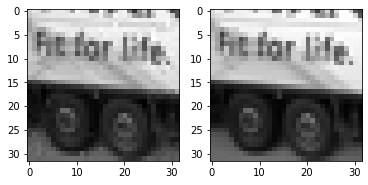

True label: 9
predicted label: 1
Time:  442.37681460380554  seconds


In [19]:
# for each image and label in adversarial
n=50
import time
# these are the examples that are found as adversarialwe will save these at the end in a file
evolved_examples= []
# fitness of the adversarials
fitness_of_evolved=[]
# time necessary to evolve the adversarial
times=[]
# the distance between the original image and the adversarial
ssim_values=[]
# number of round necessary to produce adversarial 
number_of_rounds=[]
# this will serve to see if the fitness changes or not 
best_fitness = 0


numb_of_found_after30=0
numb_of_adv_found=0

#dictionary to keep the best individual to check if the fitness is improving or not 


predicted_class= []
for img,label in zip(adversarial,adversarial_y):
  winner_of_gen = {"image":[],"label": None, "fitness": None}
  #temporary variable to check generations:
  fitness_no_change = 0
  start = time.time()
  label=label[0]
  #intialize population from the image and with the given label
  population = init_pop_from_sample(n,img,label)
  # calculate fitness of these individuals
  fitness = pop_fitness(model,np.expand_dims(population.reshape(population.shape[0],CIFAR_IMG,CIFAR_IMG),axis=3),img.reshape(CIFAR_IMG,CIFAR_IMG),label)
  print(f"Initial fitness: \n {fitness}")
  #retun the best one from the population
  best,fit_max = return_best_individual(population,fitness)
  #check if adversarial
  check_adv = check_adv_termination(best,label,img, model)
  #define max generation
  max_gen=0
  winner_of_gen.update(image= best)
  winner_of_gen.update(label= label)
  winner_of_gen.update(fitness= fit_max)
  while (len(check_adv)==0 or max_gen<10000):
      new_pop=[]
      for i in range(50):
        parent1= tournament(population, model, img, label) 
        parent2 = tournament(population, model, img, label)
        if 0.8 > np.random.uniform(0.0, 1.0):
          child1, child2 = multi_crossover(parent1, parent2,img) # crossover
          new_pop.append(add_noise(choose_better_child(child1, child2,img,label,model)))
        else:
          new_pop.append(add_noise(choose_better_child(parent1, parent2,img,label,model)))

      # to reshape into an array 
      population= np.array(new_pop)
      #check fitness of the generation
      fitness = pop_fitness(model,np.expand_dims(population.reshape(population.shape[0],CIFAR_IMG,CIFAR_IMG),axis=3),img.reshape(CIFAR_IMG,CIFAR_IMG),label) 
      #find the highest fitness
      best,fit_max1 = return_best_individual(population,fitness)
      # check adversarial - check if pred != target, distance < 0.001 or fitness didn't improve 0.001 after 30 generations(this is in else condition)
      check_adv = check_adv_termination(best,label,img,model)

      #check if the first termination true 
      if(len(check_adv) != 0):
        print("Adversarial example image: \n")
        evolved_examples.append(check_adv) #add evolved example
        ssim_values.append(1-compare_ssim(check_adv.reshape(CIFAR_IMG,CIFAR_IMG),img.reshape(CIFAR_IMG,CIFAR_IMG))) #add the distance
        end=time.time()
        times.append(end-start) #add the time 
        fitness_of_evolved.append(calculate_fitness(model,check_adv,img,label)) #add the fitness value of adversarial
        number_of_rounds.append(max_gen)
        pred_l=np.argmax(model.predict(check_adv.reshape(1,CIFAR_IMG,CIFAR_IMG,1)/255.0))
        predicted_class.append(pred_l)
        print("Left: adversarial \t Right: ground truth")
        fd, idx = plt.subplots(1,2)
        idx[0].imshow(check_adv.reshape(CIFAR_IMG,CIFAR_IMG),cmap='gray')
        idx[1].imshow(img.reshape(CIFAR_IMG,CIFAR_IMG),cmap='gray')
        plt.show()
        print(f"True label: {label}")
        print(f"predicted label: {pred_l}") 
        print("Time: ",end-start ," seconds")
        numb_of_adv_found+=1
        break
      #check the second termination 
      else:
          #check if fitness increases, if not , add +1 to temporary var
        if fit_max1>fit_max:
          fit_max=fit_max1
          winner_of_gen.update(image= best)
          winner_of_gen.update(label= label)
          winner_of_gen.update(fitness= fit_max1)
          fitness_no_change=0
        else:
          fitness_no_change+=1
      
      #print after every 10 generations to see the progress
      if (max_gen % 10 == 0):
        print(f"Generation {max_gen}")
        print(f"Max fitness value {fit_max}")
      max_gen+=1

      # if fitness did not improve for 30 generations, save the image that was best , saved it in a dicitonary
      if fitness_no_change==30:
        print("FITNESS DID NOT IMPROVE FOR 30 GENERATIONS")
        print("Best adversarial image we could find: \n")
        evolved_examples.append(winner_of_gen["image"])
        ssim_values.append(1-compare_ssim(np.array(winner_of_gen["image"]).reshape(CIFAR_IMG,CIFAR_IMG),img.reshape(CIFAR_IMG,CIFAR_IMG)))
        number_of_rounds.append(max_gen)
        end=time.time()
        times.append(end-start)
        fitness_of_evolved.append(winner_of_gen["fitness"])
        pred_l=np.argmax(model.predict(np.array(winner_of_gen["image"]).reshape(1,CIFAR_IMG,CIFAR_IMG,1)/255.0))
        predicted_class.append(pred_l)
        print("Left: adversarial \t Right: ground truth")
        fd, idx = plt.subplots(1,2)
        idx[0].imshow(np.array(winner_of_gen["image"]).reshape(CIFAR_IMG,CIFAR_IMG),cmap='gray')
        idx[1].imshow(img.reshape(CIFAR_IMG,CIFAR_IMG),cmap='gray')
        plt.show()
        print(f"True label: {label}")
        print(f"predicted label: {pred_l}")
        print("Time: ",end-start ," seconds")
        numb_of_found_after30 +=1
        break




# Save files


In [20]:
import pickle
file_ = open('GA_adv_cifar_ssim_multicrossoverCORRECTuniform', 'wb')
pickle.dump(evolved_examples, file_)
pickle.dump(times, file_)
pickle.dump(ssim_values, file_)
pickle.dump(fitness_of_evolved , file_)
pickle.dump(predicted_class, file_)
pickle.dump(number_of_rounds, file_)
file_.close()

print(f"Max time: {np.max(times)}")
print(f"Min time: {np.min(times)}")
print(f"Mean time: {np.mean(times)}")
print(f"Std time: {np.std(times)}\n")

print(f"Max fitness evolved: {np.max(fitness_of_evolved)}")
print(f"Min fitness evolved:: {np.min(fitness_of_evolved)}")
print(f"Mean fitness evolved: {np.mean(fitness_of_evolved)}")
print(f"Std fitness evolved:: {np.std(fitness_of_evolved)}\n")

print(f"Max ssim: {np.max(ssim_values)}")
print(f"Min ssim: {np.min(ssim_values)}")
print(f"Mean ssim: {np.mean(ssim_values)}")
print(f"Std ssim: {np.std(ssim_values)}\n")

print(f"Max rounds: {np.max(number_of_rounds)}")
print(f"Min rounds: {np.min(number_of_rounds)}")
print(f"Mean rounds: {np.mean(number_of_rounds)}")
print(f"Std rounds: {np.std(number_of_rounds)}\n")




print(f"Percentage of adversarial founds sucessfully : {numb_of_adv_found/len(adversarial_y)} %")
print(f"Percentage of adversarial founds after fitness not improving for 30 generations: {numb_of_found_after30/len(adversarial_y)} %")


Max time: 8764.866561174393
Min time: 4.604083061218262
Mean time: 565.3738096943475
Std time: 773.2276299709284

Max fitness evolved: 0.9988930041818804
Min fitness evolved:: -0.6011243144685761
Mean fitness evolved: 0.8374327717761791
Std fitness evolved:: 0.46045767217336836

Max ssim: 0.2363242302875539
Min ssim: 4.10516817950235e-06
Mean ssim: 0.02259041900809801
Std ssim: 0.02808595967176175

Max rounds: 275
Min rounds: 0
Mean rounds: 109.9172932330827
Std rounds: 59.602574137374575

Percentage of adversarial founds sucessfully : 0.045112781954887216 %
Percentage of adversarial founds after fitness not improving for 30 generations: 0.9548872180451128 %


Open adversarial

In [25]:
with open('./results/GA_adv_cifar_ssim_multicrossover', 'rb') as f:
    evolved_examples = pickle.load(f)
    times= pickle.load(f)
    ssim_values = pickle.load(f)
    fitness_of_evolved = pickle.load(f)
    predicted_class = pickle.load(f)
    number_of_rounds = pickle.load(f)

In [26]:
#Correction of ssim values
new_ssim=[]
for s in ssim_values:
    new_ssim.append(1-s)
    
print(f"Max ssim: {np.max(new_ssim)}")
print(f"Min ssim: {np.min(new_ssim)}")
print(f"Mean ssim: {np.mean(new_ssim)}")
print(f"Std ssim: {np.std(new_ssim)}\n")

Max ssim: 1.0
Min ssim: 0.7775522980511842
Mean ssim: 0.9730846868874802
Std ssim: 0.030118139624998513



In [34]:
#Correctionf of rounds  (replacing 0 with 1)
number_of_rounds = np.where(np.array(number_of_rounds)==0, 1, number_of_rounds) 

In [35]:
number_of_rounds

array([  1, 116,  58, 113,  54,  51, 190, 133, 107,  54,  79,  46, 111,
       125, 164,  31,   1,  47,  70,  30,  77,  30,  75,  30,  30, 206,
        52,  69, 108, 192,  60,  93, 100,  77, 230,  67,  30,  30, 130,
        41,  70, 156, 220,  58,  62, 151, 108, 124, 120, 174,  66,  66,
       128,  66,  79, 132,  40,  56,  77,   1,  88, 152,  65,  93,  76,
        52,  56, 145,  54, 171,  54,  62,  82, 117, 111, 132,  97, 246,
         1,  71,  30, 116,  52, 193,  73,  65, 198,  76, 151, 194, 120,
       180, 219, 105,  77, 149, 152, 103, 139,  55,   1,  59, 183, 120,
       154,  75, 126, 111,  60, 112, 108, 146,  65, 103,  65, 111,  30,
       113,  51, 243, 123, 147, 109,  80,  30, 133, 111, 252, 182,  87,
        65, 281,  61])

In [36]:
print(f"Max rounds: {np.max(number_of_rounds)}")
print(f"Min rounds: {np.min(number_of_rounds)}")
print(f"Mean rounds: {np.mean(number_of_rounds)}")
print(f"Std rounds: {np.std(number_of_rounds)}\n")

Max rounds: 281
Min rounds: 1
Mean rounds: 100.23308270676692
Std rounds: 57.67577086292178



# Examples of what functions do

In [0]:
population = init_pop_from_sample(50,adversarial[15],adversarial_y[15][0])
fitness = pop_fitness(model,np.expand_dims(population.reshape(population.shape[0],CIFAR_IMG,CIFAR_IMG),axis=3),img.reshape(CIFAR_IMG,CIFAR_IMG),adversarial_y[15][0])
print(fitness)

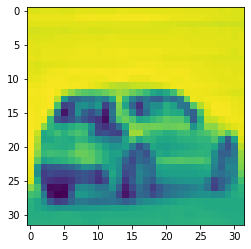

Class for this 1
[[2.2063480e-10 1.0000000e+00 6.6041472e-14 3.5760719e-12 3.9276270e-13
  1.1313486e-13 8.8119643e-13 6.8588521e-13 1.9681285e-13 3.7839783e-08]]


In [0]:
plt.imshow(population[0].reshape(CIFAR_IMG,CIFAR_IMG))
plt.show()
print(f"Class for this {adversarial_y[15][0]}")
print(model.predict(population[0].reshape(1,CIFAR_IMG,CIFAR_IMG,1) /255.0))

In [0]:
parent1 = tournament(population, model, adversarial[15], adversarial_y[15]) 
parent2 = tournament(population, model, adversarial[15], adversarial_y[15])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/skimage/measure/_structural_similarity.py:17: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  **kwargs)


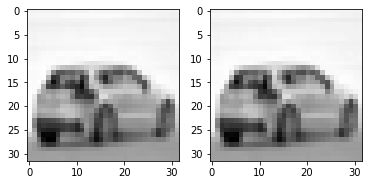

In [0]:
fd, idx =  plt.subplots(1,2)
idx[0].imshow(parent1.reshape(CIFAR_IMG,CIFAR_IMG),cmap="gray")
idx[1].imshow(parent2.reshape(CIFAR_IMG,CIFAR_IMG),cmap="gray")

In [0]:
child1, child2 = multi_crossover(parent1, parent2,adversarial[15]) # crossover 
#child1, child2 = add_noise(child1), add_noise(child2) # apply mutation to pixels 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/skimage/measure/_structural_similarity.py:17: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  **kwargs)


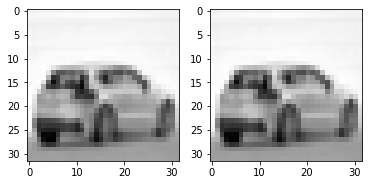

In [0]:
fd, idx =  plt.subplots(1,2)
idx[0].imshow(child1.reshape(CIFAR_IMG,CIFAR_IMG),cmap="gray")
idx[1].imshow(child2.reshape(CIFAR_IMG,CIFAR_IMG),cmap="gray")


In [0]:
print(f"diff between children {np.unique(child1-child2)}")
print(f"diff between parents {np.unique(parent1-parent2)}")
print(f"diff between p1 and c1 {np.unique(parent1-child1)}")
print(f"diff between p1 and c2 {np.unique(parent1-child2)}")
print(f"diff between p2 and c1 {np.unique(parent2-child1)}")
print(f"diff between p2 and c2 {np.unique(parent2-child2)}")

In [0]:
bb = choose_better_child(child1, child2,adversarial[15],adversarial_y[15][0],model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/skimage/measure/_structural_similarity.py:17: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  **kwargs)


In [0]:
fitness = pop_fitness(model,np.expand_dims(population.reshape(population.shape[0],CIFAR_IMG,CIFAR_IMG),axis=3),img.reshape(CIFAR_IMG,CIFAR_IMG),label) 
print(fitness)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/skimage/measure/_structural_similarity.py:17: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  **kwargs)


[-0.26002962878595726, -0.25999958545736684, -0.26007314251448344, -0.26004007622401076, -0.26003266487525345, -0.26011373574731095, -0.2599816460817825, -0.25998496480763594, -0.2600353571926644, -0.2600021864303609, -0.260040721413234, -0.2600228430135187, -0.26003768485830203, -0.26002701209750284, -0.26006302743228543, -0.2599796432991168, -0.2600043346069123, -0.26003024147792836, -0.2600466627237271, -0.26003812318804226, -0.2600652442884724, -0.2600447098702882, -0.2600085762943468, -0.26001327339828323, -0.2599806557454484, -0.26007237070197037, -0.25996000471207786, -0.2600457997287944, -0.2600101441535663, -0.26005323947618036, -0.2600554130353725, -0.2600860828123626, -0.26003997918862914, -0.26004537198733424, -0.2600515291553301, -0.2600503663988854, -0.26001231736237695, -0.2600170667581806, -0.2600851316879575, -0.2599960477747653, -0.260017809873727, -0.2600171997460062, -0.2600455137861651, -0.26001145913341955, -0.2600466317811507, -0.2600557191632309, -0.260061281083